<a href="https://colab.research.google.com/github/Caarevalor/DS_Proyecto_03/blob/main/DS_Proyecto_03_ST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Proyecto 03 - Series de Tiempo

## Dataset: Flujo Vehicular por Unidades de Peaje AUSA

**Recuerda descargar el dataset de [aquí](https://data.buenosaires.gob.ar/dataset/flujo-vehicular-por-unidades-peaje-ausa). Deberás descargar -  al menos para comenzar - los años 2017, 2018 y 2019.**

En este notebook te dejamos unas celdas para que puedas comenzar a trabajar con este dataset para los años 2017, 2018 y 2019. Si deseas utilizar otros años, ten en cuenta que deberás hacer el preprocesamiento correspondiente, ya que la estructura de los datos puede variar.

**Importante:** Para el proyecto, debes comenzar con los datos de la autopista Illia, pago en Efectivo.

### Exploración de datos

Dedícale un buen tiempo a hacer un Análisis Exploratorio de Datos. Elige preguntas que creas que puedas responder con este dataset. Por ejemplo, ¿Cuáles son los días y horarios de mayor tráfico? También, estudia autocorrelaciones, resampleos, etc.

#### Componentes de la serie

1. Calcula las componentes estacionales y tendencia de la serie. Interpreta los resultados, si es necesario con información auxiliar (por fuera del dataset) o elementos del dataset que no estés utilizando (por ejemplo, si la tendencia es negativa, ¿puede ser porque se migre a otras formas de pago?).
1. ¿La serie posee valores atípicos? Si es así, interpreta, si es necesario con información auxiliar. **Pista**: primer semestre 2019.

### Predicción a Futuro

Debes implementar un modelo que prediga el tráfico en la autopista Illia para el último trimestre del 2019. 

1. Haz todas las transformaciones de datos que consideres necesarias. Justifica.
1. Evalúa de forma apropiada tus resultados. Justifica la métrica elegida.
1. Elige un modelo benchmark y compara tus resultados con este modelo.
1. Optimiza los hiperparámetros de tu modelo. 
1. Intenta responder la pregunta: ¿Qué información está usando el modelo para predecir?
1. Utiliza el modelo creado para predecir el tráfico en el año 2020. ¿Cómo funciona?
1. Si lo deseas, puedes agregar información de años anteriores a 2017. ¿Mejoran los resultados?

### Para pensar, investigar y, opcionalmente, implementar
1. ¿Cómo incorporarías la información sobre tipo de vehículo, forma de pago, sentido, día de la semana, etc.? En lo que respecta a las predicciones, ¿mejoran o empeoran?
1. ¿Qué ocurre si comparas las series de tiempo entre distintas estaciones de peajes?¿Tienen el mismo comportamiento o hay alguna que sea distinta a las otras? Si es así, ¿hay información auxiliar que te ayude a explicar lo que encuentras?
1. ¿Hay algo que te gustaría investigar o probar?

### **¡Tómate tiempo para investigar y leer mucho!**

### 1. Preparación del Dataset

In [ ]:
!pip install pmdarima
!pip install statsmodels --upgrade

In [ ]:
#Se importan todas las librerias que vamos a necesitar para la ejecución del notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.api.types import CategoricalDtype
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error      # Importación de la metrica error cuadrático medio desde scikit learn
from sklearn.metrics import r2_score              # Importación de la metrica error r^2 desde scikit learn
from sklearn.metrics import mean_absolute_error   # Importación de la metrica error MAE desde scikit learn
from matplotlib import pyplot


## Exploración de datos

In [ ]:
#a continuacion se define una funcion que se usara como metrica de error
#llamada Error Porcentual Absoluto Medio (MAPE), que indica procentualmente que tan arriba o que tan abajo esta
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [ ]:

#Se importan los archivos con la data de los 4 años (2016 a 2020)
data_2019 = pd.read_csv('/content/drive/MyDrive/Acamica_Python/3er_Proyecto/flujo-vehicular-2019.csv', sep =',')
data_2018 = pd.read_csv('/content/drive/MyDrive/Acamica_Python/3er_Proyecto/flujo-vehicular-2018.csv', sep =',')
data_2017 = pd.read_csv('/content/drive/MyDrive/Acamica_Python/3er_Proyecto/flujo-vehicular-2017.csv', sep =',')
data_2016 = pd.read_csv('/content/drive/MyDrive/Acamica_Python/3er_Proyecto/flujo-vehicular-2016.csv', sep =',')

In [ ]:
#Exploración de los datos para el 2019
data_2019.info()
data_2019.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 812153 entries, 0 to 812152
Data columns (total 10 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   periodo         812153 non-null  int64 
 1   fecha           812153 non-null  object
 2   hora_inicio     812153 non-null  int64 
 3   hora_fin        812153 non-null  int64 
 4   dia             812153 non-null  object
 5   estacion        812153 non-null  object
 6   sentido         812153 non-null  object
 7   tipo_vehiculo   812153 non-null  object
 8   forma_pago      812153 non-null  object
 9   cantidad_pasos  812153 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 62.0+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2019  2019-01-01            0  ...        Liviano  NO COBRADO             22
1     2019  2019-01-01            0  ...        Liviano    TELEPASE              6
2     2019  2019-01-01            0  ...        Liviano  NO COBRADO             53
3     2019  2019-01-01            0  ...        Liviano    TELEPASE             18
4     2019  2019-01-01            0  ...        Liviano    EFECTIVO             16

[5 rows x 10 columns]

In [ ]:
#Exploración de los datos para el 2018
data_2018.info()
data_2018.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1375908 entries, 0 to 1375907
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1375908 non-null  int64 
 1   fecha           1375908 non-null  object
 2   hora_inicio     1375908 non-null  int64 
 3   hora_fin        1375908 non-null  int64 
 4   dia             1375908 non-null  object
 5   estacion        1375908 non-null  object
 6   sentido         1375908 non-null  object
 7   tipo_vehiculo   1375908 non-null  object
 8   forma_pago      1375908 non-null  object
 9   cantidad_pasos  1375908 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.0+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2018  2018-01-01            0  ...        Liviano  NO COBRADO             29
1     2018  2018-01-01            0  ...        Liviano    TELEPASE              9
2     2018  2018-01-01            1  ...        Liviano  NO COBRADO             73
3     2018  2018-01-01            1  ...        Liviano    TELEPASE             39
4     2018  2018-01-01            2  ...        Liviano  NO COBRADO            115

[5 rows x 10 columns]

In [ ]:
#Exploración de los datos para el 2017
data_2017.info()
data_2017.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372645 entries, 0 to 1372644
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1372645 non-null  int64 
 1   fecha           1372645 non-null  object
 2   hora_inicio     1372645 non-null  int64 
 3   hora_fin        1372645 non-null  int64 
 4   dia             1372645 non-null  object
 5   estacion        1372645 non-null  object
 6   sentido         1372645 non-null  object
 7   tipo_vehiculo   1372645 non-null  object
 8   forma_pago      1372645 non-null  object
 9   cantidad_pasos  1372645 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 104.7+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2017  2017-01-01            0  ...        Liviano  NO COBRADO             25
1     2017  2017-01-01            0  ...        Liviano    TELEPASE              7
2     2017  2017-01-01            1  ...        Liviano  NO COBRADO              5
3     2017  2017-01-01            1  ...        Liviano    EFECTIVO              2
4     2017  2017-01-01            1  ...        Liviano    EFECTIVO             94

[5 rows x 10 columns]

In [ ]:
#Exploración de los datos para el 2016
data_2016.info()
data_2016.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1379443 entries, 0 to 1379442
Data columns (total 10 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   periodo         1379443 non-null  int64 
 1   fecha           1379443 non-null  object
 2   hora_inicio     1379443 non-null  int64 
 3   hora_fin        1379443 non-null  int64 
 4   dia             1379443 non-null  object
 5   estacion        1379443 non-null  object
 6   sentido         1379443 non-null  object
 7   tipo_vehiculo   1379443 non-null  object
 8   forma_pago      1379443 non-null  object
 9   cantidad_pasos  1379443 non-null  int64 
dtypes: int64(4), object(6)
memory usage: 105.2+ MB


periodo       fecha  hora_inicio  ...  tipo_vehiculo  forma_pago cantidad_pasos
0     2016  2016-01-01            0  ...        Liviano  NO COBRADO             32
1     2016  2016-01-01            0  ...        Liviano      AUPASS              9
2     2016  2016-01-01            1  ...        Liviano  NO COBRADO              1
3     2016  2016-01-01            1  ...        Liviano    EFECTIVO              4
4     2016  2016-01-01            1  ...        Liviano      EXENTO              3

[5 rows x 10 columns]

Se observa que los datasets son bastante similares y que ninguno tiene valores faltantes

Investiguemos que valores toman los campos **estacion, sentido, tipo_vehiculo y forma_pago**

In [ ]:
#Se van a observar cuales son las estaciones que se tienen por año 
print(data_2019['estacion'].unique())
print(data_2018['estacion'].unique())
print(data_2017['estacion'].unique())
print(data_2016['estacion'].unique())

['Alberti' 'Avellaneda' 'Dellepiane' 'Illia' 'Retiro' 'Salguero'
 'Sarmiento' 'PDB']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']
['Alberdi' 'Avellaneda' 'Dellepiane Centro' 'Dellepiane Liniers' 'Illia'
 'Retiro' 'Salguero' 'Sarmiento']


In [ ]:
#Se van a observar cuales son los sentidos que se tiene cada estación por año 
print(data_2019['sentido'].unique())
print(data_2018['sentido'].unique())
print(data_2017['sentido'].unique())
print(data_2016['sentido'].unique())

['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']
['Centro' 'Provincia']


In [ ]:
#Se observa cuales son l que se tieneos tipos de vehiculo que transitan por año 
print(data_2019['tipo_vehiculo'].unique())
print(data_2018['tipo_vehiculo'].unique())
print(data_2017['tipo_vehiculo'].unique())
print(data_2016['tipo_vehiculo'].unique())

['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']
['Liviano' 'Pesado']


In [ ]:
#Se va a imprimir el dato de las formas de pago por cada año 
print(data_2019['forma_pago'].unique())
print(data_2018['forma_pago'].unique())
print(data_2017['forma_pago'].unique())
print(data_2016['forma_pago'].unique())

['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'INFRACCION'
 'T. DISCAPACIDAD']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION']
['NO COBRADO' 'TELEPASE' 'EFECTIVO' 'TARJETA DISCAPACIDAD' 'EXENTO'
 'INFRACCION' 'MONEDERO' 'Otros']
['NO COBRADO' 'AUPASS' 'EFECTIVO' 'EXENTO' 'TARJETA DISCAPACIDAD'
 'INFRACCION' 'MONEDERO']


##### Podemos decir entonces que los años 2016, 2017, 2018 y 2019 tienen las siguientes columnas con la siguiente información:

**periodo**: año del dset 

**fecha**: año dia mes

**hora_inicio** hora de inicio de la cuenta de vehiculos (DROP)

**hora_fin** hora de fin de la cuenta de vehiculos (Vamos a usar esta para tomar la hora)

**dia**: dia de la semana 

**estacion**: estaciones de peaje, difieren levemente entre los años (Dellepiane se unifica en 2019, antes habia Dellepiane Liniers y Centro, y se agrega PDB)

**sentido**: Centro o Provincia

**tipo_vehiculo**: Liviano o Pesado

**forma_pago**: Hay varias y varian entre los años.

**cantidad_pasos**: Cantidad de vehiculos

Vamos a estar trabajando con la estación **Illia** y la forma de pago **Efectivo**


Se hace la lavor de concatenar todos los datasets con los Que va a trabajar, y se deja solo la estacion y el pago requerido

In [ ]:
#Unimos los 3 datasets, podemos hacerlo asi directamente ya que tienen las mismas columnas
dataset = pd.concat([data_2019, data_2018, data_2017, data_2016])

#Nos quedamos solamente con la estación Illia y la forma de pago Efectivo
mask = np.logical_and(dataset.estacion=='Illia', dataset.forma_pago == 'EFECTIVO')
dataset = dataset[mask]

#Quitamos las columnas que no vamos a utilizar
dataset.drop(columns = ['periodo','hora_inicio','forma_pago', 'estacion'], inplace = True)

dataset_1=dataset.copy()
dataset.head()

fecha  hora_fin     dia    sentido tipo_vehiculo  cantidad_pasos
80   2019-01-01         2  Martes     Centro       Liviano             537
86   2019-01-01         2  Martes     Centro        Pesado               1
88   2019-01-01         2  Martes  Provincia       Liviano             443
94   2019-01-01         2  Martes  Provincia        Pesado               1
149  2019-01-01         3  Martes     Centro       Liviano             769

In [ ]:
#Pasamos la columna fecha a formato datetime, y le unimos la hora_fin como hora
dataset['fecha2'] = pd.to_datetime(dataset.fecha) + pd.to_timedelta(dataset.hora_fin, unit = 'h')

#Quitamos las columnas fecha y hora_fin ya que las incluimos en el campo fecha2
dataset.drop(columns=['fecha','hora_fin'], inplace = True)

dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos              fecha2
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [ ]:
#Corregimos el nombre de fecha2 a fecha
dataset.rename(columns = {'fecha2':'fecha'}, inplace = True) 
dataset.head()

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
80   Martes     Centro       Liviano             537 2019-01-01 02:00:00
86   Martes     Centro        Pesado               1 2019-01-01 02:00:00
88   Martes  Provincia       Liviano             443 2019-01-01 02:00:00
94   Martes  Provincia        Pesado               1 2019-01-01 02:00:00
149  Martes     Centro       Liviano             769 2019-01-01 03:00:00

In [ ]:
#Reordenamos el dataset por fecha
dataset.sort_values('fecha', inplace = True)
dataset.reset_index(drop=True, inplace = True)
dataset

dia    sentido tipo_vehiculo  cantidad_pasos               fecha
0       Viernes     Centro       Liviano              14 2016-01-01 00:00:00
1       Viernes     Centro        Pesado               3 2016-01-01 00:00:00
2       Viernes  Provincia       Liviano              66 2016-01-01 00:00:00
3       Viernes  Provincia        Pesado               1 2016-01-01 00:00:00
4       Viernes  Provincia        Pesado               4 2016-01-01 00:00:00
...         ...        ...           ...             ...                 ...
346561   Martes  Provincia       Liviano             556 2019-12-31 22:00:00
346562   Martes  Provincia        Pesado               1 2019-12-31 22:00:00
346563   Martes     Centro       Liviano             580 2019-12-31 22:00:00
346564   Martes     Centro       Liviano             214 2019-12-31 23:00:00
346565   Martes  Provincia       Liviano             190 2019-12-31 23:00:00

[346566 rows x 5 columns]

Hasta aquí ya tenemos ya se tiene la serie de tiempo acomodado en una columna. Ahora se procede a tenerlo por dia, para ver mas comodamente la serie.

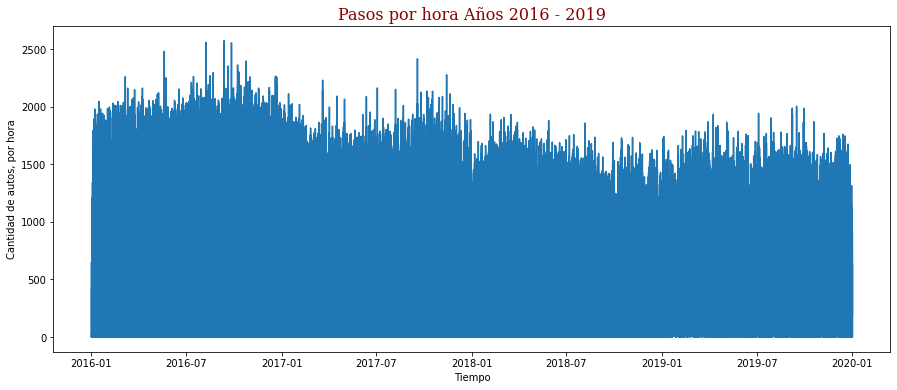

In [ ]:
#Se especifica la fuente que será utilizada en los titulos de las imagenes
font = {'family': 'serif',
        'color':  'darkred',
        'weight': 'normal',
        'size': 16,
        }
#Graficamos nuestros datos, tal como están, desde el 2016 hasta el 2019
plt.figure(figsize = (15,6))
plt.plot(dataset.fecha, dataset.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por hora')
plt.title('Pasos por hora Años 2016 - 2019',fontdict=font)
plt.show()

En esta gráfica se toman todos los datos como estan tal cual, por lo tanto se puede evidenciar que existe una tendencia en los cuatro años, además de lo anterior se observa que a medida que pasa el tiempo siendo más pronnunciado en el segundo semestre del 2018 y e primer semestre del 2019 existe menos cantidad de carroes, en este grafico se estan evaluando tadas las estaciones, las formas de pago, los sentidos y los tipos de vehiculo

In [ ]:
#Resampleamos nuestros datos para agrupar por dia, y asi tal vez lograr una visualización mas amigable
diario = dataset.resample('D', on = 'fecha').sum()
print(diario.shape)
diario.head()

(1461, 1)


cantidad_pasos
fecha                     
2016-01-01           25602
2016-01-02           36136
2016-01-03           37225
2016-01-04           50312
2016-01-05           49907

A continucion graficamos la serie de tiempo total, para tener un vistazo general de toda la serie.

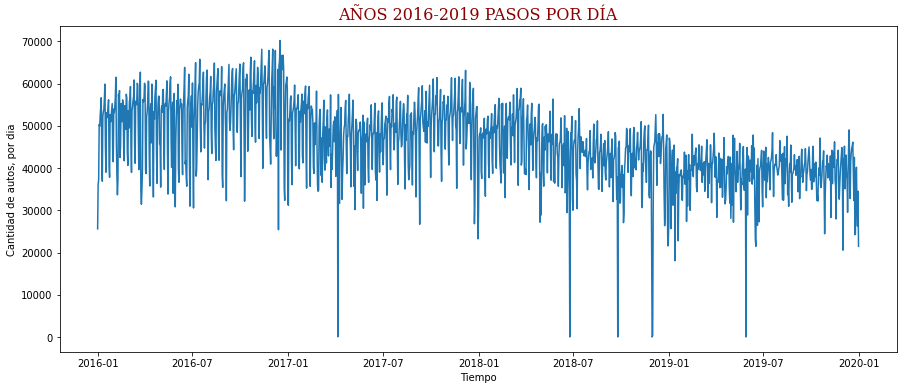

In [ ]:

plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('AÑOS 2016-2019 PASOS POR DÍA', fontdict= font)
plt.show()

Los datos de la linea del tiempo y el intervalo de tiempo son demasiados, por ellos a continuacion pasaremos a hacer un analisis por año de la serie del tiempo.

Auna asi se alcanza a observar un comportamiento general de subidas y bajadas similar entre periodos cortos de tiempo.

A continuacion antes de continuar se debe hacer una comprobacion de si hay fechas faltantes en la serie de tiempo.

In [ ]:
#realizamos la revision 
diario_copy=diario.copy()
diario_diff = diario_copy.copy()  
diario_diff['date']=diario_diff.index                      #metemos las fechas en una columna para poder operarlas
diario_diff['date_check'] = diario_diff.date.diff()        #calculamos la diferencia entre filas consecuentes
print(f'diferencia de dias para la terminal ')
print(diario_diff.date_check.value_counts())                         #contamos cuantos registros hay por diferencia de dias

diferencia de dias para la terminal 
1 days    1460
Name: date_check, dtype: int64


Como se observa no hay fechas faltantes en el dataset, los 1460 dias corresponden a los 4 años.

###Análisis por año

Para hacer una exploración de datos más exhaustiva vamos a realizar un análisis más profundo por cada año, realizando la grafica para cada tipo de vehiculo, para las estaciones y para los sentidos y de esta manera determinar más tendencia que pueda marcar cada año, inicialmente se va a realizar la grafica para todo el año, se verifica tendencia diaria para todo el año, tendencia de cada día de la semana, tendencia por horas del día 

#### Año 2016

En el analisis por año comenzaremos revisando la cantidad de pasos por hora  y por dia de la semana que hay en el peaje.

El mismo analisis y graficas se realizarán para el resto de años para ver la concordancia entre ellos.


(346566, 6)
(107697, 6)


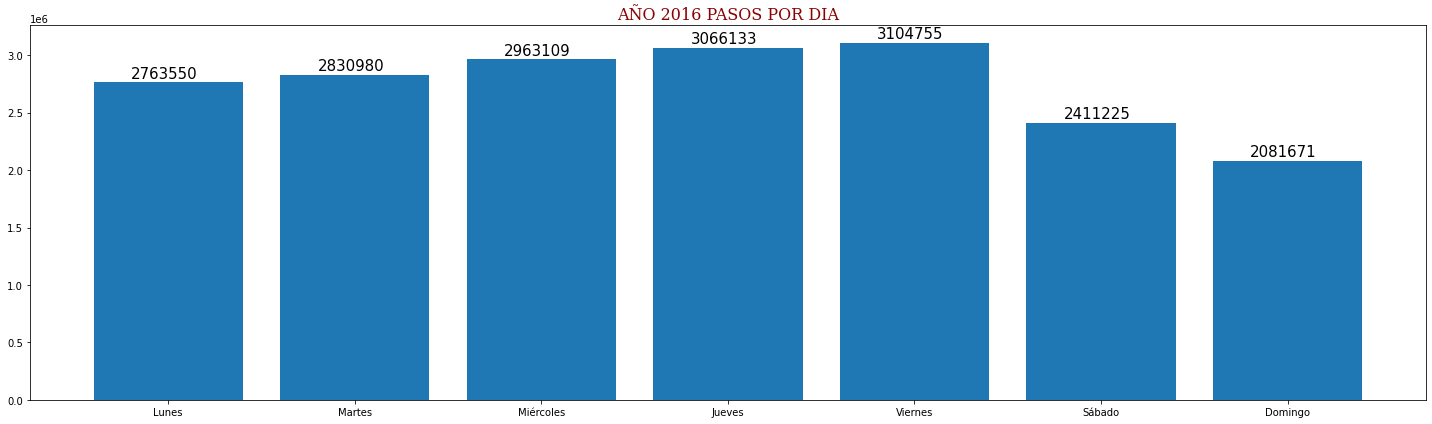

In [ ]:
dataset_copy=dataset_1.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2017-01-01')].shape)
cats = [ 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
cat_type = CategoricalDtype(categories=cats, ordered=True)
dataset_copy['dia'] = dataset_copy['dia'].astype(cat_type)
dataset_copy=dataset_copy[(dataset_copy.fecha < '2017-01-01')].groupby(['dia'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.2 , y =data+40000 , s=f"{data}" , fontdict=dict(fontsize=15))    
plt.title('AÑO 2016 PASOS POR DIA',fontdict=font)
plt.tight_layout()
plt.show()

De la anterior grafica podemos observar que los viernes son los días donde más transitan autos, segudio de los jueves y los miercoles, por otro lado el domingo es el día que menos transitan vehiculos seguido del sabado y el lunes 

(346566, 6)
(107697, 6)


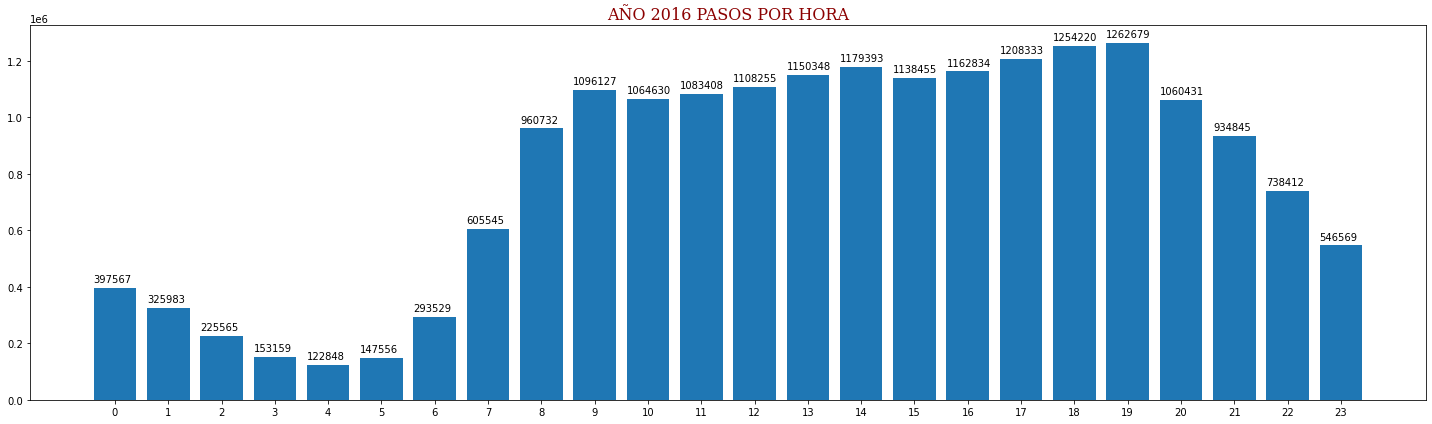

In [ ]:
dataset_copy=dataset_1.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2017-01-01')].shape)
dataset_copy=dataset_copy[(dataset_copy.fecha < '2017-01-01')].groupby(['hora_fin'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.4 , y =data+20000 , s=f"{data}" , fontdict=dict(fontsize=10))    
plt.title('AÑO 2016 PASOS POR HORA',fontdict=font)
plt.xticks(dataset_copy.index)
plt.tight_layout()
plt.show()

El comportamiento es el esperado, la mayor cantidad de pasos se dan entre 5:00 pm y 8:00 pm, mientas que las horas de menos afluencia son entre la 00:00 am y las 7:00 am. Ademas, el jueves y viernes son los dias con afluencia en el punto, mientras que el sabado y el domingo los de menor.

Ahora continuamos viendo la serie de tiempo para el periodo del año 2016, para determinar si hay información relevante de estas fechas. Ademas de esto vamos calcular si hay fechas que tengan datos atipicos para este dataset, esto usando el rango intercuartil como base para determinar los datos atipicos.

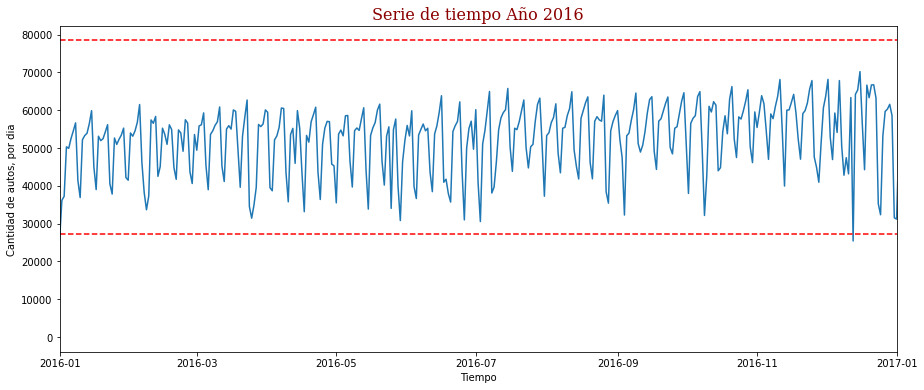

In [ ]:
diario_copy=diario.copy()
diario_quartil = diario_copy[(diario_copy.index < '2017-01-01')].copy()   #filtramos para dejar solo la terminal que queremos ver
q25,q75 =diario_quartil.cantidad_pasos.quantile([0.25,0.75]).values  #Se comienza calculado primer 1er y 3er cuartil
iqr = q75-q25
minimo = q25-1.5*iqr  #Calculamos los maximos y minimos de la distribucion
maximo = q75+1.5*iqr
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,1,1), datetime.date(2017,1,1)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.plot()
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de tiempo Año 2016', fontdict=font)
plt.show()

Como se observa hay una fecha en la cual el dato cruza la linea que nos representa el limite inferior, por lo tanto hay un dato atipico que vamos a revisar a continuación.

In [ ]:
diario_copy=diario.copy()
#A cotininuacion filtramos que las fechas que no estan dentro del rango
fechas= diario_copy[((diario_copy.index > '2016-01-01')&(diario_copy.index < '2017-01-01'))&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))].index
diario.loc[fechas,'cantidad_pasos']

fecha
2016-12-13    25400
Freq: D, Name: cantidad_pasos, dtype: int64

El dato corresponde a la fecha del 13/12/2016, en internet no se encuentra información relevante que nos pueda ayudar a entender el porque de este dato, aun asi, a continuanion vamos corregir el dato atipico, y graficaremos nuevamente que se haya hecho correctamente.

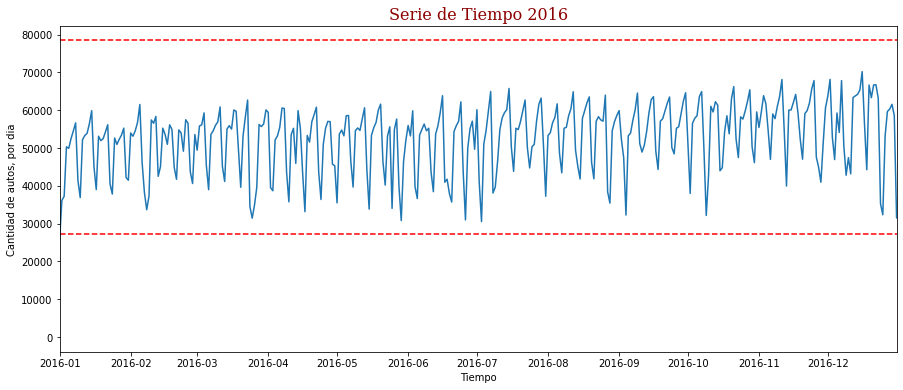

In [ ]:
#primero asignamos el valo de NaN para las fechas con datos atipicos
diario.loc[fechas,'cantidad_pasos']= np.nan
#Luego se hace uso de la herramienta interpolate, para que cacule un punto intermedio entre ambas fechas
diario['cantidad_pasos'] = diario['cantidad_pasos'].interpolate()

#por ultimo graficamos nuevamente que ya no esten presentes los datos atipicos
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,1,1), datetime.date(2016,12,31)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2016', fontdict= font)
plt.show()

A continuación se guardan las estaciones junto con el sentido, para graficar y hacer comparaciones entre años.

In [ ]:
#Sentido
data_centro= data_2016[data_2016.sentido.isin(['Centro'])]
data_provincia= data_2016[data_2016.sentido.isin(['Provincia'])]
#Estaciones
data_Alberti= data_2016[data_2016.estacion.isin(['Alberdi'])]
data_Avellaneda= data_2016[data_2016.estacion.isin(['Avellaneda'])]
data_DellepianeCentro= data_2016[data_2016.estacion.isin(['Dellepiane Centro'])]
data_illia= data_2016[data_2016.estacion.isin(['Illia'])]
data_DellepianeLiniers= data_2016[data_2016.estacion.isin(['Dellepiane Liniers'])]
data_Retiro= data_2016[data_2016.estacion.isin(['Retiro'])]
data_Salguero= data_2016[data_2016.estacion.isin(['Salguero'])]
data_Sarmiento= data_2016[data_2016.estacion.isin(['Sarmiento'])]
#tipo vehiculo
data_liviano= data_2016[data_2016.tipo_vehiculo.isin(['Liviano'])]
data_pesado= data_2016[data_2016.tipo_vehiculo.isin(['Pesado'])]


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


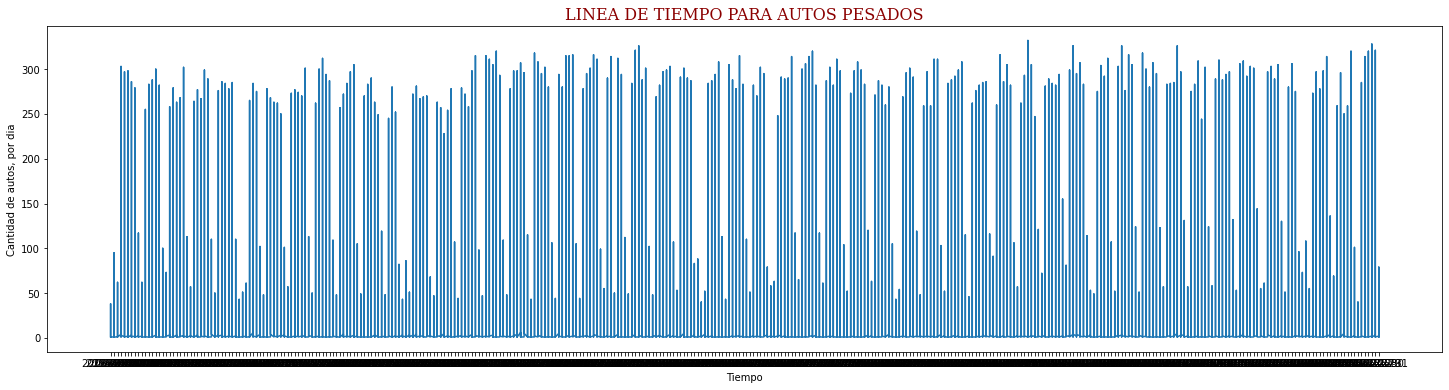

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


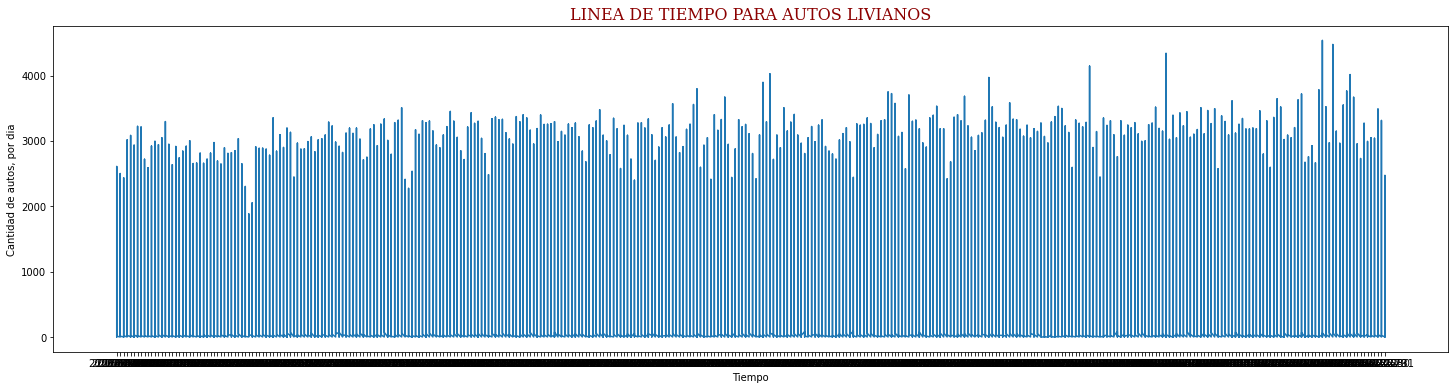

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


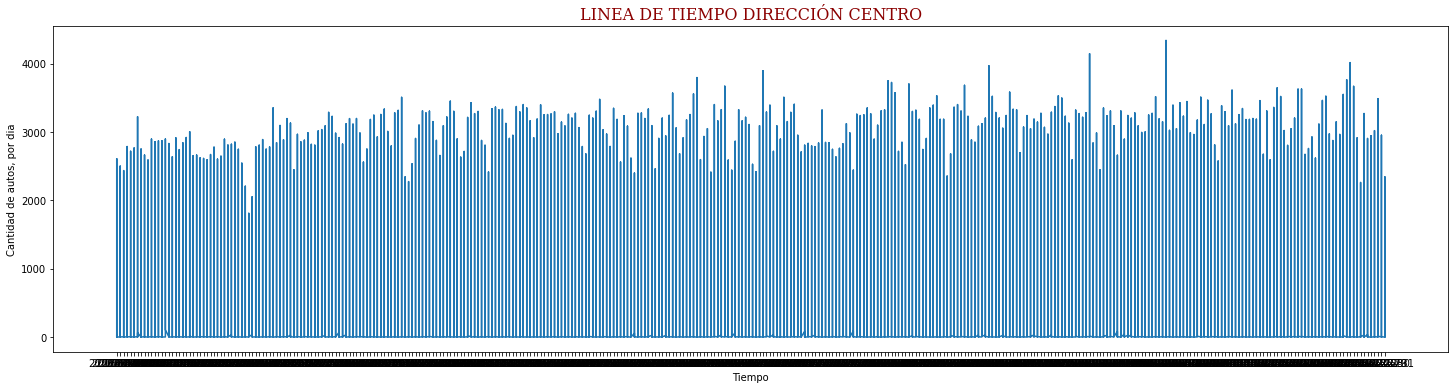

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


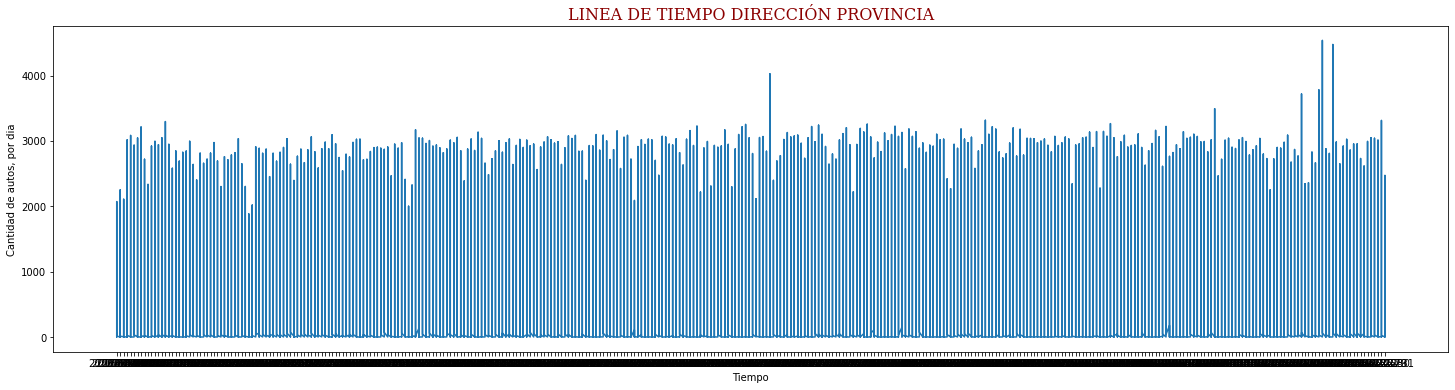

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


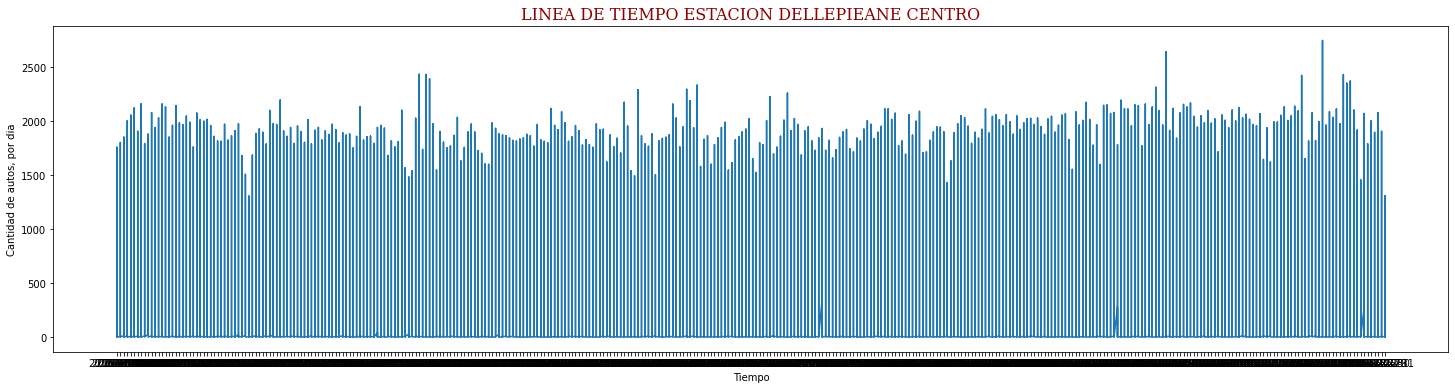

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


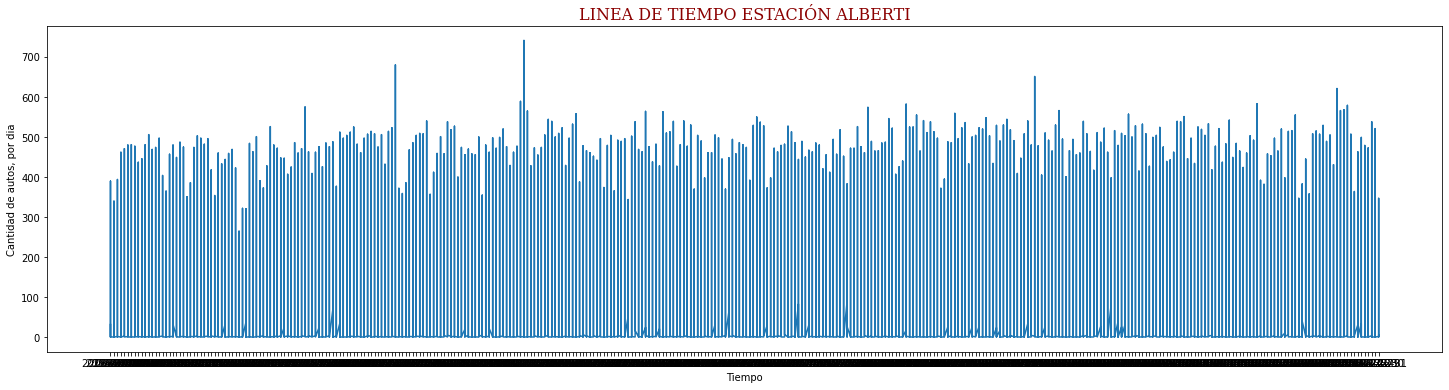

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


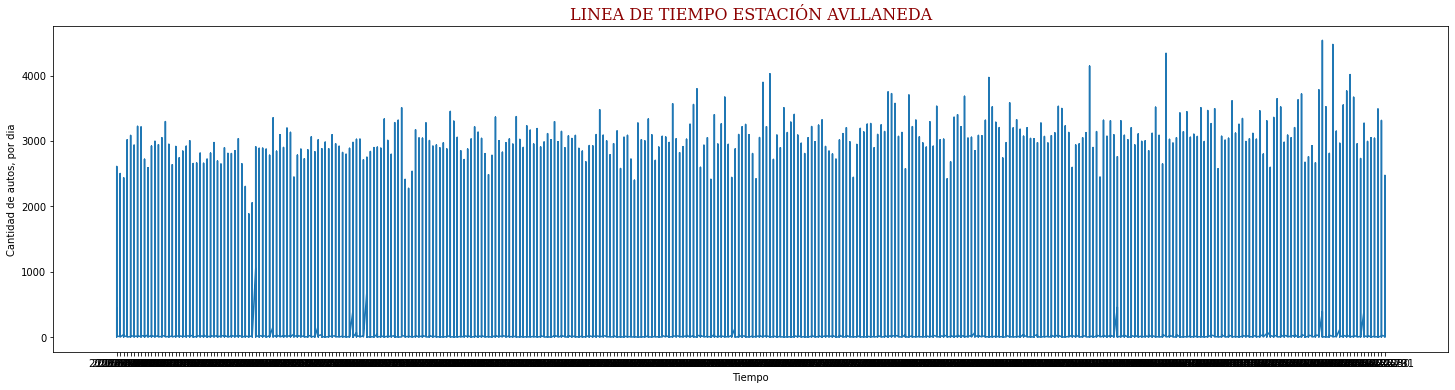

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


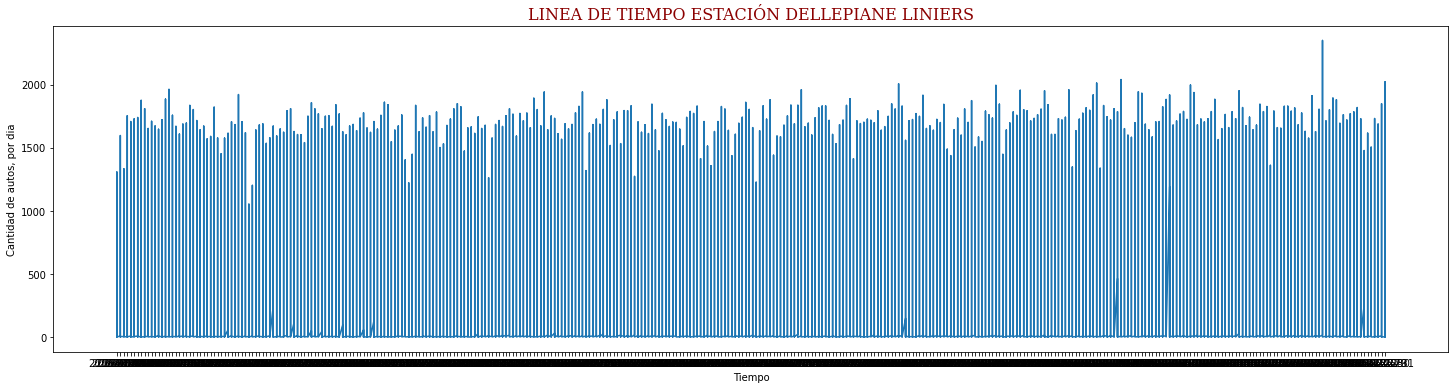

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


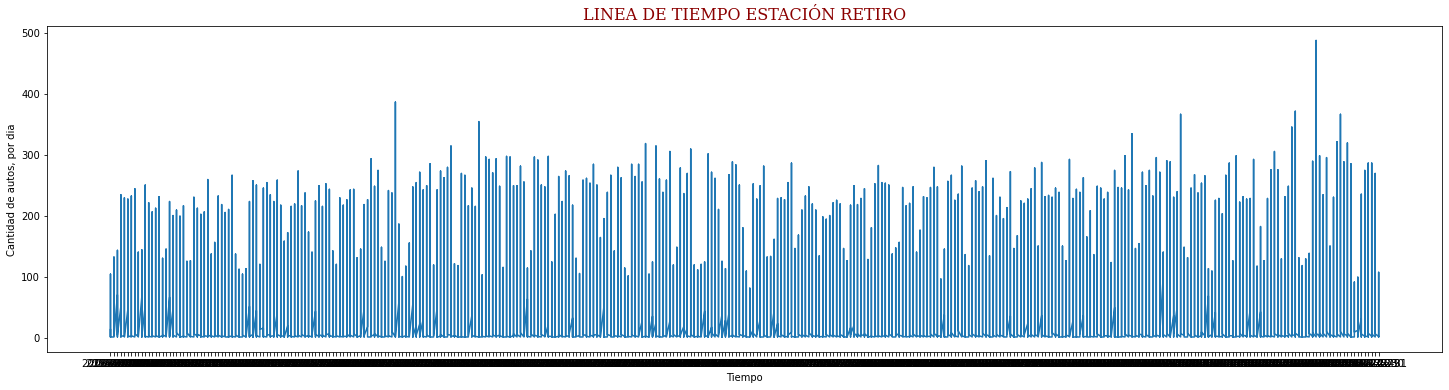

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


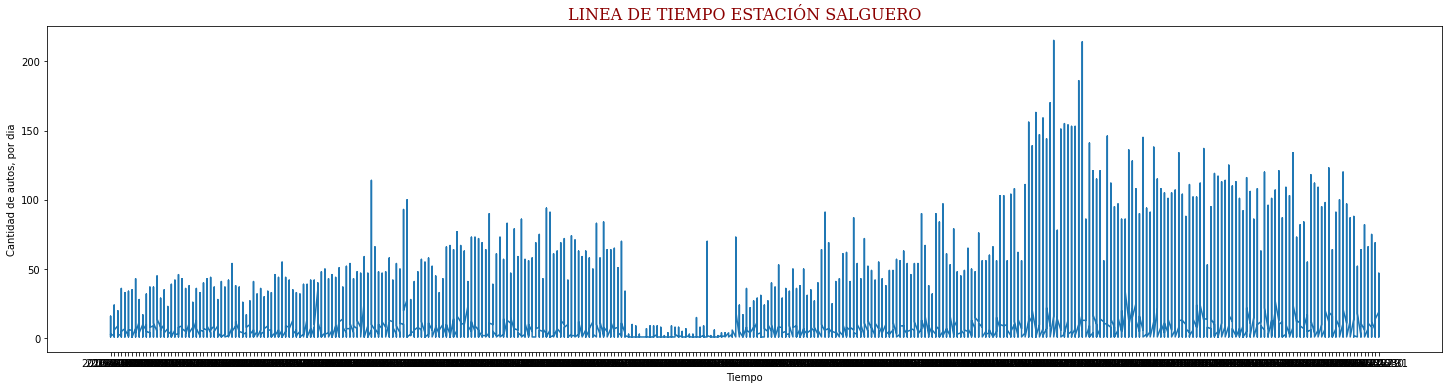

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


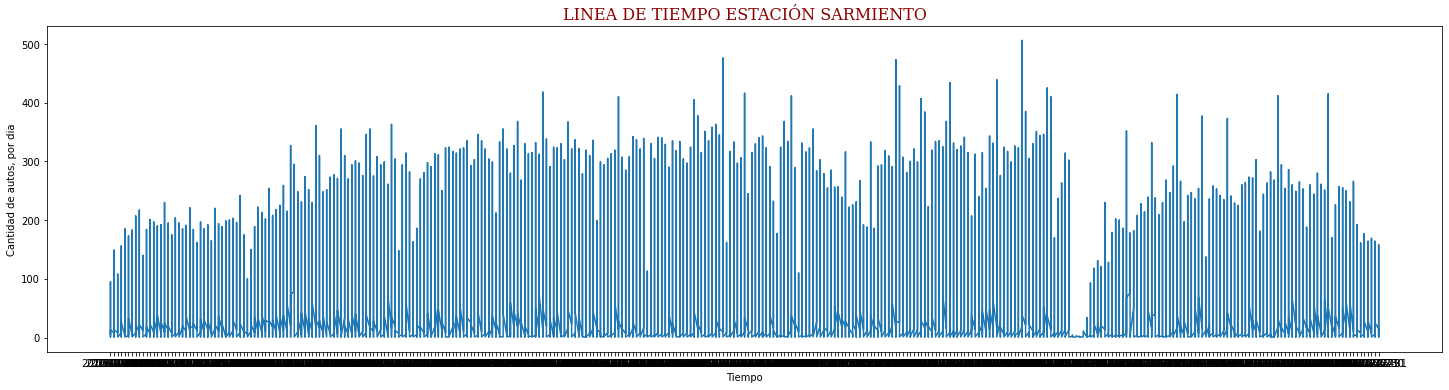

In [ ]:
#tipo vehiculo

plt.figure(figsize = (25,6))
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS PESADOS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_liviano.fecha, data_liviano.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS LIVIANOS', fontdict= font)
plt.show()

#Sentido


plt.figure(figsize = (25,6))
plt.plot(data_centro.fecha, data_centro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_provincia.fecha, data_provincia.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN PROVINCIA', fontdict= font)
plt.show()

#Estaciones

plt.figure(figsize = (25,6))
plt.plot(data_DellepianeCentro.fecha, data_DellepianeCentro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACION DELLEPIEANE CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Alberti.fecha, data_Alberti.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN ALBERTI', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Avellaneda.fecha, data_Avellaneda.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN AVLLANEDA', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_DellepianeLiniers.fecha, data_DellepianeLiniers.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN DELLEPIANE LINIERS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Retiro.fecha, data_Retiro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN RETIRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Salguero.fecha, data_Salguero.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SALGUERO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Sarmiento.fecha, data_Sarmiento.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SARMIENTO', fontdict= font)
plt.show()




De las graficas observamos como hay estaciones con que no parecen tener un patron en su comportamiento, de hecho en la mayoria de casos. Y que por ejemplo los autos livianos son mas constantes en su flujo, en cambio los vehiculos pesados, pasan intermitentemente en grandes cantidades por el peaje.

Al realizar la comparación de los tipos de vehículo observamos que para el 2016 la cantidad de autos diarios no sobrepasa los 400, por otro lado la cantidad de autos livianos es un 90% mas alto que los autos pesados ya que circulan entre 2000 y 4000 autos livianos, en unos casos específicos a final de año sobrepasan los 4000 autos

Para la dirección tanto provincia como centro oa cantidad de autos es similar a excepción de algunos casos que se dan a final de año donde se tienen algunos picos, de esta manera para ambos sentidos la cantidad de autos oscila entre los 2000 y los 5000 vehículos diarios

En términos de las estaciones podemos observar que para la estación dellepiane centro se movilizan promedio 1800 vehículos diariamente, para la estación Alberdi la cantidad de autos oscila entre 300 y 600, por la estación Avellaneda transitan entre 2500 y 4000 vehículos, por la estación dellepiane liniers pasan entre 1000 y 2000 autos diariamente, la estación retiro moviliza entre 100 y 300 vehículos a excepción de un pico al final del año que pasa los 400 vehículos, la estación salguero es por la que menos transitan vehículos ya que en algunas ocasiones no alcanzan a transitar 20 vehículos en todo el día, el promedio de vehículos es aproximadamente 50, por último la estación Sarmiento tiene un paso de vehículos entre 100 y 400 carros con algunas excepciones donde son más de 400 autos los que pasan por dicha estación

A continuacion graficamos para cada trimestre la serie de tiempo, con el objetivo de observar comportamientos o tendencias dentro de la serie.

Text(0.5, 1.0, '4to trimestre')

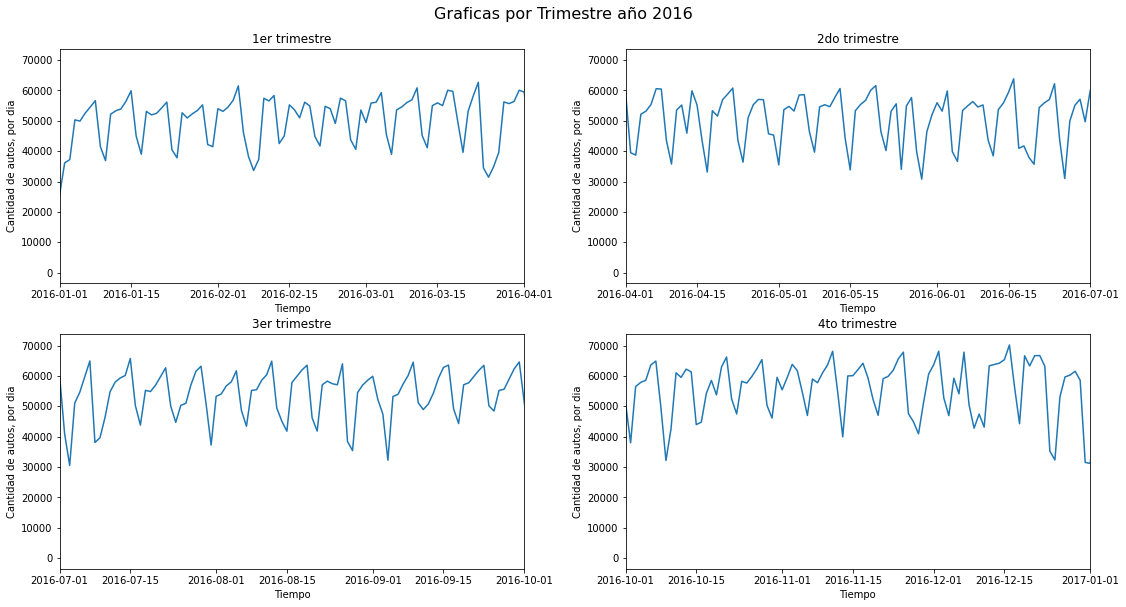

In [ ]:
plt.figure(figsize = (8*2,4*2)) #Primero creamos la figura que va a contener los distintos plots, se va a hacer en una relacion
                                #4:3, y va a ser de 2 filas con 3 plots por fila, por ello, ese tamaño.
plt.suptitle('Graficas por Trimestre año 2016', fontsize=16,y=1.01)  
plt.subplot(2,2,1)              #Generamos un subplot por cada histograma y caja de bigotes a graficar
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,1,1), datetime.date(2016,4,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('1er trimestre')

plt.subplot(2,2,2)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,4,1), datetime.date(2016,7,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('2do trimestre')

plt.tight_layout(pad=2)

plt.subplot(2,2,3)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,7,1), datetime.date(2016,10,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('3er trimestre')

plt.subplot(2,2,4)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,10,1), datetime.date(2017,1,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('4to trimestre')

En lo anterior se observa como el comportamiento es estacional, con respecto a cada semana, se observa como en periodos de 15 dias suele haber dos subidas y dos bajadas.

De lo anterior vamos a observalo mas detalladamente tomando 3 meses, enero, junio y diciembre, para confirmar lo anterior descrito.

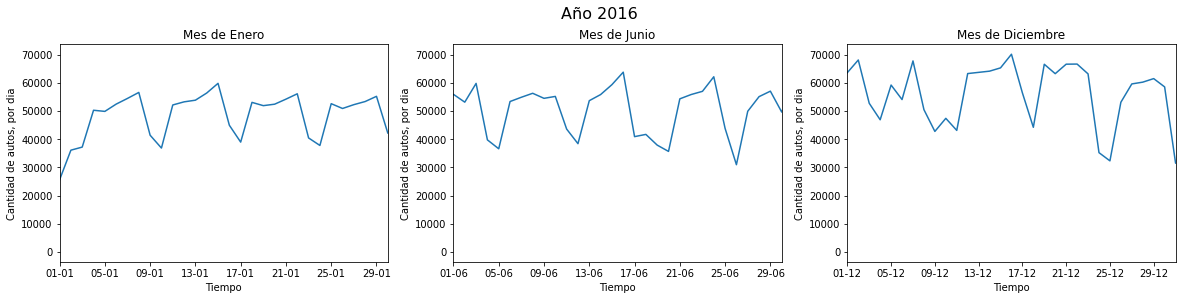

In [ ]:
plt.figure(figsize = (10*2,4)) #Primero creamos la figura que va a contener los distintos plots, se va a hacer en una relacion
                                #4:3, y va a ser de 2 filas con 3 plots por fila, por ello, ese tamaño.
plt.suptitle('Año 2016', fontsize=16,y=1.01)  
plt.subplot(1,3,1)              #Generamos un subplot por cada histograma y caja de bigotes a graficar
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,1,1), datetime.date(2016,1,30)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Mes de Enero')
ax = plt.gca()
formatter = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(formatter)

plt.subplot(1,3,2)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,6,1), datetime.date(2016,6,30)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Mes de Junio')
ax = plt.gca()
formatter = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(formatter)


plt.subplot(1,3,3)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2016,12,1), datetime.date(2016,12,31)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Mes de Diciembre')
ax = plt.gca()
formatter = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(formatter)

Como se observa efectivamente en periodos de 1 mes, se observa claramente las 4 semanas marcadas con comportamiento similar a lo largo de cada mes. Aunqu el mes de diciembre para ser el mas abrupto en sus cambios, tal vez debido a la misma naturaleza de este mes, al ser un mes de festividades y vacaciones.

A continuación graficamos la tendencia, ruido y estacionalidad de la serie de tiempo.

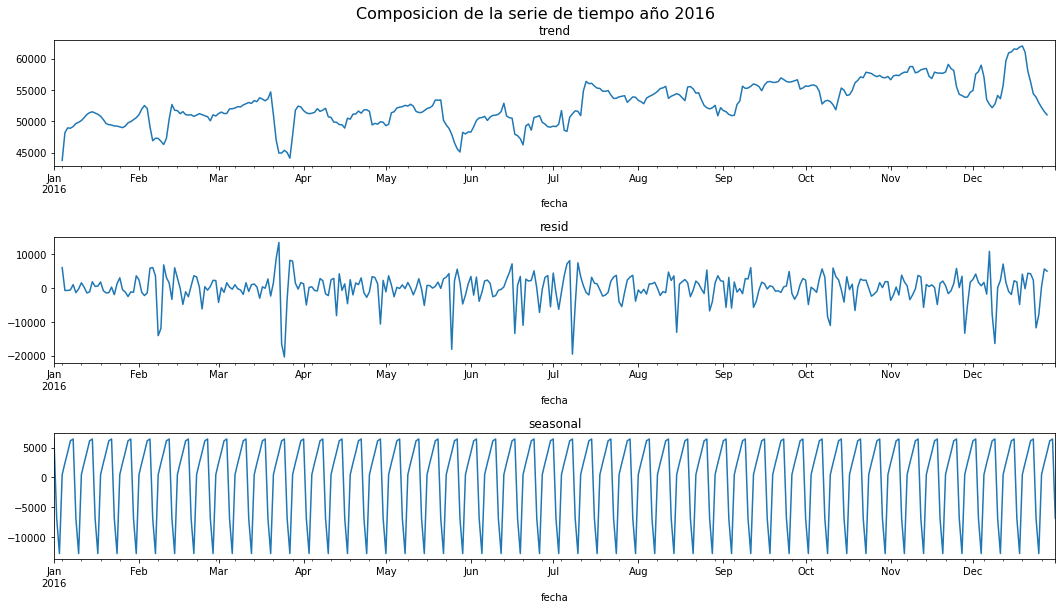

In [ ]:
diario_copy=diario.copy()
res = seasonal_decompose(diario_copy[(diario_copy.index < '2017-01-01')], model='additive')
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
plt.suptitle('Composicion de la serie de tiempo año 2016', fontsize=16,y=1.01)  
res.trend.plot(ax=ax1,title="trend")
plt.tight_layout(pad=1.2)
res.resid.plot(ax=ax2,title="resid")
plt.tight_layout(pad=1.2)
res.seasonal.plot(ax=ax3,title="seasonal")
plt.show()

De acuerdo lo descrito, efectivamente se observa en la estacionalidad como hay 4 picos y caidas, marcando las aproximadas 4 semanas que hay en cada mes.


Posterior a esto se comienza a realizar el mismo procedimiento para cada año. Para observar si se encuentran diferencias o el comportamiento es igual para cada año

#### Año 2017

A partir de acá se hará la misma revisión que en el año 2016, por lo que no se detallará mucho, a excepción de fechas con datos atipicos. Donde si se encuentra información, se hará la respectiva justificación de los datos atipicos ese día.

(346566, 6)
(104230, 6)


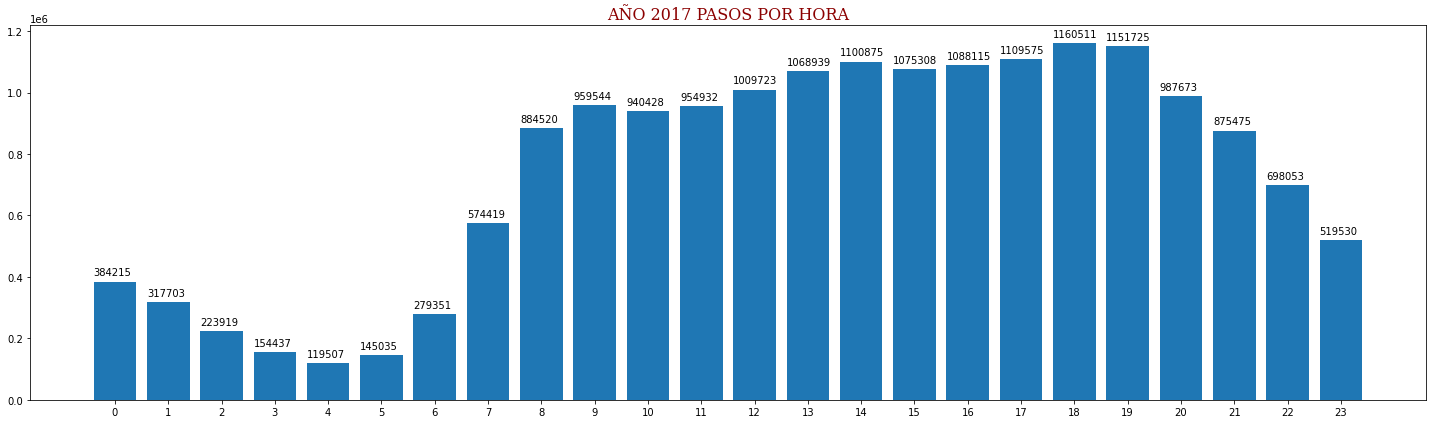

In [ ]:
dataset_copy=dataset_1.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha > '2016-12-31')&(dataset_copy.fecha < '2018-01-01')].shape)
dataset_copy=dataset_copy[(dataset_copy.fecha > '2016-12-31')&(dataset_copy.fecha < '2018-01-01')].groupby(['hora_fin'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.4 , y =data+20000 , s=f"{data}" , fontdict=dict(fontsize=10))    
plt.title('AÑO 2017 PASOS POR HORA', fontdict= font)
plt.xticks(dataset_copy.index)
plt.tight_layout()
plt.show()

Para el caso del 2017 como del 2016 el comportamiento es el esperado, la mayor cantidad de pasos se dan entre 5:00 pm y 8:00 pm, mientas que las horas de menos afluencia son entre la 00:00 am y las 7:00 am. Ademas, el jueves y viernes son los dias con afluencia en el punto, mientras que el sabado y el domingo los de menor.

(346566, 6)
(107697, 6)


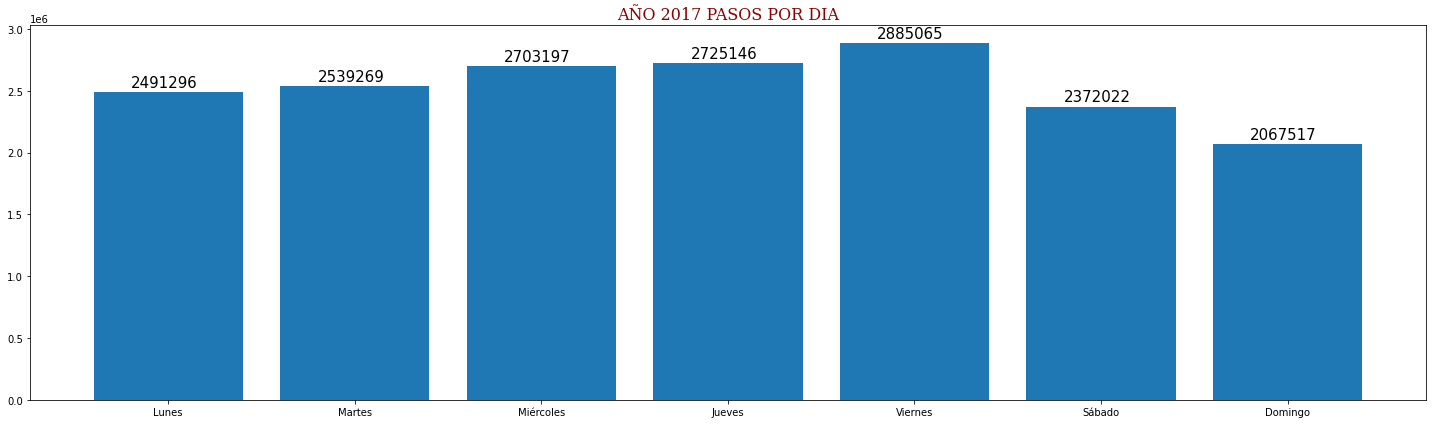

In [ ]:
dataset_copy=dataset_1.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2017-01-01')].shape)
cats = [ 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
cat_type = CategoricalDtype(categories=cats, ordered=True)
dataset_copy['dia'] = dataset_copy['dia'].astype(cat_type)
dataset_copy=dataset_copy[(dataset_copy.fecha > '2016-12-31')&(dataset_copy.fecha < '2018-01-01')].groupby(['dia'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.2 , y =data+40000 , s=f"{data}" , fontdict=dict(fontsize=15))    
plt.title('AÑO 2017 PASOS POR DIA', fontdict= font)
plt.tight_layout()
plt.show()

De la anterior grafica podemos observar que los viernes son los días donde más transitan autos, segudio de los jueves y los miercoles, por otro lado el domingo es el día que menos transitan vehiculos seguido del sabado y el lunes 

Además de lo anterior, continuamos viendo la serie de tiempo para el periodo del año 2016, para determinar si hay información relevante de estas fechas. Ademas de esto vamos calcular si hay fechas que tengan datos atipicos para este dataset, esto usando el rango intercuartil como base para determinar los datos atipicos.

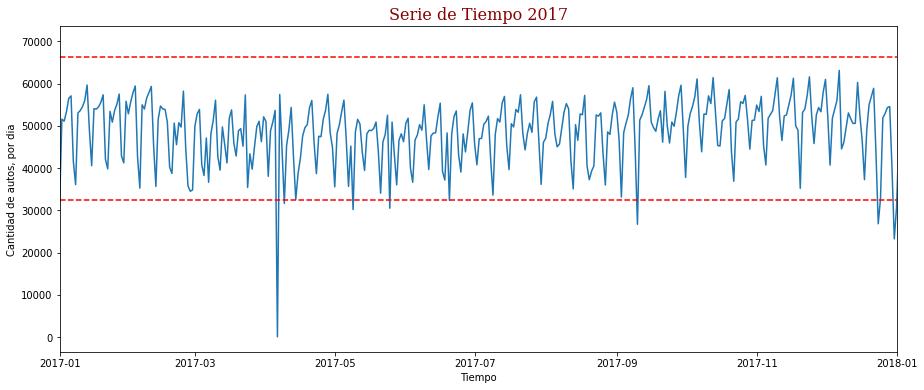

In [ ]:
diario_copy=diario.copy()
diario_quartil = diario_copy[(diario_copy.index > '2016-12-31')&(diario_copy.index < '2018-01-01')].copy()   #filtramos para dejar solo la terminal que queremos ver
q25,q75 =diario_quartil.cantidad_pasos.quantile([0.25,0.75]).values  #Se comienza calculado primer 1er y 3er cuartil
iqr = q75-q25
minimo = q25-1.5*iqr  #Calculamos los maximos y minimos de la distribucion
maximo = q75+1.5*iqr
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,1,1), datetime.date(2018,1,1)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2017', fontdict= font)
plt.show()

Text(0.5, 1.0, '4to trimestre')

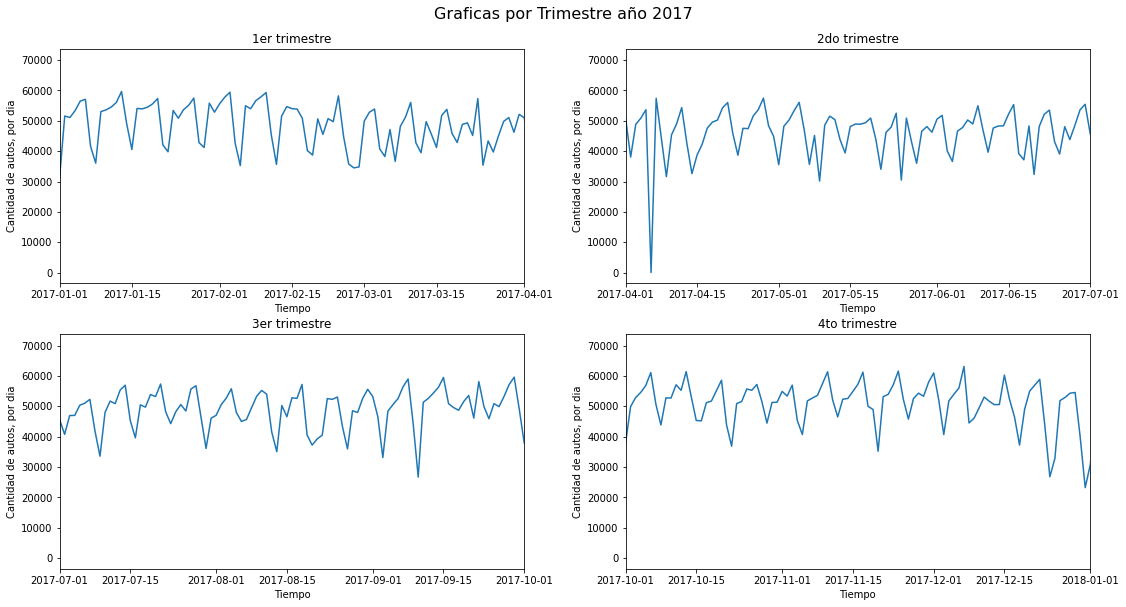

In [ ]:
plt.figure(figsize = (8*2,4*2)) #Primero creamos la figura que va a contener los distintos plots, se va a hacer en una relacion
                                #4:3, y va a ser de 2 filas con 3 plots por fila, por ello, ese tamaño.
plt.suptitle('Graficas por Trimestre año 2017', fontsize=16,y=1.01)  
plt.subplot(2,2,1)              #Generamos un subplot por cada histograma y caja de bigotes a graficar
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,1,1), datetime.date(2017,4,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('1er trimestre')

plt.subplot(2,2,2)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,4,1), datetime.date(2017,7,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('2do trimestre')

plt.tight_layout(pad=2)

plt.subplot(2,2,3)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,7,1), datetime.date(2017,10,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('3er trimestre')

plt.subplot(2,2,4)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,10,1), datetime.date(2018,1,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('4to trimestre')

Como se puede observar hay un caida abrupta en la cantidad de autos que pasan en la fecha del **06/04/2017**, si se investiga que sucedio en este dia, se encuentra que fue un dia de huelgas y fuertes protestas en Argentina, lo que explica porque esta caida abrupta, vamos a observar con detenemiento exactamente en cuanto fue la caida a continuación. 

In [ ]:
diario_copy=diario.copy()
diario_copy[(diario_copy.index > '2016-12-31')&(diario_copy.index < '2018-01-01')&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))]
fechas= diario_copy[(diario_copy.index > '2016-12-31')&(diario_copy.index < '2018-01-01')&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))].index

diario.loc[fechas,'cantidad_pasos']

fecha
2017-01-01    31183.0
2017-04-06       40.0
2017-04-09    31615.0
2017-05-09    30152.0
2017-05-25    30479.0
2017-06-20    32336.0
2017-09-10    26684.0
2017-12-24    26805.0
2017-12-31    23229.0
Name: cantidad_pasos, dtype: float64

Como se observa la caida es muy grande pasa de un valor de 53655 a 40, y luego retoma un valor de 57419. Este valor atipico será corregido a continuación y observaremos el nuevo valor obtenido

In [ ]:
diario.loc[fechas,'cantidad_pasos']= np.nan
diario['cantidad_pasos'] = diario['cantidad_pasos'].interpolate()



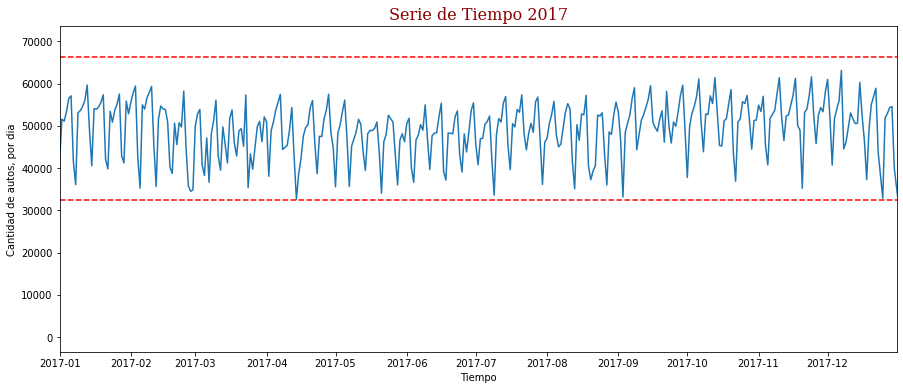

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,1,1), datetime.date(2017,12,31)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2017', fontdict= font)
plt.show()

Ahora que ya se ha corregido el valor atipico, procedemos a graficar nuevamente para el año 2017, observar si ya no se presentan más valores atipicos. Observando el grafico nos podemos dar cuenta que ya no tenemosmás valores atipicos y la cantidad de autos para 2017 oscila entre los 30000 y los 65000 autos al día


Al observar lo anterior se decide graficar el paso de los autos individualmente para ver su tendencia, por tal momotivo se van a graficar los sentidos, las estaciones y el tipo de vehiculo para poder mirar si existe alguna tendencia en dichas segmentaciones 

In [ ]:
#Sentido
data_centro= data_2017[data_2017.sentido.isin(['Centro'])]
data_provincia= data_2017[data_2017.sentido.isin(['Provincia'])]
#Estaciones
data_Alberti= data_2017[data_2017.estacion.isin(['Alberdi'])]
data_Avellaneda= data_2017[data_2017.estacion.isin(['Avellaneda'])]
data_DellepianeCentro= data_2017[data_2017.estacion.isin(['Dellepiane Centro'])]
data_illia= data_2017[data_2017.estacion.isin(['Illia'])]
data_DellepianeLiniers= data_2017[data_2017.estacion.isin(['Dellepiane Liniers'])]
data_Retiro= data_2017[data_2017.estacion.isin(['Retiro'])]
data_Salguero= data_2017[data_2017.estacion.isin(['Salguero'])]
data_Sarmiento= data_2017[data_2017.estacion.isin(['Sarmiento'])]
#tipo vehiculo
data_liviano= data_2017[data_2017.tipo_vehiculo.isin(['Liviano'])]
data_pesado= data_2017[data_2017.tipo_vehiculo.isin(['Pesado'])]


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


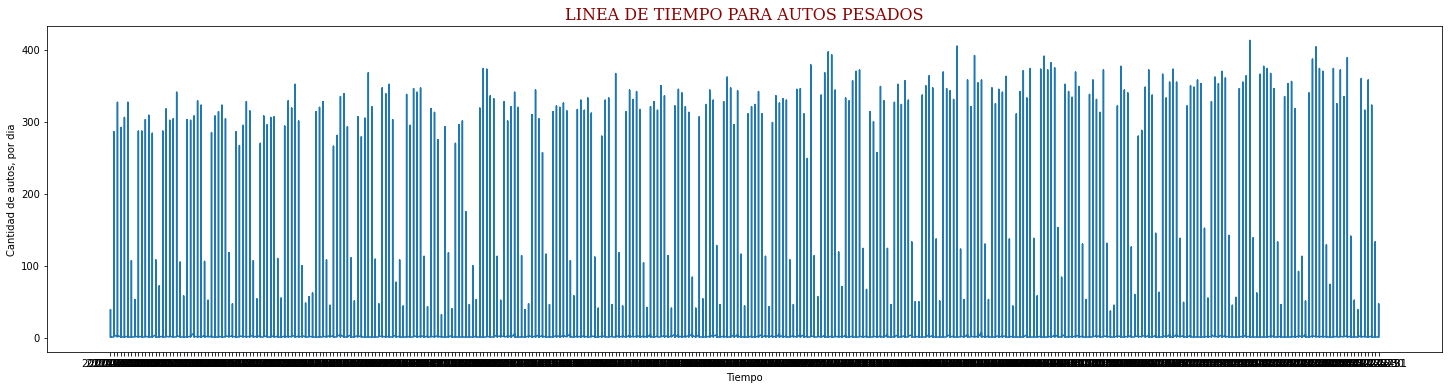

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


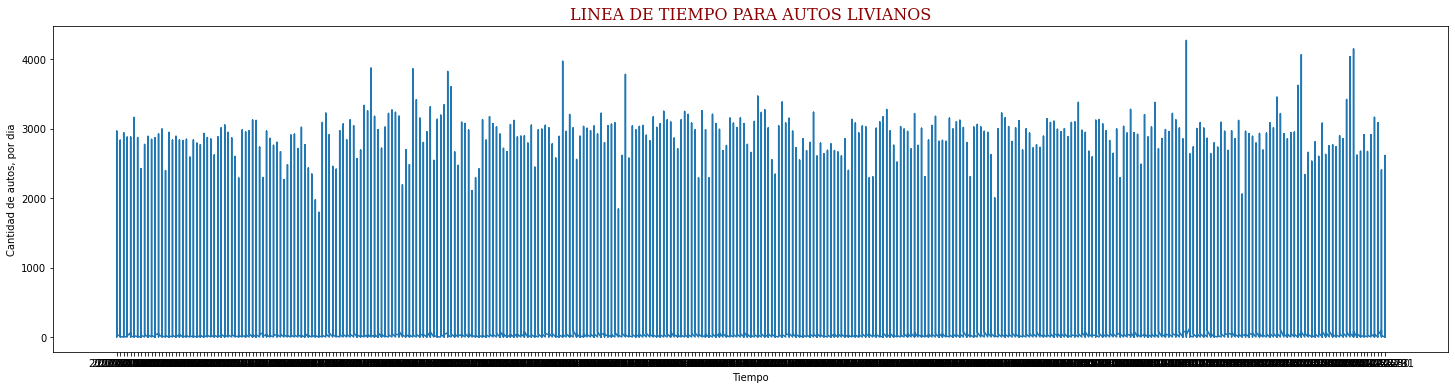

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


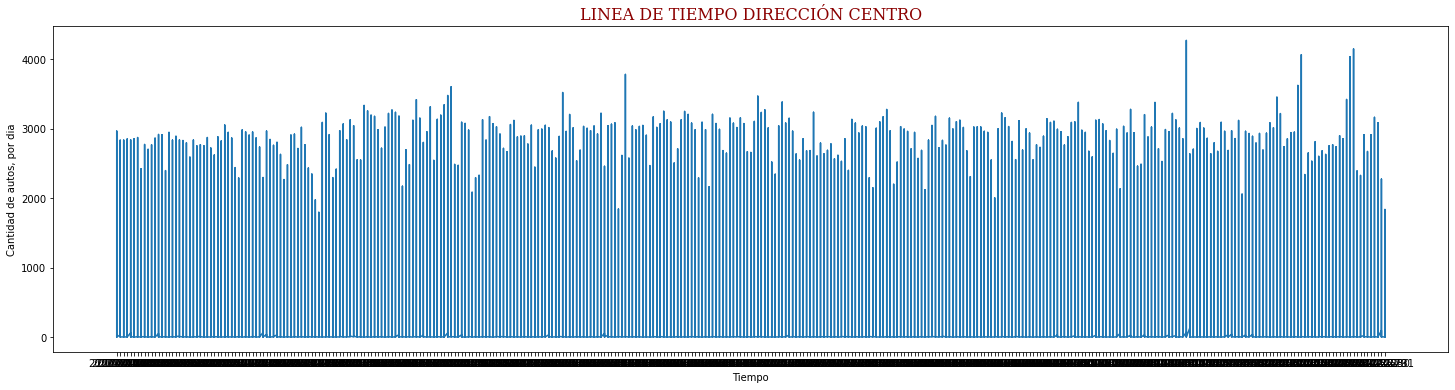

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


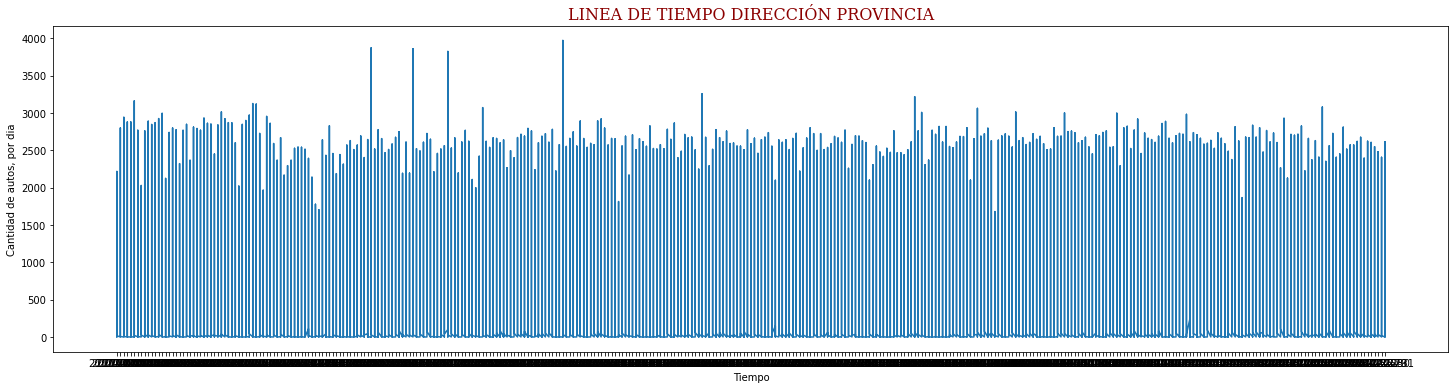

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


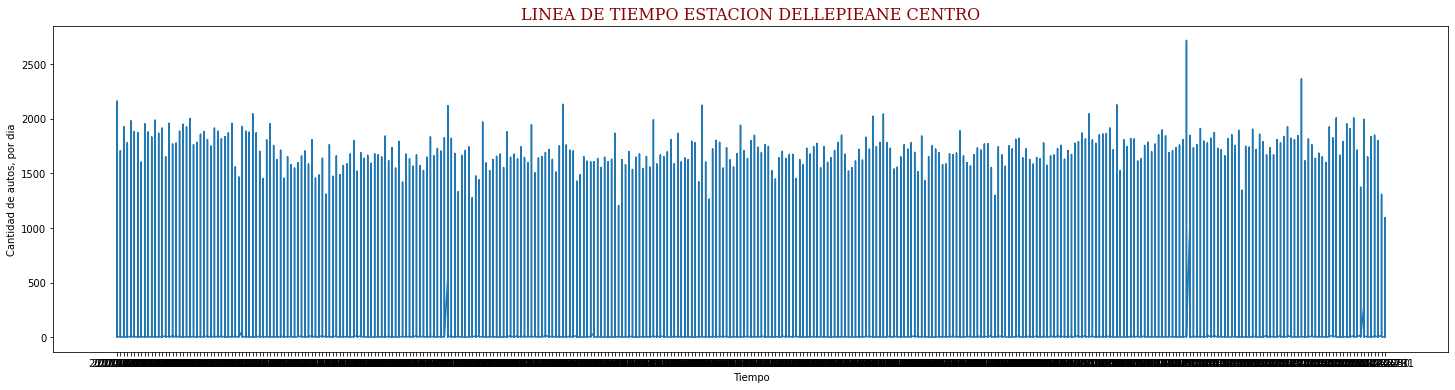

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


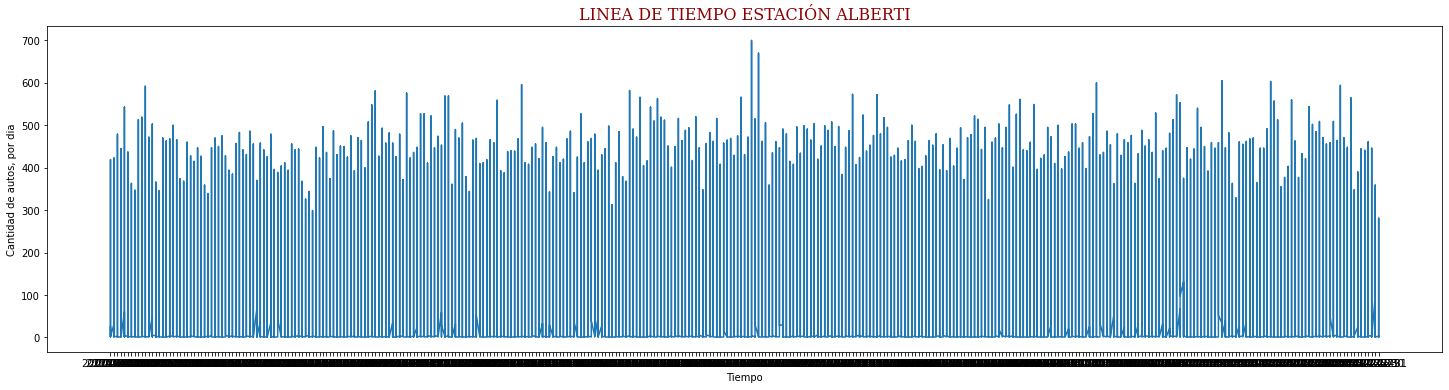

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


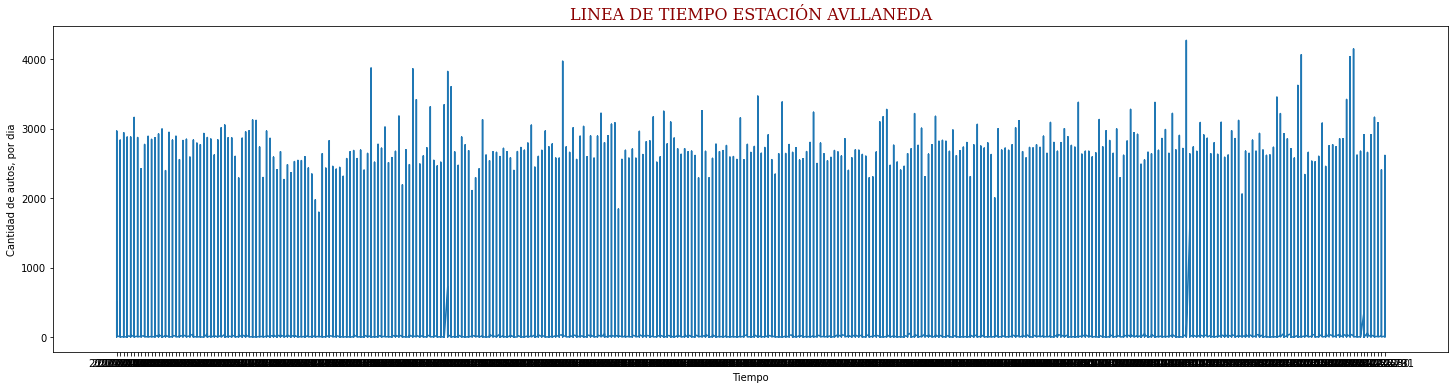

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


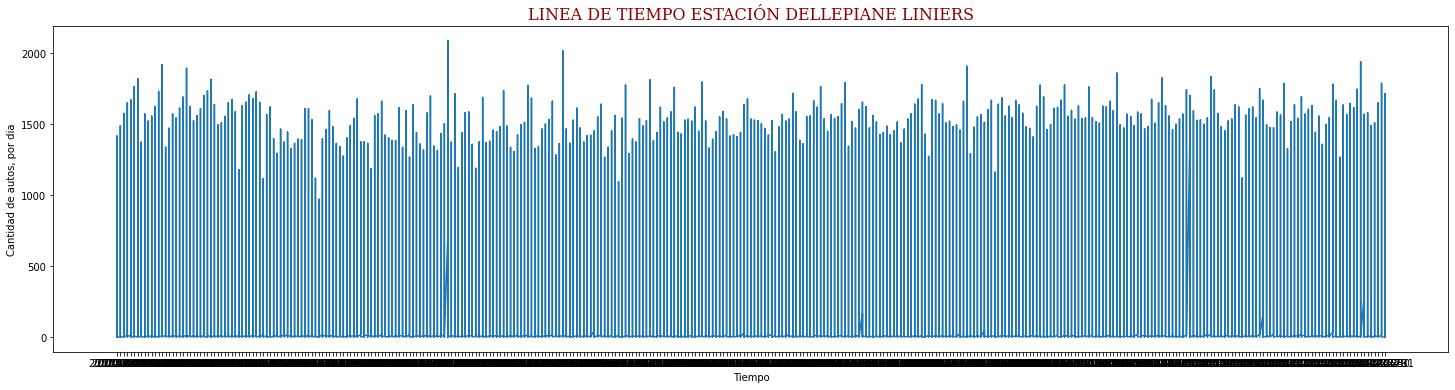

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


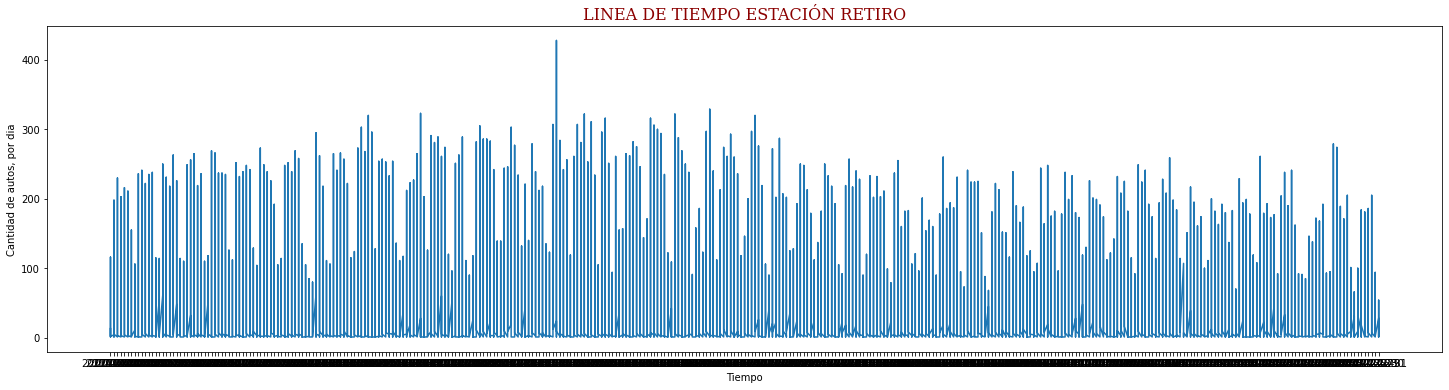

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


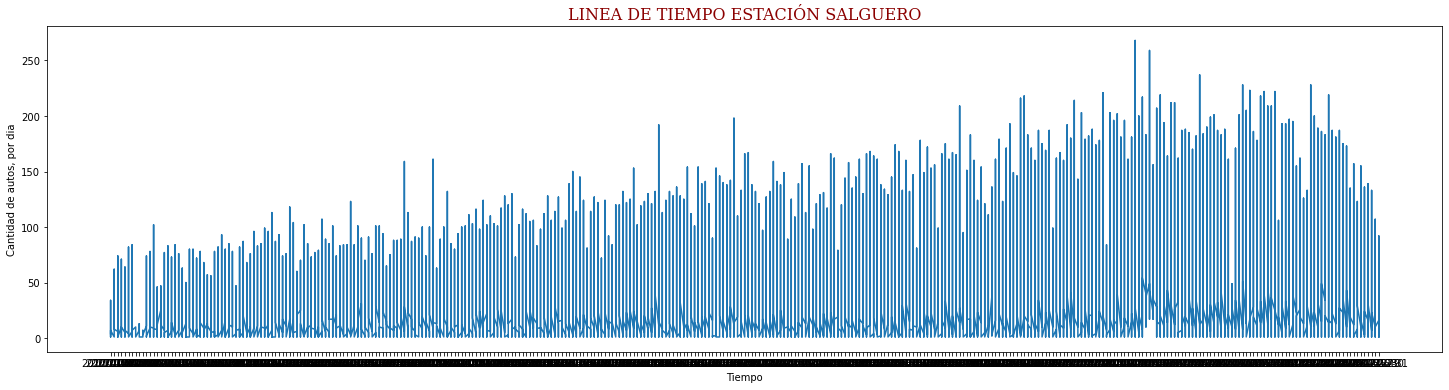

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


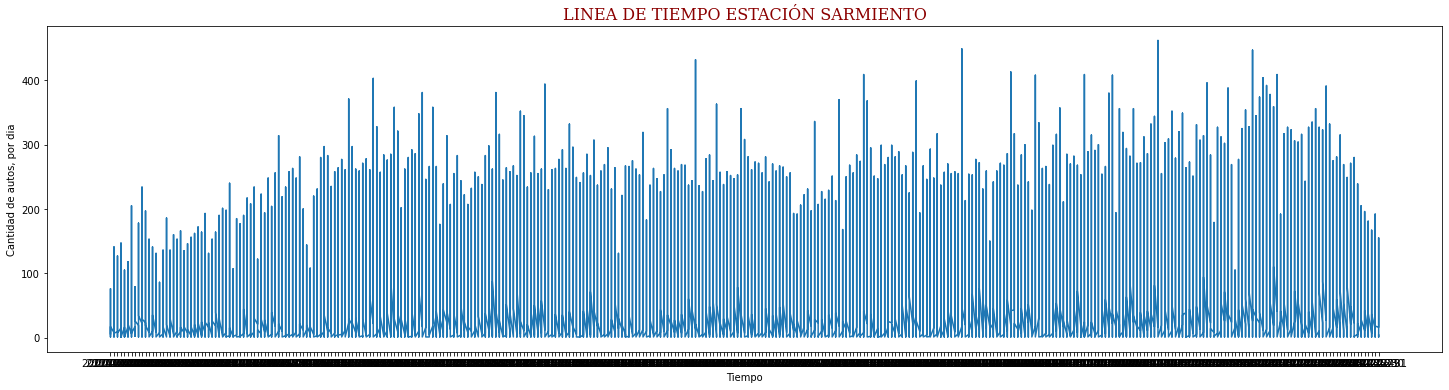

In [ ]:
#tipo vehiculo

plt.figure(figsize = (25,6))
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS PESADOS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_liviano.fecha, data_liviano.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS LIVIANOS', fontdict= font)
plt.show()

#Sentido


plt.figure(figsize = (25,6))
plt.plot(data_centro.fecha, data_centro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_provincia.fecha, data_provincia.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN PROVINCIA', fontdict= font)
plt.show()

#Estaciones

plt.figure(figsize = (25,6))
plt.plot(data_DellepianeCentro.fecha, data_DellepianeCentro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACION DELLEPIEANE CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Alberti.fecha, data_Alberti.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN ALBERTI', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Avellaneda.fecha, data_Avellaneda.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN AVLLANEDA', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_DellepianeLiniers.fecha, data_DellepianeLiniers.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN DELLEPIANE LINIERS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Retiro.fecha, data_Retiro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN RETIRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Salguero.fecha, data_Salguero.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SALGUERO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Sarmiento.fecha, data_Sarmiento.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SARMIENTO', fontdict= font)
plt.show()




Para el caso del 2017 la tendencia del 2016 se mantinie a excepción de la estación salguero ya que Al realizar la comparación de los tipos de vehículo observamos que para el 2016 la cantidad de autos diarios no sobrepasa los 400, por otro lado la cantidad de autos livianos es un 90% mas alto que los autos pesados ya que circulan entre 2000 y 4000 autos livianos, en unos casos específicos a final de año sobrepasan los 4000 autos

Para la dirección tanto provincia como centro oa cantidad de autos es similar a excepción de algunos casos que se dan a final de año donde se tienen algunos picos, de esta manera para ambos sentidos la cantidad de autos oscila entre los 2000 y los 5000 vehículos diarios

En términos de las estaciones podemos observar que para la estación dellepiane centro se movilizan promedio 1800 vehículos diariamente, para la estación Alberdi la cantidad de autos oscila entre 300 y 600, por la estación Avellaneda transitan entre 2500 y 4000 vehículos, por la estación dellepiane liniers pasan entre 1000 y 2000 autos diariamente, la estación retiro moviliza entre 100 y 300 vehículos a excepción de un pico al final del año que pasa los 400 vehículos, la estación salguero es por la que menos transitan vehículos ya que en algunas ocasiones no alcanzan a transitar 20 vehículos y más o menos hasta la mitad del año la cantidad de autos es en promedio de 100 en todo el día, el promedio de vehículos es aproximadamente 50, por último la estación Sarmiento tiene un paso de vehículos entre 100 y 400 carros con algunas excepciones donde son más de 400 autos los que pasan por dicha estación

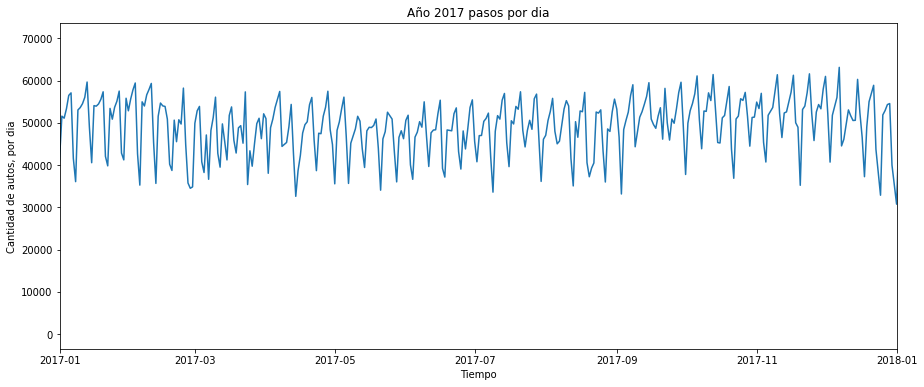

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,1,1), datetime.date(2018,1,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Año 2017 pasos por dia')
plt.show()

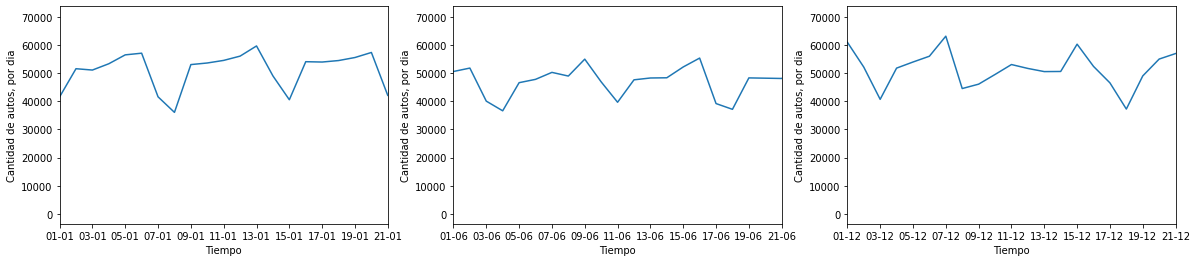

In [ ]:
plt.figure(figsize = (10*2,4)) #Primero creamos la figura que va a contener los distintos plots, se va a hacer en una relacion
                                #4:3, y va a ser de 2 filas con 3 plots por fila, por ello, ese tamaño.
  
plt.subplot(1,3,1)              #Generamos un subplot por cada histograma y caja de bigotes a graficar
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,1,1), datetime.date(2017,1,21)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
ax = plt.gca()
formatter = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(formatter)

plt.subplot(1,3,2)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,6,1), datetime.date(2017,6,21)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
ax = plt.gca()
formatter = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(formatter)


plt.subplot(1,3,3)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2017,12,1), datetime.date(2017,12,21)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
ax = plt.gca()
formatter = mdates.DateFormatter("%d-%m")
ax.xaxis.set_major_formatter(formatter)

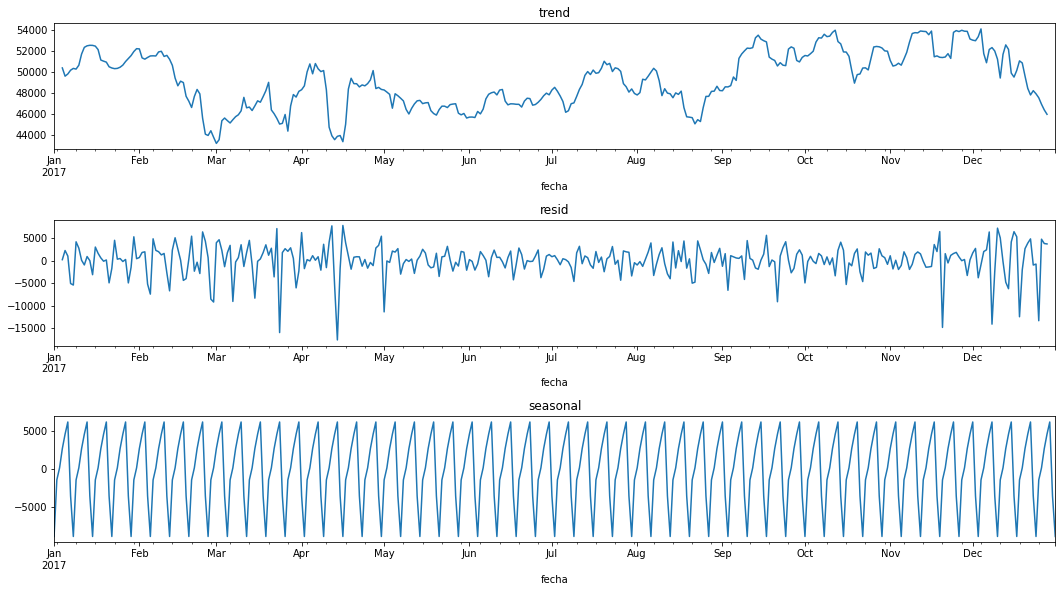

In [ ]:
diario_copy=diario.copy()
#diario_copy=diario_copy[(diario_copy.index > '2016-12-31')&(diario_copy.index < '2018-01-01')]
res = seasonal_decompose(diario_copy[(diario_copy.index > '2016-12-31')&(diario_copy.index < '2018-01-01')], model='additive')
#plt.figure(figsize = (15,6))
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,title="trend")
plt.tight_layout(pad=1.2)
res.resid.plot(ax=ax2,title="resid")
plt.tight_layout(pad=1.2)
res.seasonal.plot(ax=ax3,title="seasonal")
plt.show()

#### Año 2018

In [ ]:
data_2018.describe()

periodo   hora_inicio      hora_fin  cantidad_pasos
count  1375908.0  1.375908e+06  1.375908e+06    1.375908e+06
mean      2018.0  1.198040e+01  1.211807e+01    8.946361e+01
std          0.0  6.538943e+00  6.610977e+00    2.910907e+02
min       2018.0  0.000000e+00  0.000000e+00    1.000000e+00
25%       2018.0  7.000000e+00  7.000000e+00    2.000000e+00
50%       2018.0  1.200000e+01  1.200000e+01    6.000000e+00
75%       2018.0  1.700000e+01  1.800000e+01    2.600000e+01
max       2018.0  2.300000e+01  2.300000e+01    5.722000e+03

In [ ]:
data_2018.isna().sum()

periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64

In [ ]:
data_2018['fecha2'] = pd.to_datetime(data_2018.fecha) + pd.to_timedelta(data_2018.hora_fin, unit = 'h')

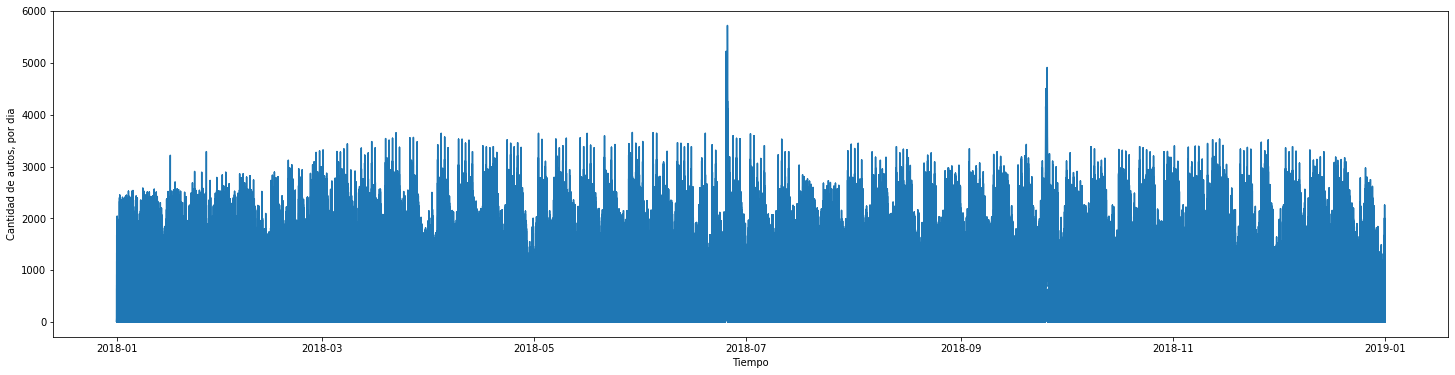

In [ ]:
plt.figure(figsize = (25,6))
plt.plot(data_2018.fecha2, data_2018.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [ ]:
#Sentido
data_centro= data_2018[data_2018.sentido.isin(['Centro'])]
data_provincia= data_2018[data_2018.sentido.isin(['Provincia'])]
#Estaciones
data_Alberti= data_2018[data_2018.estacion.isin(['Alberdi'])]
data_Avellaneda= data_2018[data_2018.estacion.isin(['Avellaneda'])]
data_DellepianeCentro= data_2018[data_2018.estacion.isin(['Dellepiane Centro'])]
data_illia= data_2018[data_2018.estacion.isin(['Illia'])]
data_DellepianeLiniers= data_2018[data_2018.estacion.isin(['Dellepiane Liniers'])]
data_Retiro= data_2018[data_2018.estacion.isin(['Retiro'])]
data_Salguero= data_2018[data_2018.estacion.isin(['Salguero'])]
data_Sarmiento= data_2018[data_2018.estacion.isin(['Sarmiento'])]
#tipo vehiculo
data_liviano= data_2018[data_2018.tipo_vehiculo.isin(['Liviano'])]
data_pesado= data_2018[data_2018.tipo_vehiculo.isin(['Pesado'])]


INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


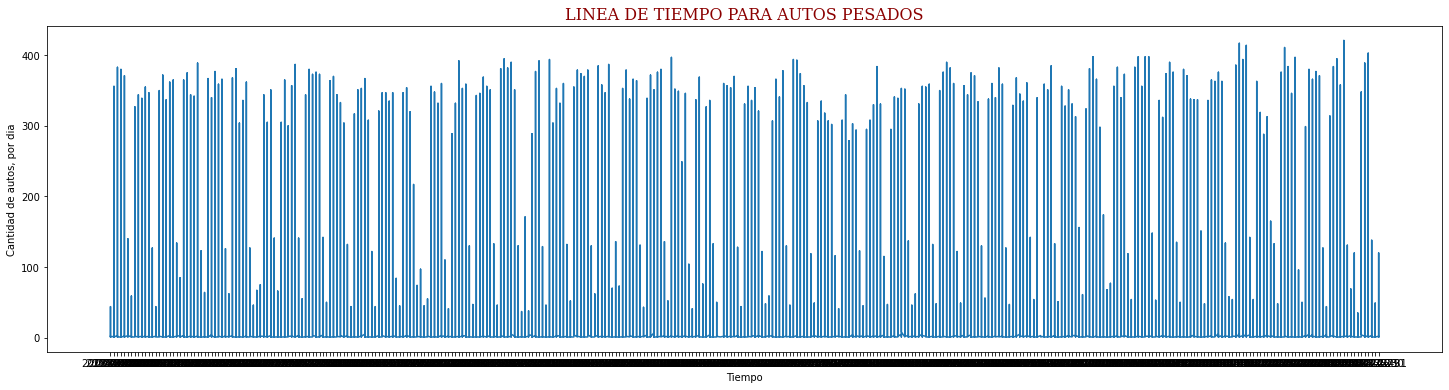

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


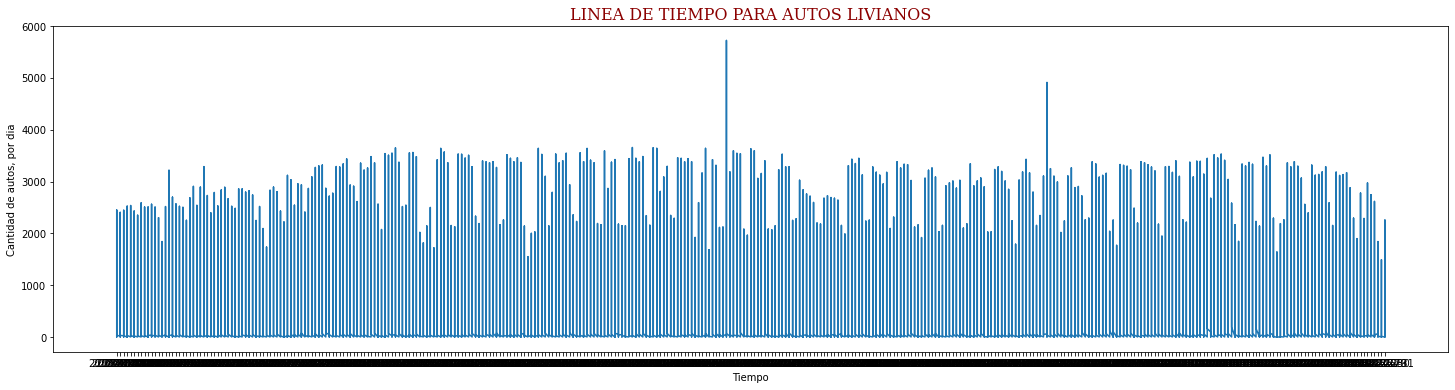

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


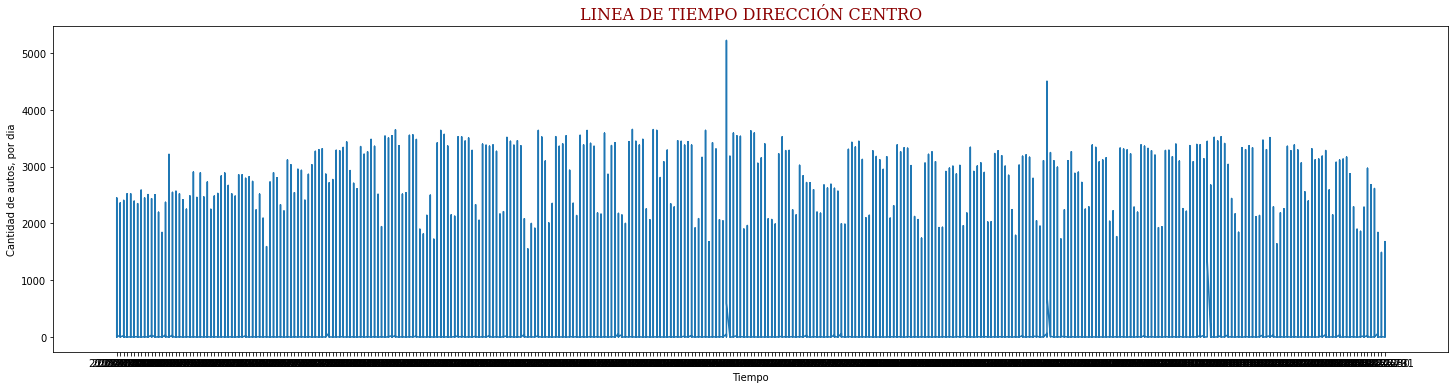

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


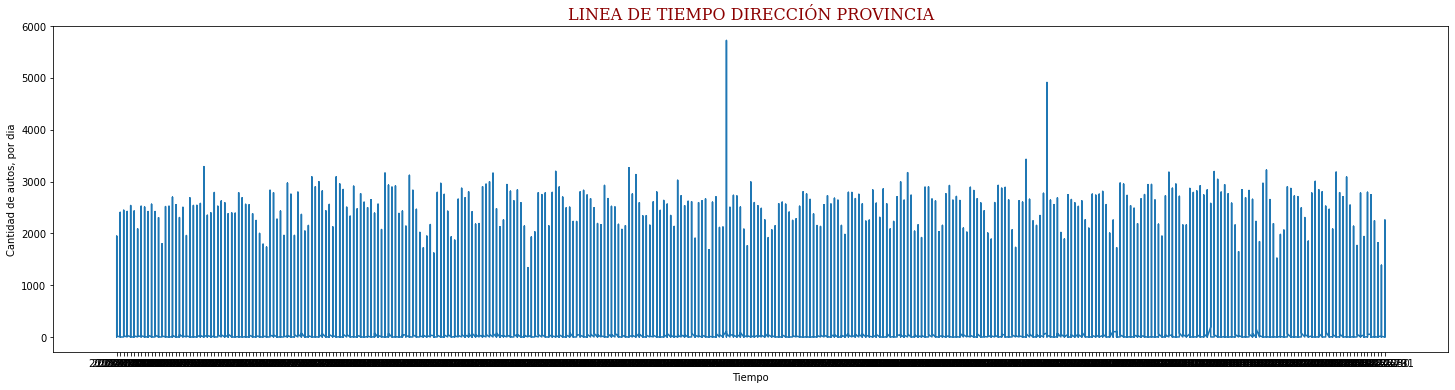

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


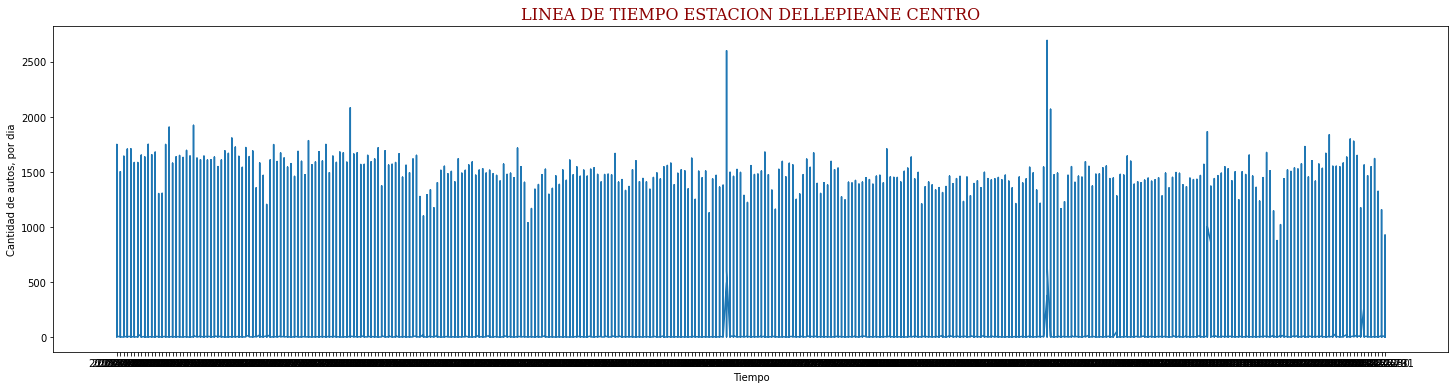

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


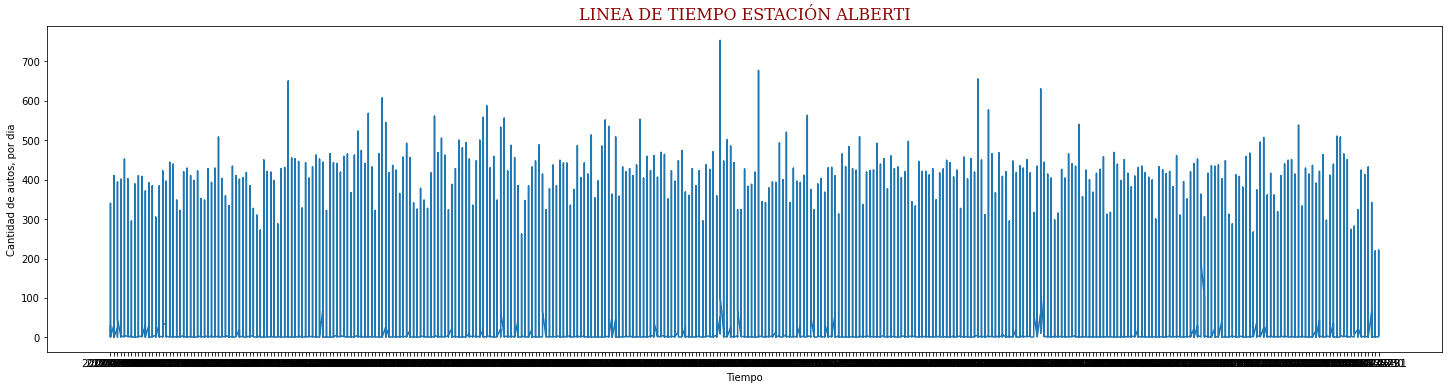

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


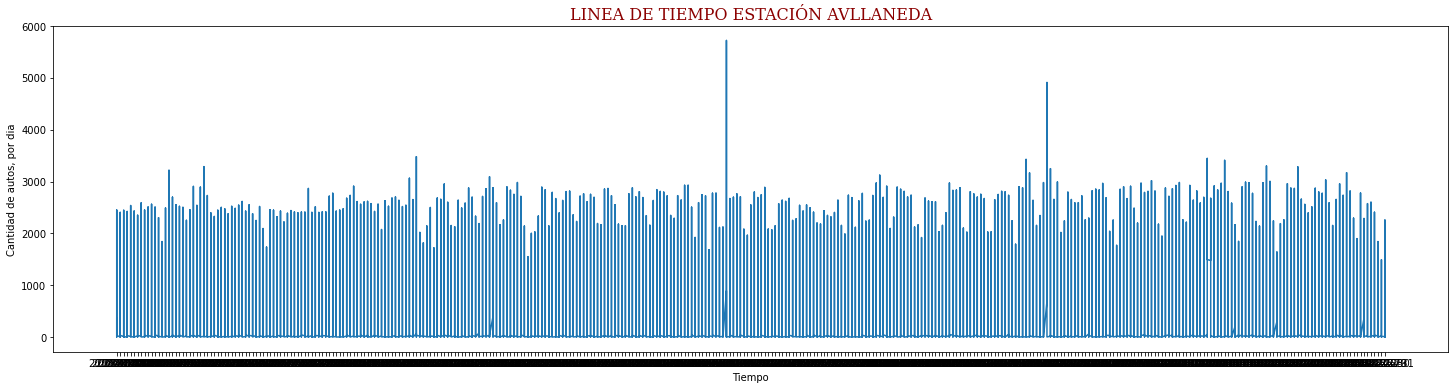

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


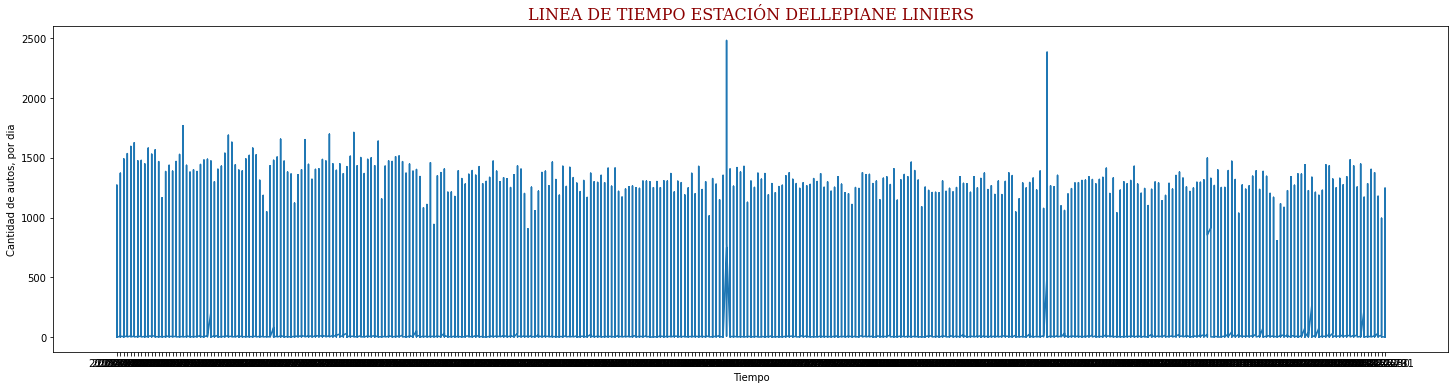

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


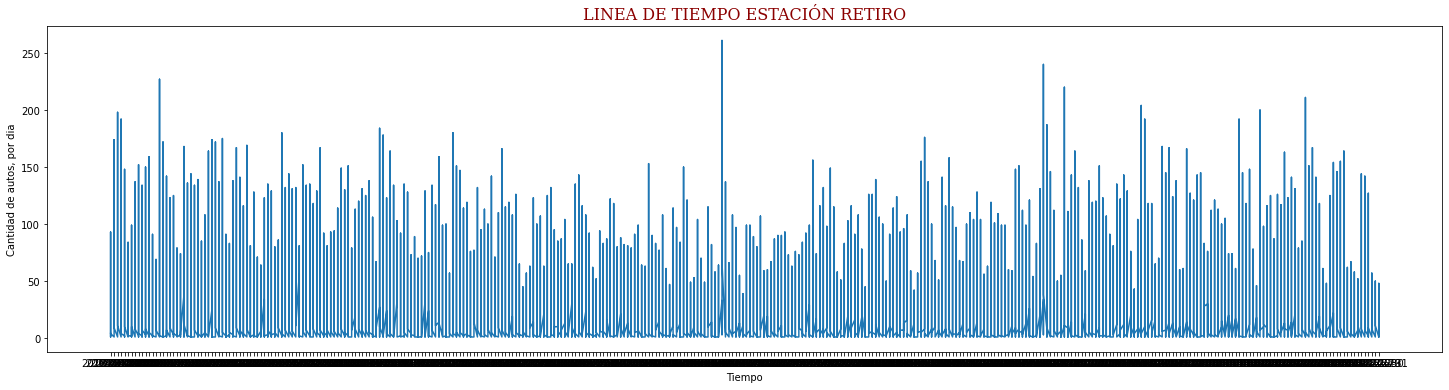

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


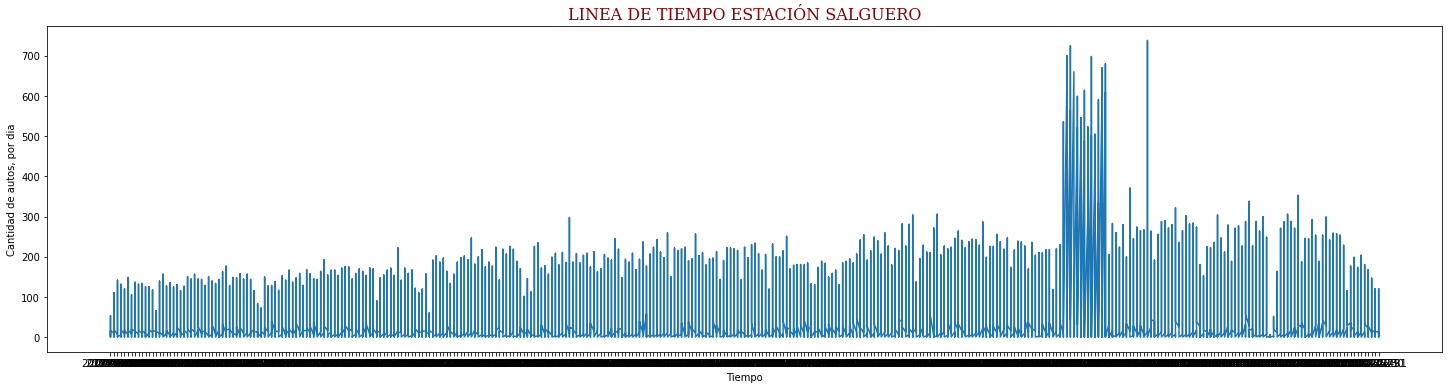

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


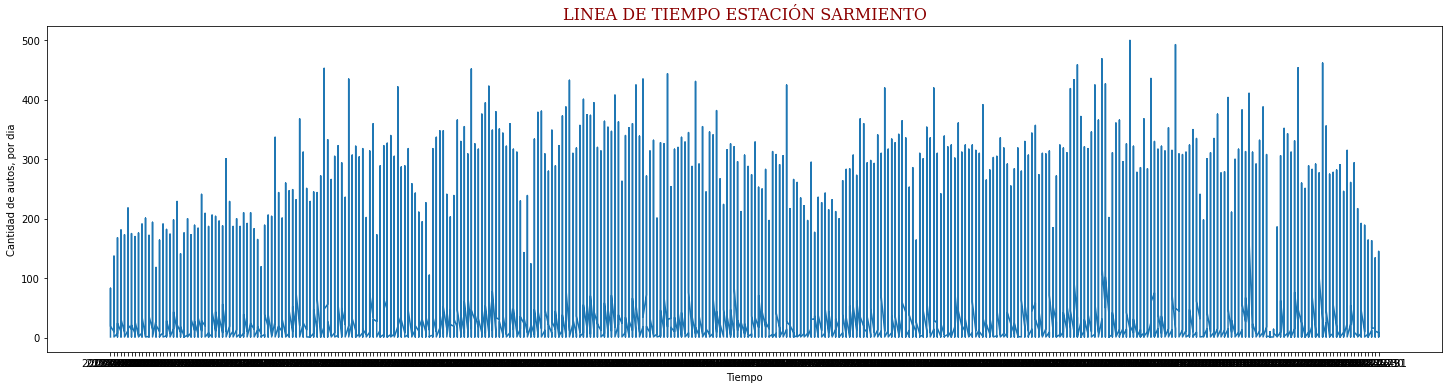

In [ ]:
#tipo vehiculo

plt.figure(figsize = (25,6))
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS PESADOS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_liviano.fecha, data_liviano.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS LIVIANOS', fontdict= font)
plt.show()

#Sentido


plt.figure(figsize = (25,6))
plt.plot(data_centro.fecha, data_centro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_provincia.fecha, data_provincia.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN PROVINCIA', fontdict= font)
plt.show()

#Estaciones

plt.figure(figsize = (25,6))
plt.plot(data_DellepianeCentro.fecha, data_DellepianeCentro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACION DELLEPIEANE CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Alberti.fecha, data_Alberti.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN ALBERTI', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Avellaneda.fecha, data_Avellaneda.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN AVLLANEDA', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_DellepianeLiniers.fecha, data_DellepianeLiniers.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN DELLEPIANE LINIERS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Retiro.fecha, data_Retiro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN RETIRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Salguero.fecha, data_Salguero.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SALGUERO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Sarmiento.fecha, data_Sarmiento.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SARMIENTO', fontdict= font)
plt.show()

Para el analisis del 2018 podemos observar que Al realizar la comparación de los tipos de vehículo observamos que para el 2016 la cantidad de autos diarios no sobrepasa los 400, por otro lado la cantidad de autos livianos es un 90% mas alto que los autos pesados ya que circulan entre 2000 y 4000 autos livianos, en unos casos específicos a final de año sobrepasan los 4000 autos

Para la dirección tanto provincia como centro oa cantidad de autos es similar a excepción de algunos casos que se dan a final de año donde se tienen algunos picos, de esta manera para ambos sentidos la cantidad de autos oscila entre los 2000 y los 5000 vehículos diarios

En términos de las estaciones podemos observar que para la estación dellepiane centro se movilizan promedio 1800 vehículos diariamente, para la estación Alberdi la cantidad de autos oscila entre 300 y 600, por la estación Avellaneda transitan entre 2500 y 4000 vehículos, por la estación dellepiane liniers pasan entre 1000 y 2000 autos diariamente, la estación retiro moviliza entre 100 y 300 vehículos a excepción de un pico al final del año que pasa los 400 vehículos, la estación salguero es por la que menos transitan vehículos ya que en algunas ocasiones no alcanzan a transitar 20 vehículos en todo el día, aunque se debe observar que el segundo semestre en un lapso de tiempo pequeño la cantidad de autos creció deaproximadamente 200 hasta 00 autos diarios, por último la estación Sarmiento tiene un paso de vehículos entre 100 y 400 carros con algunas excepciones donde son más de 400 autos los que pasan por dicha estación

(1375908, 11)
(1375908, 11)


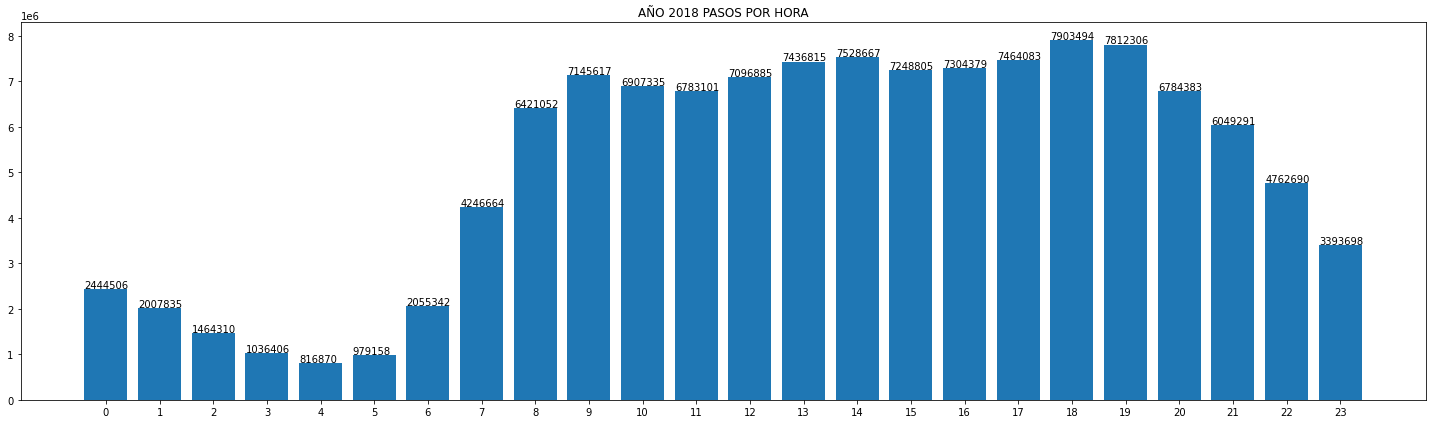

In [ ]:
dataset_copy=data_2018.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2019-01-01')].shape)
dataset_copy=dataset_copy[(dataset_copy.fecha < '2019-01-01')].groupby(['hora_fin'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.4 , y =data+20000 , s=f"{data}" , fontdict=dict(fontsize=10))    
plt.title('AÑO 2018 PASOS POR HORA')
plt.xticks(dataset_copy.index)
plt.tight_layout()
plt.show()

Para este año se mantiene la tedencia y se tiene que El comportamiento es el esperado, la mayor cantidad de pasos se dan entre 5:00 pm y 8:00 pm, mientas que las horas de menos afluencia son entre la 00:00 am y las 7:00 am. Ademas, el jueves y viernes son los dias con afluencia en el punto, mientras que el sabado y el domingo los de menor.

Ahora continuamos viendo la serie de tiempo para el periodo del año 2016, para determinar si hay información relevante de estas fechas. Ademas de esto vamos calcular si hay fechas que tengan datos atipicos para este dataset, esto usando el rango intercuartil como base para determinar los datos atipicos.

(346566, 5)
(211927, 5)


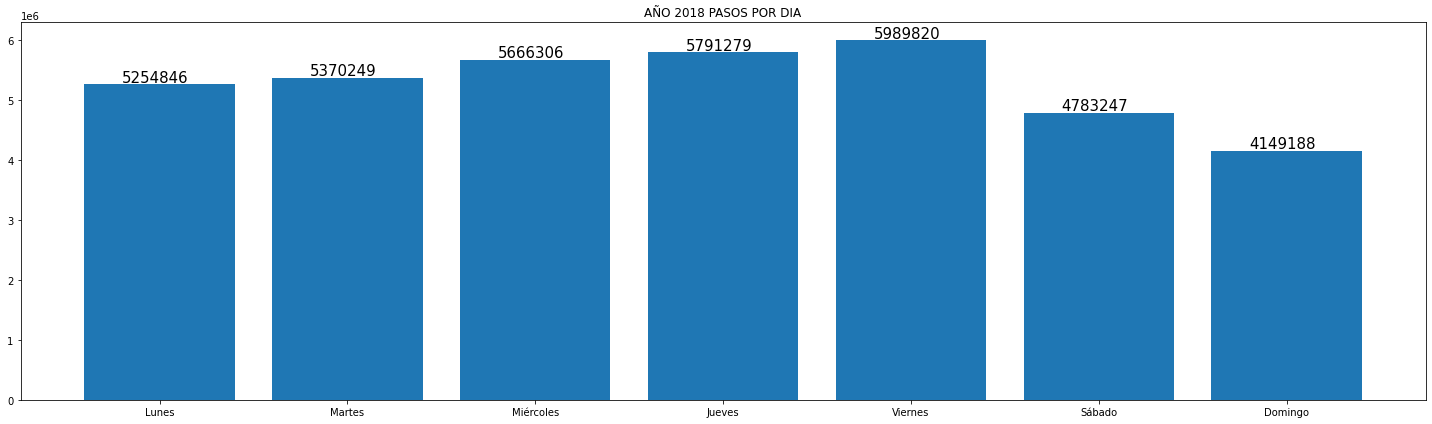

In [ ]:
dataset_copy=dataset.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2018-01-01')].shape)
cats = [ 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
cat_type = CategoricalDtype(categories=cats, ordered=True)
dataset_copy['dia'] = dataset_copy['dia'].astype(cat_type)
dataset_copy=dataset_copy[(dataset_copy.fecha < '2018-01-01')].groupby(['dia'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.2 , y =data+40000 , s=f"{data}" , fontdict=dict(fontsize=15))    
plt.title('AÑO 2018 PASOS POR DIA')
plt.tight_layout()
plt.show()

In [ ]:
De la anterior grafica podemos observar que los viernes son los días donde más transitan autos, segudio de los jueves y los miercoles, por otro lado el domingo es el día que menos transitan vehiculos seguido del sabado y el lunes 

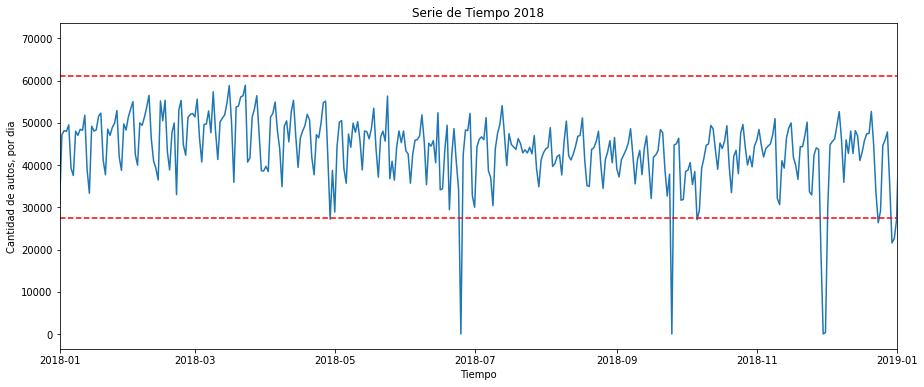

In [ ]:
diario_copy=diario.copy()
diario_quartil = diario_copy[(diario_copy.index > '2017-12-31')&(diario_copy.index < '2019-01-01')].copy()   #filtramos para dejar solo la terminal que queremos ver
q25,q75 =diario_quartil.cantidad_pasos.quantile([0.25,0.75]).values  #Se comienza calculado primer 1er y 3er cuartil
iqr = q75-q25
iqr = q75-q25
minimo = q25-1.5*iqr  #Calculamos los maximos y minimos de la distribucion
maximo = q75+1.5*iqr
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2018,1,1), datetime.date(2019,1,1)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2018')
plt.show()


In [ ]:
diario_copy=diario.copy()
diario_copy[(diario_copy.index > '2017-12-31')&(diario_copy.index < '2019-01-01')&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))]
fechas= diario_copy[(diario_copy.index > '2017-12-31')&(diario_copy.index < '2019-01-01')&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))].index

diario.loc[fechas,'cantidad_pasos']

fecha
2018-04-29    27169.0
2018-06-25        0.0
2018-09-25        0.0
2018-10-06    27061.0
2018-11-29    19728.0
2018-11-30        0.0
2018-12-01      350.0
2018-12-24    26332.0
2018-12-30    21559.0
2018-12-31    22599.0
Name: cantidad_pasos, dtype: float64

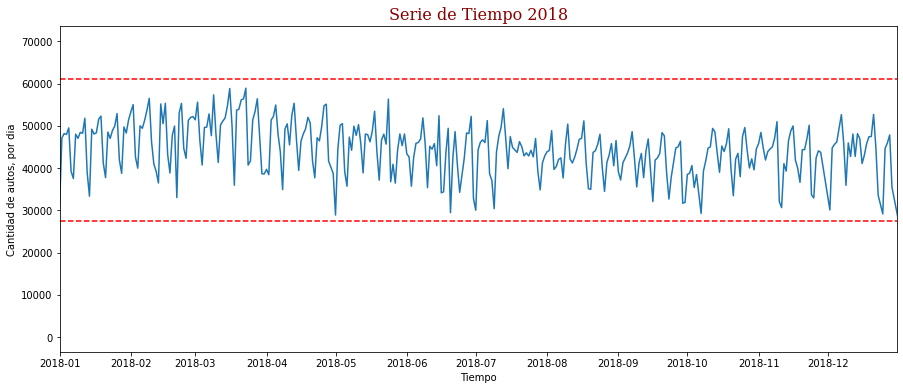

In [ ]:
diario.loc[fechas,'cantidad_pasos']= np.nan
diario['cantidad_pasos'] = diario['cantidad_pasos'].interpolate()
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2018,1,1), datetime.date(2018,12,31)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2018', fontdict= font)
plt.show()

Text(0, 0.5, 'Cantidad de autos, por dia')

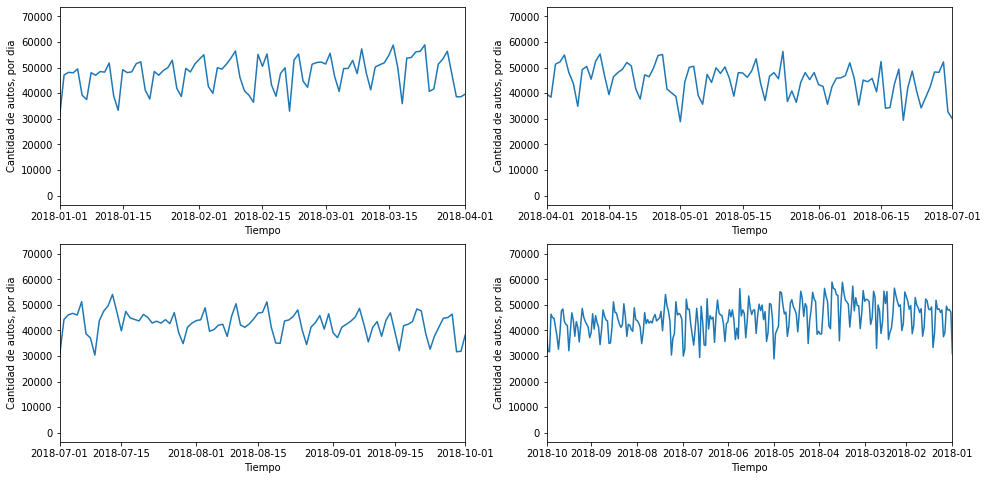

In [ ]:
plt.figure(figsize = (8*2,4*2)) #Primero creamos la figura que va a contener los distintos plots, se va a hacer en una relacion
  
plt.subplot(2,2,1)              #Generamos un subplot por cada histograma y caja de bigotes a graficar
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2018,1,1), datetime.date(2018,4,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(2,2,2)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2018,4,1), datetime.date(2018,7,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')


plt.subplot(2,2,3)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2018,7,1), datetime.date(2018,10,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')


plt.subplot(2,2,4)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2018,10,1), datetime.date(2018,1,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')

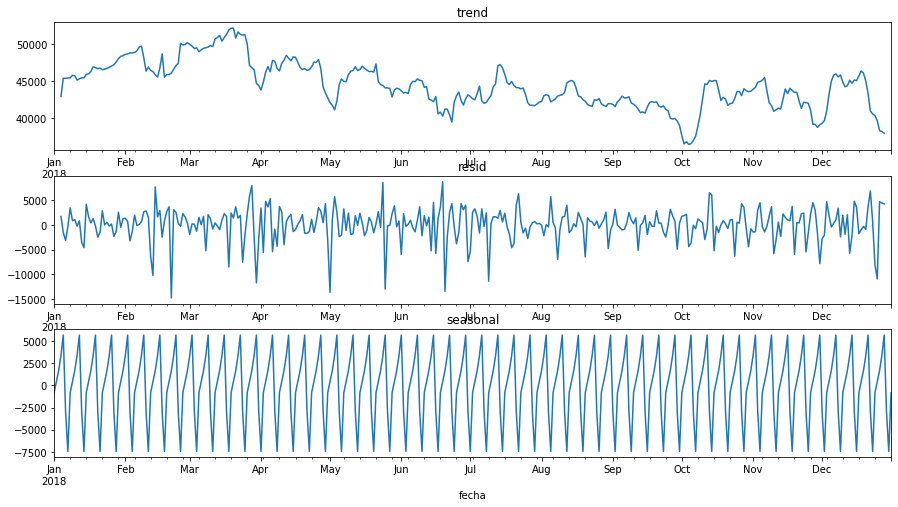

In [ ]:
diario_copy=diario.copy()
res = seasonal_decompose(diario_copy[(diario_copy.index > '2017-12-31')&(diario_copy.index < '2019-01-01')],model='additive')
#plt.figure(figsize = (15,6))
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,title="trend")
res.resid.plot(ax=ax2,title="resid")
res.seasonal.plot(ax=ax3,title="seasonal")
plt.show()

####Año 2019

In [ ]:
data_2019.describe()

periodo    hora_inicio       hora_fin  cantidad_pasos
count  812153.0  812153.000000  812153.000000   812153.000000
mean     2019.0      11.877101      11.957619      156.018047
std         0.0       6.676295       6.733530      387.348842
min      2019.0       0.000000       0.000000        1.000000
25%      2019.0       6.000000       7.000000        4.000000
50%      2019.0      12.000000      12.000000       15.000000
75%      2019.0      18.000000      18.000000       72.000000
max      2019.0      23.000000      23.000000     6677.000000

In [ ]:
data_2019.isna().sum()

periodo           0
fecha             0
hora_inicio       0
hora_fin          0
dia               0
estacion          0
sentido           0
tipo_vehiculo     0
forma_pago        0
cantidad_pasos    0
dtype: int64

In [ ]:
data_2019['fecha2'] = pd.to_datetime(data_2019.fecha) + pd.to_timedelta(data_2019.hora_fin, unit = 'h')

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


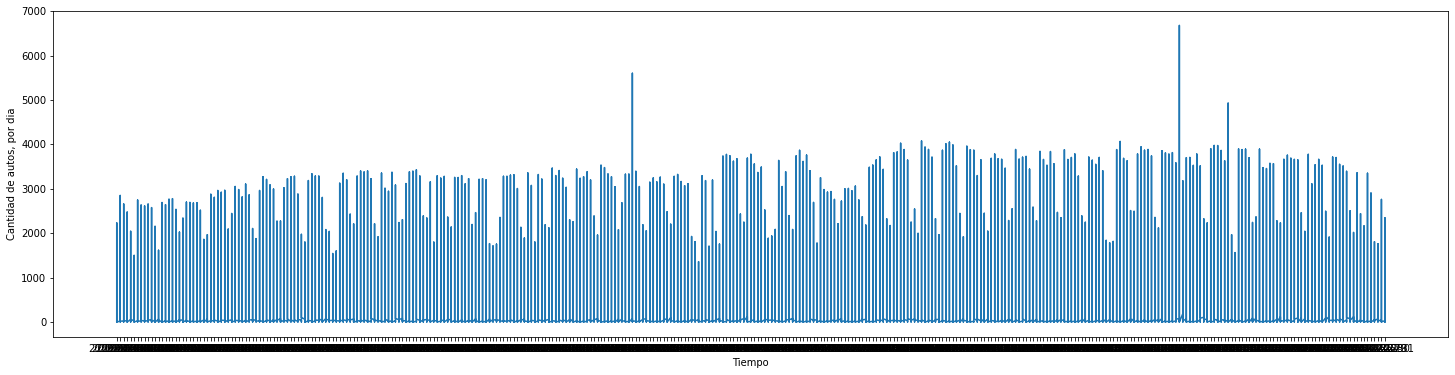

In [ ]:
plt.figure(figsize = (25,6))
plt.plot(data_2019.fecha, data_2019.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.show()

In [ ]:
data_2019['tipo_vehiculo']
cant = data_2019.groupby(['tipo_vehiculo']).count() 
cant

periodo   fecha  hora_inicio  ...  forma_pago  cantidad_pasos  fecha2
tipo_vehiculo                                ...                                    
Liviano         479684  479684       479684  ...      479684          479684  479684
Pesado          332469  332469       332469  ...      332469          332469  332469

[2 rows x 10 columns]

In [ ]:
data_centro= data_2019[data_2019.sentido.isin(['Centro'])]
data_provincia= data_2019[data_2019.sentido.isin(['Provincia'])]

In [ ]:
data_Alberti= data_2019[data_2019.estacion.isin(['Alberti'])]
data_Avellaneda= data_2019[data_2019.estacion.isin(['Avellaneda'])]
data_Dellepiane= data_2019[data_2019.estacion.isin(['Dellepiane'])]
data_illia= data_2019[data_2019.estacion.isin(['Illia'])]
data_PDB= data_2019[data_2019.estacion.isin(['PDB'])]
data_Retiro= data_2019[data_2019.estacion.isin(['Retiro'])]
data_Salguero= data_2019[data_2019.estacion.isin(['Salguero'])]
data_Sarmiento= data_2019[data_2019.estacion.isin(['Sarmiento'])]

In [ ]:
data_liviano= data_2019[data_2019.tipo_vehiculo.isin(['Liviano'])]
data_pesado= data_2019[data_2019.tipo_vehiculo.isin(['Pesado'])]

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


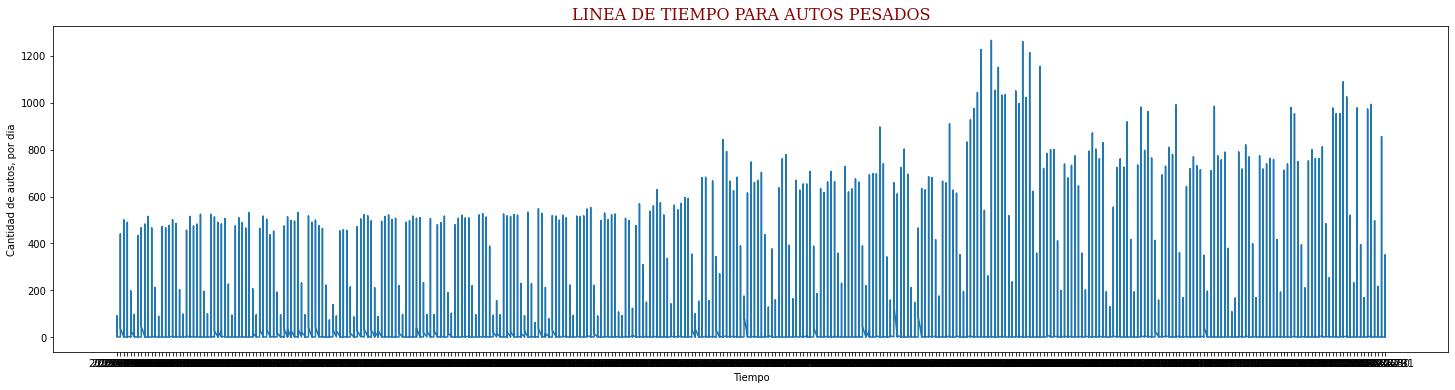

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


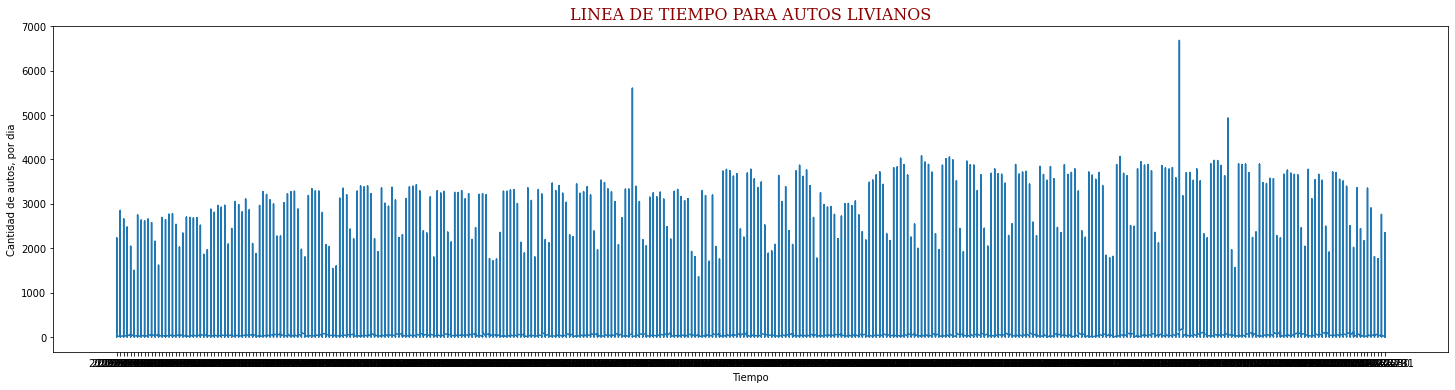

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


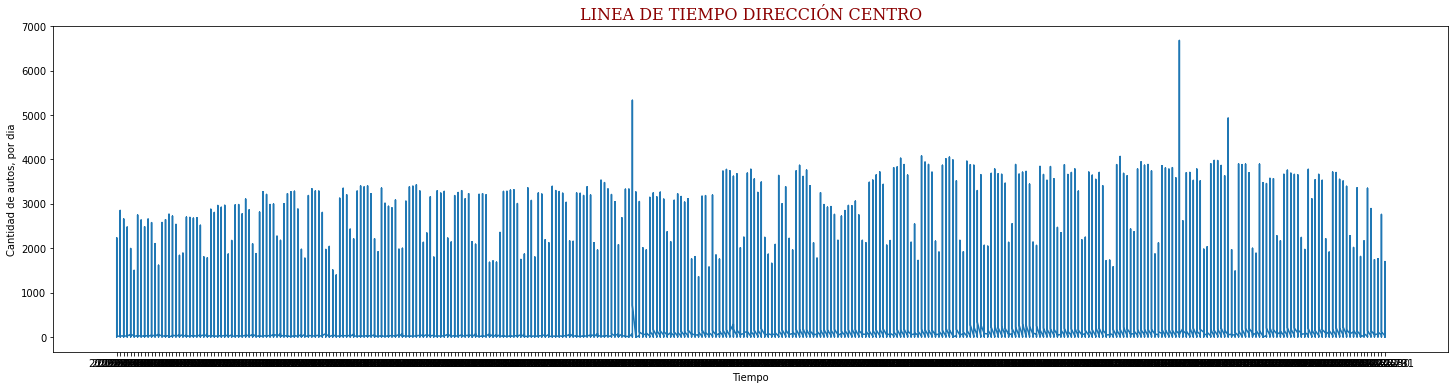

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


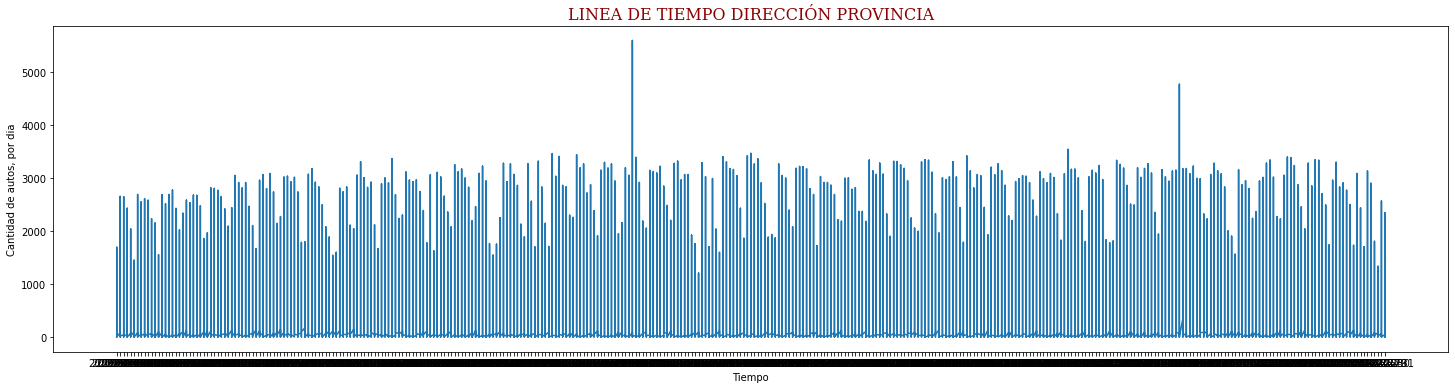

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


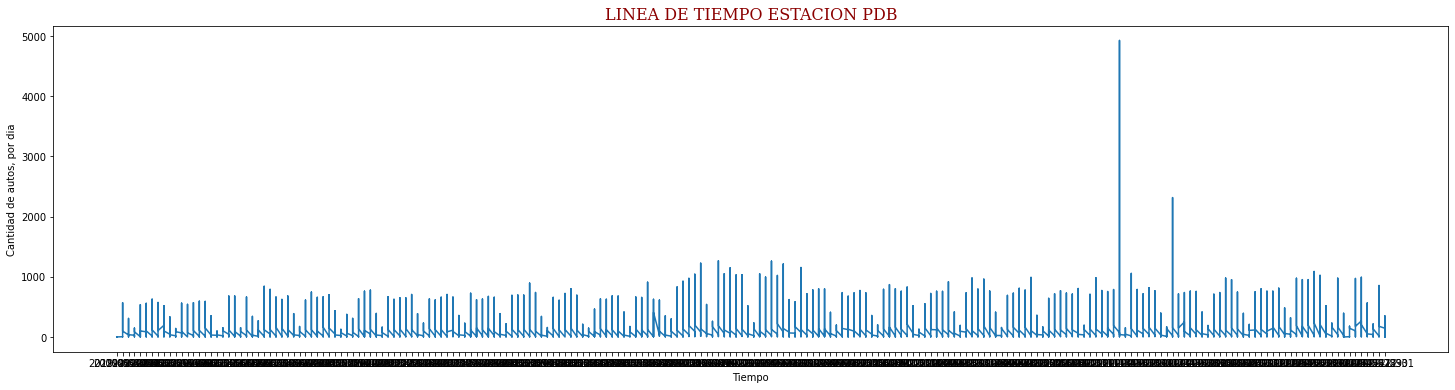

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


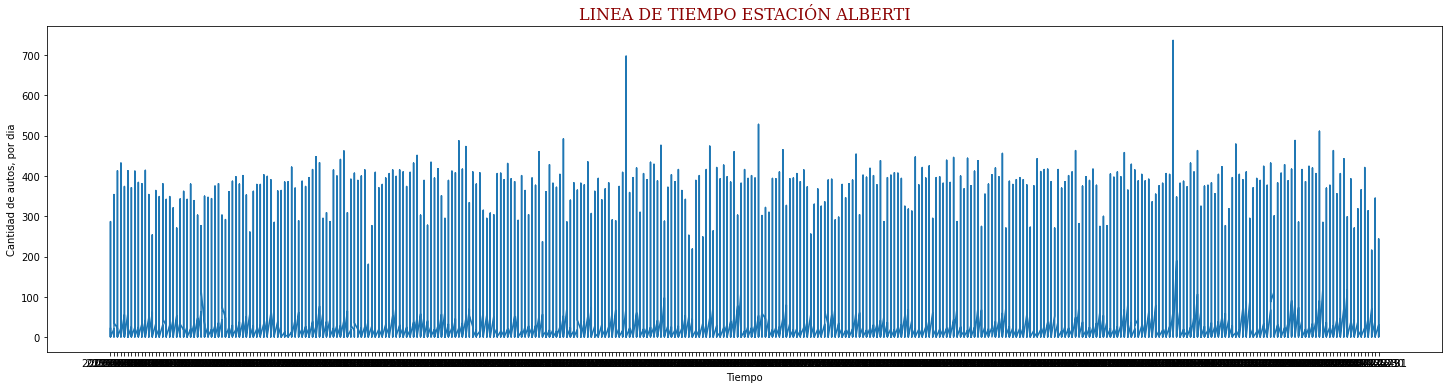

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


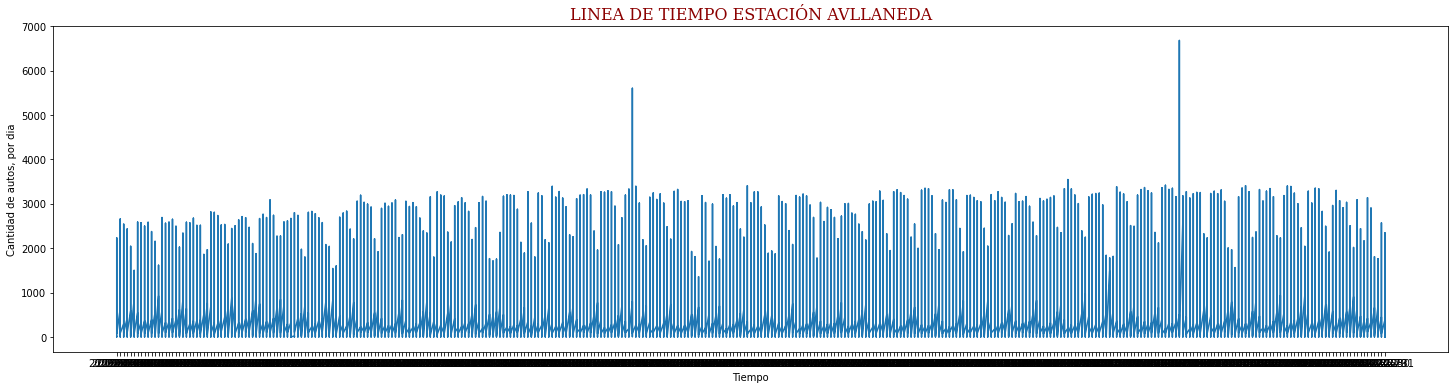

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


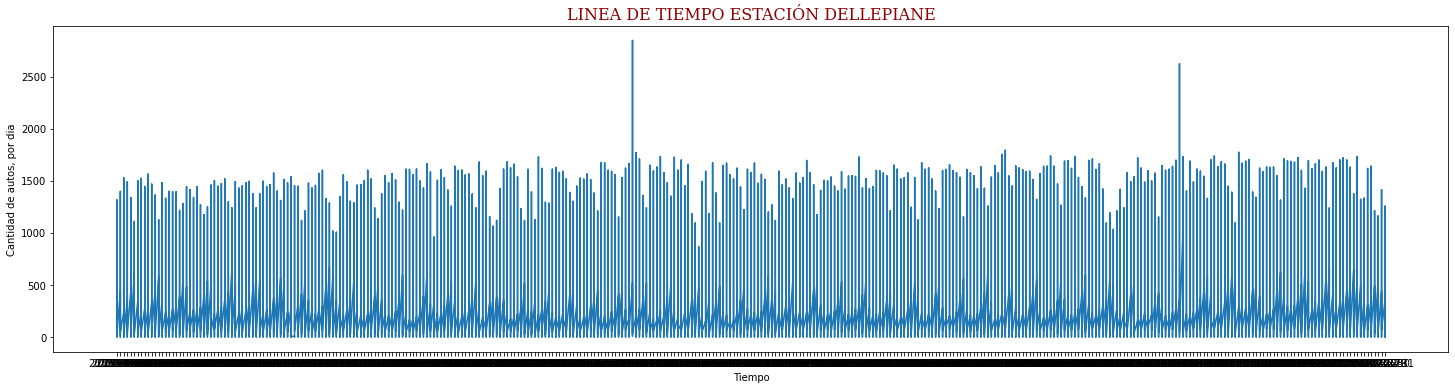

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


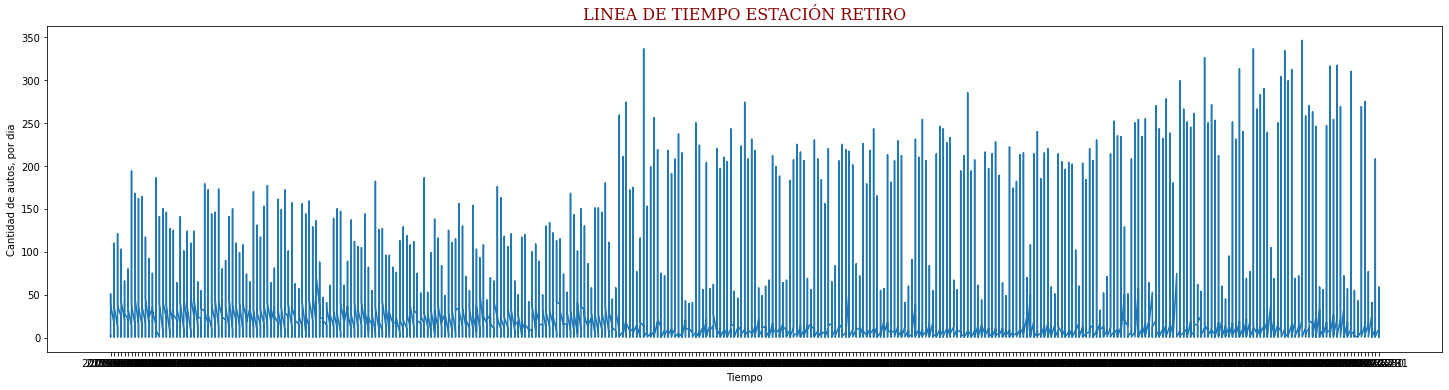

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


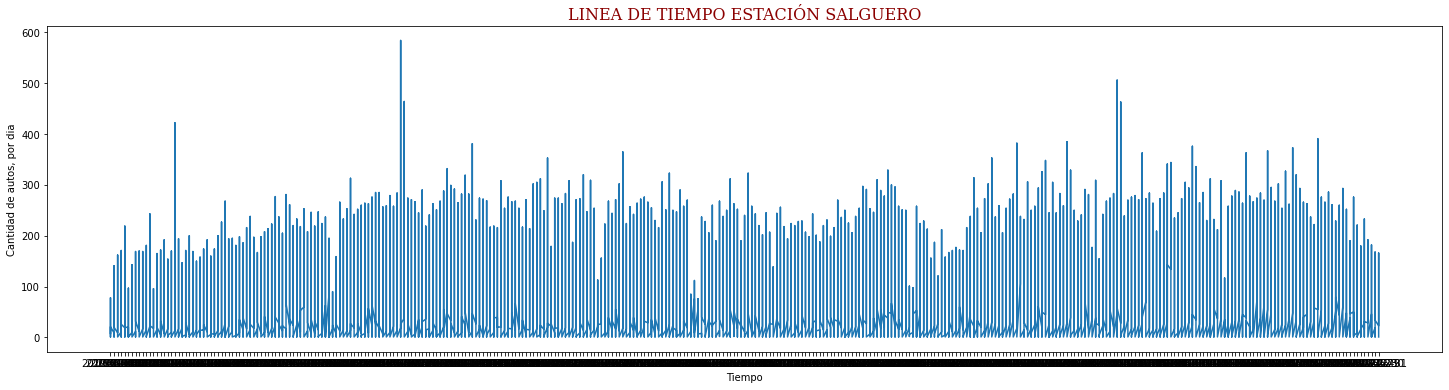

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


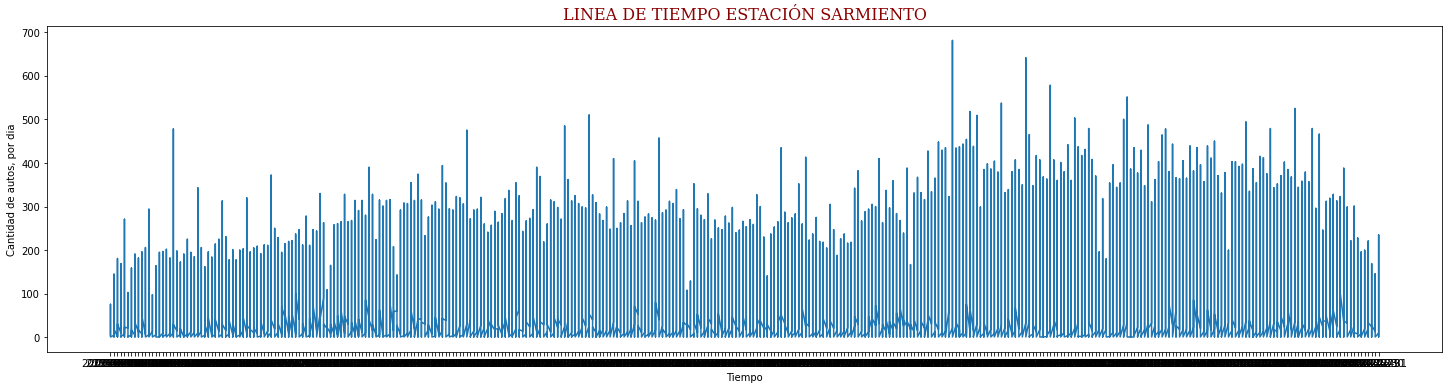

In [ ]:
#tipo vehiculo

plt.figure(figsize = (25,6))
plt.plot(data_pesado.fecha, data_pesado.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS PESADOS', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_liviano.fecha, data_liviano.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO PARA AUTOS LIVIANOS', fontdict= font)
plt.show()

#Sentido


plt.figure(figsize = (25,6))
plt.plot(data_centro.fecha, data_centro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN CENTRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_provincia.fecha, data_provincia.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO DIRECCIÓN PROVINCIA', fontdict= font)
plt.show()

#Estaciones

plt.figure(figsize = (25,6))
plt.plot(data_PDB.fecha, data_PDB.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACION PDB', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Alberti.fecha, data_Alberti.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN ALBERTI', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Avellaneda.fecha, data_Avellaneda.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN AVLLANEDA', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Dellepiane.fecha, data_Dellepiane.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN DELLEPIANE', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Retiro.fecha, data_Retiro.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN RETIRO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Salguero.fecha, data_Salguero.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SALGUERO', fontdict= font)
plt.show()

plt.figure(figsize = (25,6))
plt.plot(data_Sarmiento.fecha, data_Sarmiento.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('LINEA DE TIEMPO ESTACIÓN SARMIENTO', fontdict= font)
plt.show()


(812153, 11)
(812153, 11)


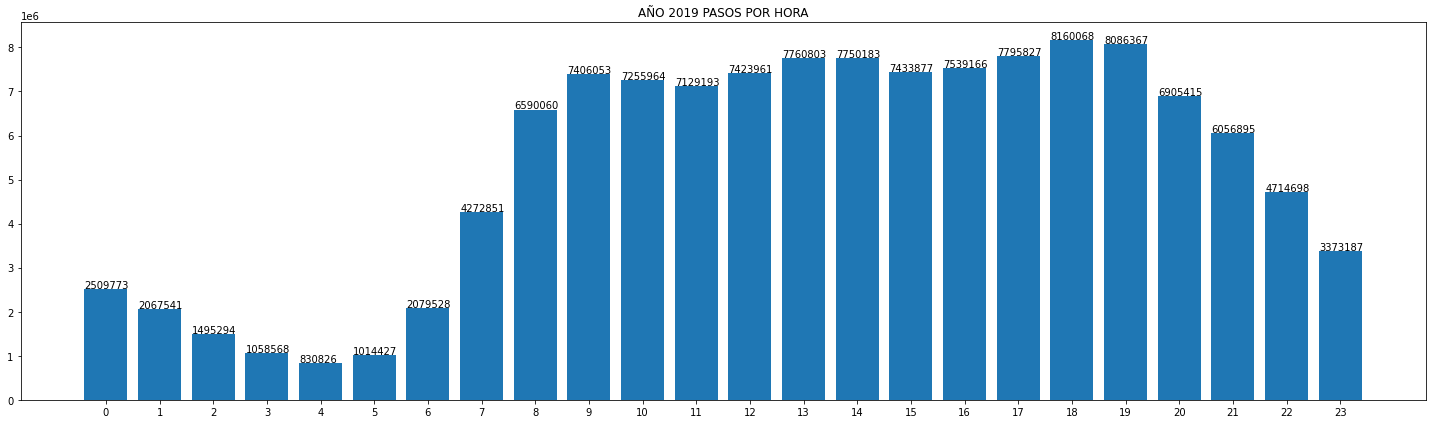

In [ ]:
dataset_copy=data_2019.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2020-01-01')].shape)
dataset_copy=dataset_copy[(dataset_copy.fecha < '2020-01-01')].groupby(['hora_fin'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.4 , y =data+20000 , s=f"{data}" , fontdict=dict(fontsize=10))    
plt.title('AÑO 2019 PASOS POR HORA')
plt.xticks(dataset_copy.index)
plt.tight_layout()
plt.show()

(346566, 5)
(311923, 5)


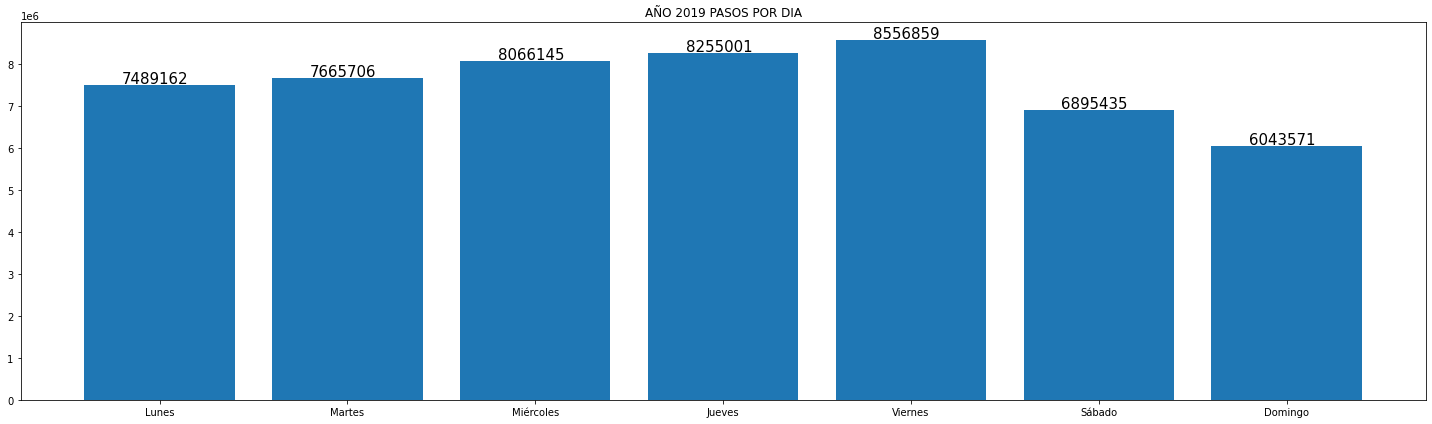

In [ ]:
dataset_copy=dataset.copy()
print(dataset_copy.shape)
print(dataset_copy[(dataset_copy.fecha < '2019-01-01')].shape)
cats = [ 'Lunes', 'Martes', 'Miércoles', 'Jueves', 'Viernes', 'Sábado', 'Domingo']
cat_type = CategoricalDtype(categories=cats, ordered=True)
dataset_copy['dia'] = dataset_copy['dia'].astype(cat_type)
dataset_copy=dataset_copy[(dataset_copy.fecha < '2019-01-01')].groupby(['dia'])['cantidad_pasos'].sum()
fig, ax = plt.subplots(figsize = (10*2,6))
ax.bar(dataset_copy.index, dataset_copy)
for index,data in enumerate(dataset_copy):
    plt.text(x=index-0.2 , y =data+40000 , s=f"{data}" , fontdict=dict(fontsize=15))    
plt.title('AÑO 2019 PASOS POR DIA')
plt.tight_layout()
plt.show()

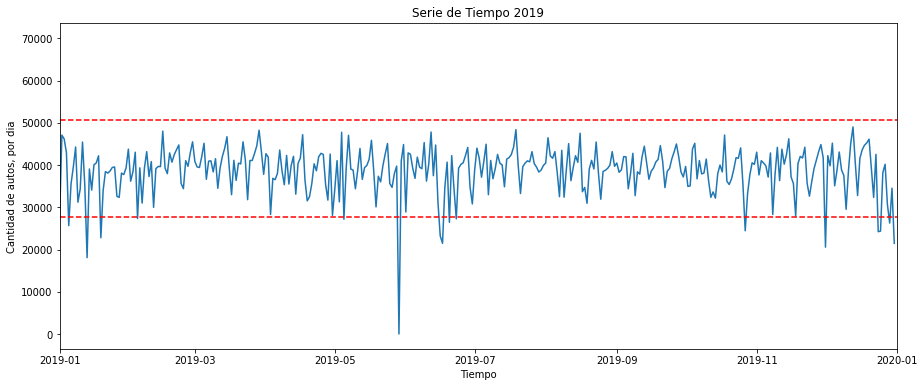

In [ ]:
diario_copy=diario.copy()
diario_quartil = diario_copy[(diario_copy.index > '2018-12-31')].copy()   #filtramos para dejar solo la terminal que queremos ver
q25,q75 =diario_quartil.cantidad_pasos.quantile([0.25,0.75]).values  #Se comienza calculado primer 1er y 3er cuartil
iqr = q75-q25
minimo = q25-1.5*iqr  #Calculamos los maximos y minimos de la distribucion
maximo = q75+1.5*iqr
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2019,1,1), datetime.date(2020,1,1)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2019')
plt.show()


In [ ]:
diario_copy=diario.copy()
diario_copy[(diario_copy.index > '2018-12-31')&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))]
fechas= diario_copy[(diario_copy.index > '2018-12-31')&((diario_copy.cantidad_pasos > maximo)|(diario_copy.cantidad_pasos < minimo))].index

diario.loc[fechas,'cantidad_pasos']

fecha
2019-01-01    27038.0
2019-01-05    25650.0
2019-01-13    18076.0
2019-01-19    22774.0
2019-02-04    27343.0
2019-05-05    27166.0
2019-05-29        0.0
2019-06-16    23190.0
2019-06-17    21469.0
2019-06-20    26438.0
2019-06-23    27259.0
2019-10-27    24434.0
2019-12-01    20553.0
2019-12-24    24220.0
2019-12-25    24349.0
2019-12-29    26259.0
2019-12-31    21447.0
Name: cantidad_pasos, dtype: float64

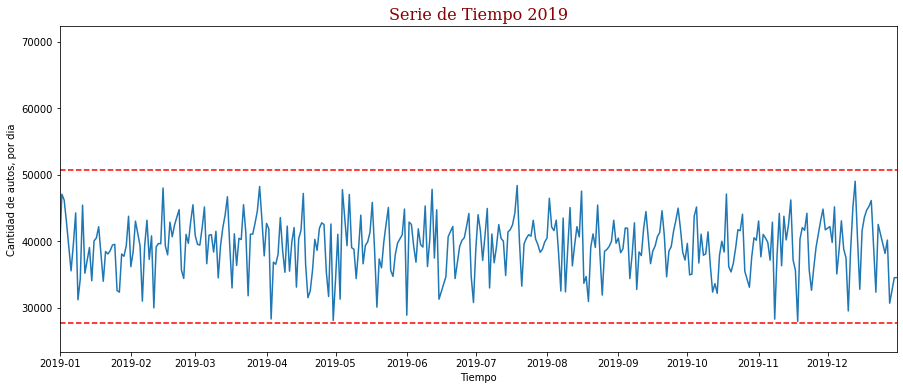

In [ ]:
diario.loc[fechas,'cantidad_pasos']= np.nan
diario['cantidad_pasos'] = diario['cantidad_pasos'].interpolate()
plt.figure(figsize = (15,6))
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2019,1,1), datetime.date(2019,12,31)))
plt.axhline(y=maximo,ls='--',color='r')
plt.axhline(y=minimo,ls='--',color='r')
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')
plt.title('Serie de Tiempo 2019', fontdict= font)
plt.show()

Text(0, 0.5, 'Cantidad de autos, por dia')

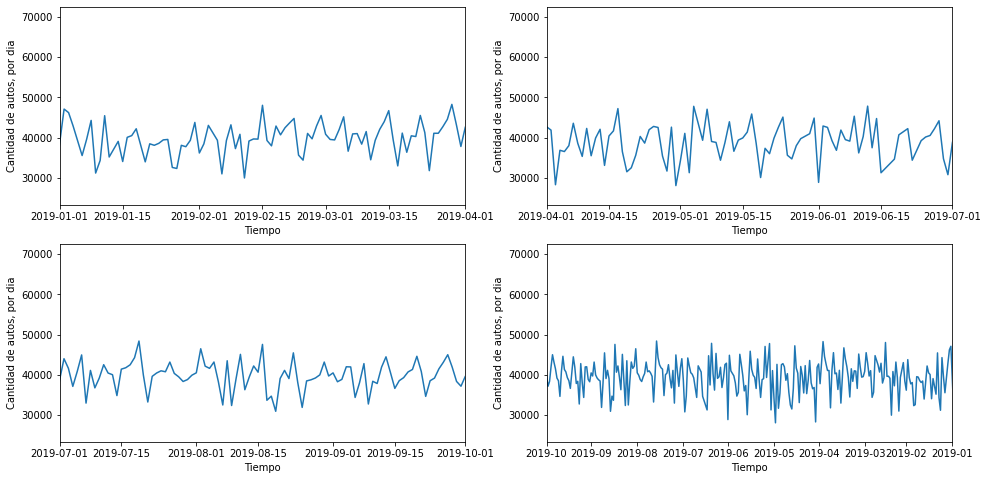

In [ ]:
plt.figure(figsize = (8*2,4*2)) #Primero creamos la figura que va a contener los distintos plots, se va a hacer en una relacion
  
plt.subplot(2,2,1)              #Generamos un subplot por cada histograma y caja de bigotes a graficar
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2019,1,1), datetime.date(2019,4,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')

plt.subplot(2,2,2)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2019,4,1), datetime.date(2019,7,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')


plt.subplot(2,2,3)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2019,7,1), datetime.date(2019,10,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')


plt.subplot(2,2,4)
plt.plot(diario.index, diario.cantidad_pasos)
plt.xlim((datetime.date(2019,10,1), datetime.date(2019,1,1)))
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por dia')

De acuerdo con los resultados anteriores para

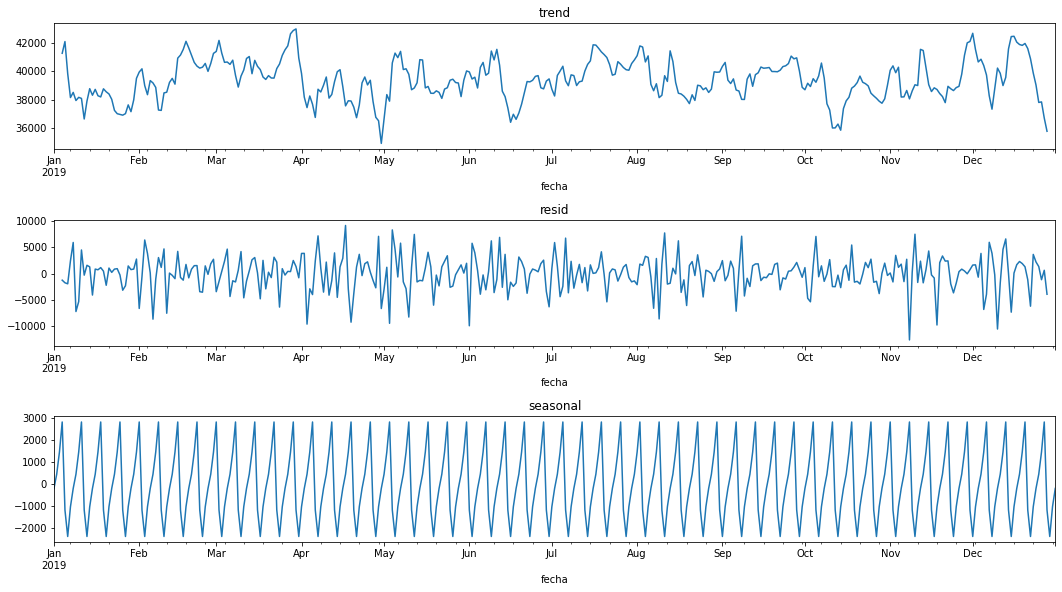

In [ ]:
diario_copy=diario.copy()
#diario_copy=diario_copy[(diario_copy.index > '2016-12-31')&(diario_copy.index < '2018-01-01')]
res = seasonal_decompose(diario_copy[(diario_copy.index > '2018-12-31')], model='additive')
#plt.figure(figsize = (15,6))
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(15,8))
res.trend.plot(ax=ax1,title="trend")
plt.tight_layout(pad=1.2)
res.resid.plot(ax=ax2,title="resid")
plt.tight_layout(pad=1.2)
res.seasonal.plot(ax=ax3,title="seasonal")
plt.show()

####Conclusiones de los 4 años

Se observa que para los 4 años el comportamiento es similar, en todos los años los dias con mayor cantidad de pasos son los dias jueves y viernes y los de menor los fines de semana. Asi mismo, la mayor cantidad de pasos se dan entre 5:00 pm y 8:00 pm, mientas que las horas de menor afluencia son entre la 00:00 am y las 7:00 am

Por otro lado, cuando se grafico la tendencia, y estacionalidad, para poder las componentes por año, se encuentran los mismos comportamientos, como cuatro picos por cada mes, seguido de una caida notable, comprobando su comportamiento semanal. Por otro lado, parece ser que el año **2016** fue el más estable, y con un comportamiento mas marcado. Despues de este año, el comportamiento de la serie de tiempo se nota más caotico, probablemente debido a que han sido años con algo de inestabilidad politica y social.




### Resampleo y graficas de ACF y PACF

A continuación pasamos a resamplear los datos por semana y por mes, esto se realizará tomando los 4 años como periodo de tiempo, debido a que el muestreo de frecuencia es demasiado amplio para observar por año individual.

Procedemos a resamplear primero por semanas los datos.

In [ ]:
#Resampleamos nuestros datos para agrupar por semana
semanal = dataset.resample('W', on = 'fecha').sum()
print(semanal.shape)
#revisamos el dataset, para confirmar el resampleo
semanal.head()

(210, 1)


cantidad_pasos
fecha                     
2016-01-03           98963
2016-01-10          342201
2016-01-17          359649
2016-01-24          346217
2016-01-31          348221

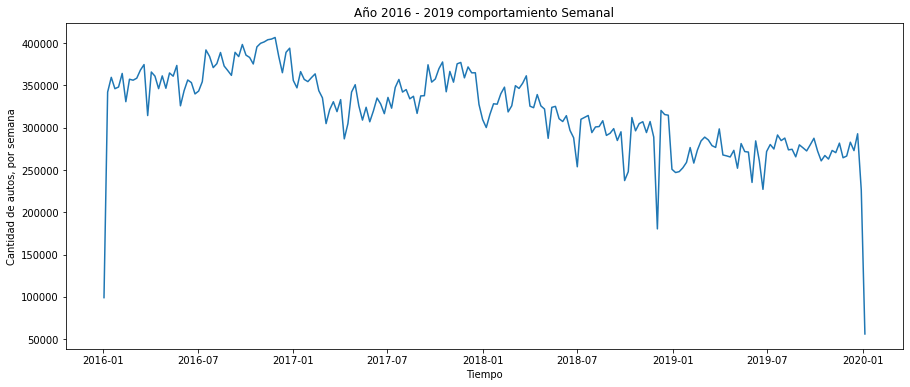

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(semanal.index, semanal.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por semana')
plt.title('Año 2016 - 2019 comportamiento Semanal')
plt.show()

Por el momento no se observa un comportamiento marcado, a excepcion de que parece que todo los años baja un poco la cantidad de pasos y luego en el ultimo o los ultimos meses sube la cantidad de pasos en la estación.

Ahora procedemos a observar por mes.

In [ ]:
#Resampleamos nuestros datos para agrupar por mes
mensual = dataset.resample('M', on = 'fecha').sum()
print(mensual.shape)
mensual.head()

(48, 1)


cantidad_pasos
fecha                     
2016-01-31         1495251
2016-02-29         1462367
2016-03-31         1590835
2016-04-30         1517590
2016-05-31         1559386

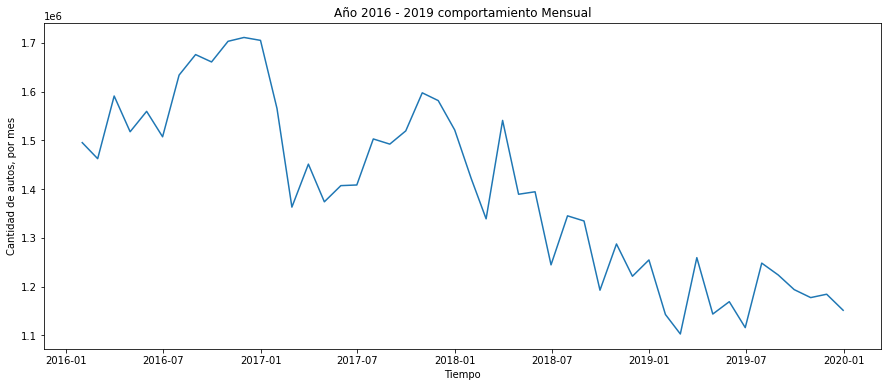

In [ ]:
plt.figure(figsize = (15,6))
plt.plot(mensual.index, mensual.cantidad_pasos)
plt.xlabel('Tiempo')
plt.ylabel('Cantidad de autos, por mes')
plt.title('Año 2016 - 2019 comportamiento Mensual')
plt.show()

De los anteriores resampleos, se observa como año tras año, la cantidad de pasos de autos continua disminuyendo. Tambien se observa como afirmativamente a final de cada año suele haber una subida de la cantidad de pasos.

Por ultimo observamos la composicion de nuetra serie de tiempo, a lo largo de los **4 años**.

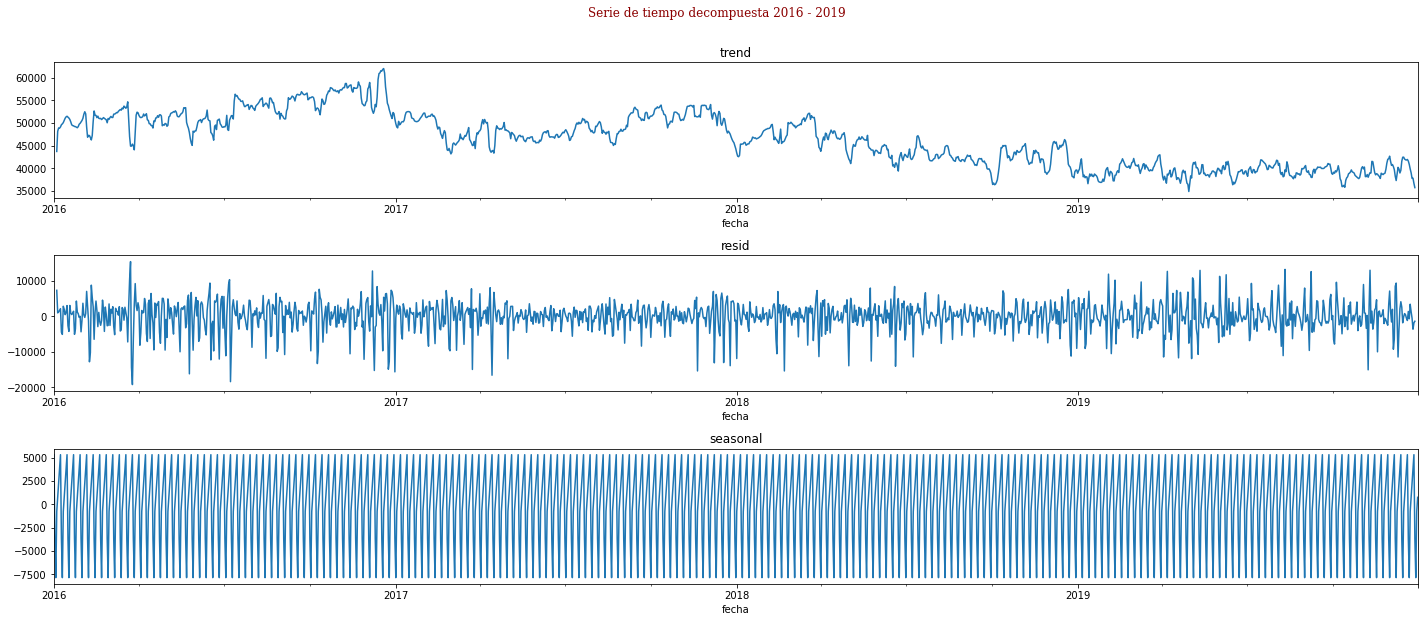

In [ ]:
res = seasonal_decompose(diario,model='additive')
#plt.figure(figsize = (15,6))
fig, (ax1,ax2,ax3) = plt.subplots(3,1, figsize=(20,8))
plt.suptitle('Serie de tiempo decompuesta 2016 - 2019', fontdict = font, y = 1.05)
res.trend.plot(ax=ax1,title="trend")
plt.tight_layout()
res.resid.plot(ax=ax2,title="resid")
plt.tight_layout()
res.seasonal.plot(ax=ax3,title="seasonal")
plt.show()

Como se observa, la tendencia en definitiva la tendencia es la disminucion de cantidad de pasos. La estacionalidad sigue sendo la misma que en cada año individual.

Ahora se revisará la autocorrelacion (ACF) y autocorrelacion parcial (PACF) de  cada la serie de tiempo, revisando la cantidad de rezagos relevantes y detallando si hay estacionalidad presente.

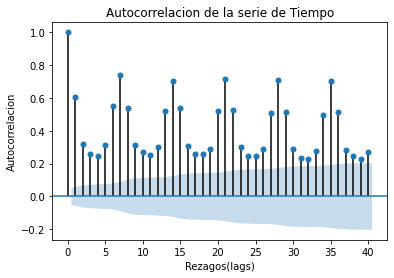

In [ ]:
nlags =  40
plot_acf(diario.cantidad_pasos, lags = nlags)
plt.title(f'Autocorrelacion de la serie de Tiempo')
plt.xlabel('Rezagos(lags)')

plt.ylabel('Autocorrelacion')
pyplot.show()

se observa como cada 7 rezagos hay una correlacion elevada con el primer rezago, y asi mismo va disminuyendo lentamente con el tiempo. Por lo tanto suele indicar que que hay aunque la relacion va disminuyendo con respecto a los componentes mas antiguos, esta disminuye muy lentamente.

Ahora se pasa a observar el diagrama de autocorrelacion parcial, a ver que comportamientos se logran observar.

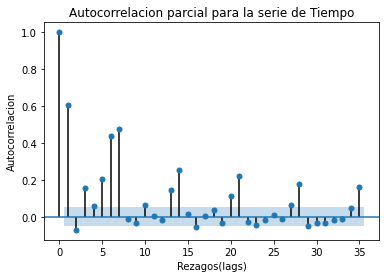

In [ ]:
nlags =  35
plot_pacf(diario.cantidad_pasos, lags = nlags)
plt.title(f'Autocorrelacion parcial para la serie de Tiempo')
plt.xlabel('Rezagos(lags)')
plt.ylabel('Autocorrelacion')
plt.show()   

En este se observa la relacion entre el rezago actual con el anterior, donde parece haber un numero elevado de rezagos significativos.

## Modelos Machine Learning

### Train Test Split

Como siempre antes de terminar de desarrollar el modelo, se comienza con la preparacion del dataset a usar, seleccionamos nuestra variable de entrada que será la fecha, o los dias, y la salida que será la cantidad de pasos en ese día.

In [ ]:
Y = list(diario.cantidad_pasos) # cantidad de Pasos 
X = list(diario.index) # fecha
dias = np.arange(0, len(X), 1).reshape(-1,1) # pasar de fechas a dias

#pasar la serie de lista a un array de numpy
series = np.array(Y)
tiempo = np.array(dias)

# fraccion de la serie para el entrenamiento
fraccion_tiempo = int(len(tiempo) - 122)

X_train = tiempo[:fraccion_tiempo]
y_train = series[:fraccion_tiempo]
X_test = tiempo[fraccion_tiempo:]
y_test = series[fraccion_tiempo:]
    

### Modelo De Benchmark(Arima)

Para el modelo de BenchMark se va a hacer uso de un modelo de Arima sin optimizar parametros, con unos parametros escogidos basados en las graficas de autocorrelacion.

Como metricas de error se ha escogido **MAE,RMSE y MAPE**, ya que este tipo de metricas nos ayudan a tener idea del error acumulado, de la diferencia del error predicho con el calculado, y son buenas para este tipo de problemas, donde son valores continuos.

error raiz cuadratico medio:4085.21
error absoluto medio:4085.21
El error porcentual absoluto medio:8.69
AIC:27230.396874565296


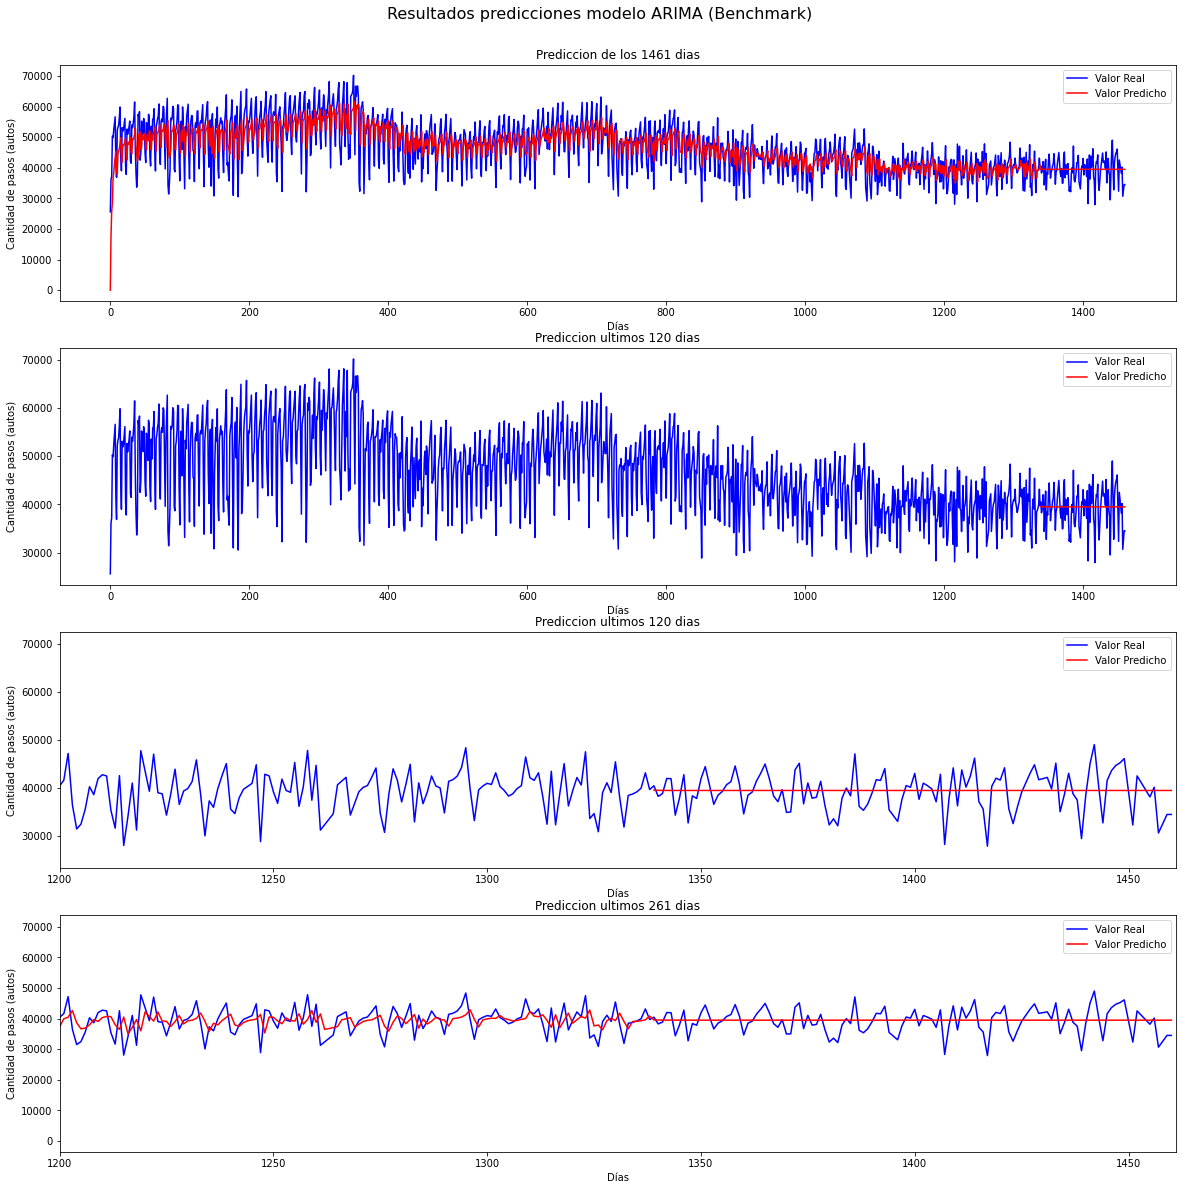

In [ ]:
errores=[]
start = len(y_train)  #Fecha de inicio y final de testeo 
end = len(y_train) + len(y_test) - 1
model= ARIMA(y_train, order= (1,1,1) ).fit()  #creamos y entrenamos el modelo Arima con los hiperparametros que creemos correctos
                                              #Basados en el analisis anterior
predictions = model.predict(start, end, typ = 'levels')   #hacemos las predicciones para los ultimos 120 dias
predictions_0 = model.predict(0, len(tiempo)-1, typ = 'levels')     #hacemos las predicciones para el total de los dias

print(f'error raiz cuadratico medio:{round(np.sqrt(mean_squared_error(y_test, predictions)),2)}')    #Calculamos las metricas para el modelo entrenado MSE y MAE
print(f'error absoluto medio:{round(np.sqrt(mean_squared_error(y_test, predictions)),2)}')
print(f'El error porcentual absoluto medio:{round(mean_absolute_percentage_error(y_test, predictions),2)}')    
print(f'AIC:{model.aic}')
errores.append({'RMSE_test': round(np.sqrt(mean_squared_error(y_test, predictions)),2),
                'MAE_test': round(mean_absolute_error(y_test, predictions),2),
                'MAPE_test': round(mean_absolute_percentage_error(y_test, predictions),2)})
#print(predictions)
plt.figure(figsize=(20,20))           #establece el tamaño de la grafica
plt.suptitle('Resultados predicciones modelo ARIMA (Benchmark)', fontsize=16,y=0.92)  
plt.subplot(4,1,1)    
plt.plot(dias, Y, color="blue",label='Valor Real')
plt.plot(dias,predictions_0.reshape(-1,1) , color="red", label='Valor Predicho')    
plt.title(f'Prediccion de los 1461 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.legend()

plt.subplot(4,1,2)
plt.plot(dias, Y, color="blue",label='Valor Real')     
plt.plot(X_test,predictions , color="red", label='Valor Predicho')
plt.title(f'Prediccion ultimos 120 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.legend()

plt.subplot(4,1,3)
plt.plot(dias, Y, color="blue",label='Valor Real')     
plt.plot(X_test,predictions , color="red", label='Valor Predicho')
plt.title(f'Prediccion ultimos 120 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.xlim(1200, len(Y))
plt.legend()

plt.subplot(4,1,4)
plt.plot(dias, Y, color="blue",label='Valor Real')
plt.plot(dias,predictions_0.reshape(-1,1) , color="red", label='Valor Predicho')
plt.title(f'Prediccion ultimos 261 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.xlim(1200, len(Y))
plt.legend()

plt.show()

Del modelo de Benchmark, hay que notar que simplemente da como una linea recta de los ultimos dias, sin capacidad de dar detalle de la linea de tiempo.

### Arima model optimizado

Ahora que ya tenemos un modelo de Benchmark, podemos proceder a optimizar la salida de nuestro modelo ARIMA, para ello, se va utilizar la herramienta llamada auto_arima, a la cual le podemos entregar ciertos parametros, y probara combinatorias entre lso rangos especificados hasta hallar la mejor. Esta herramienta funciona similar a GridSearch.

In [ ]:
#Se hace uso de auto_arima para hallar los mejores parametros para el modelo arima, herramienta similar a GridSearchCV
model = auto_arima(y_train,start_p=7,start_q=3,max_p=15,max_q=10,d = 1,seasonal=True,trace= True, suppress_warnings=True, error_action ='ignore')  
start = len(y_train)  #Fecha de inicio y final de testeo 
end = len(y_train) + len(y_test) - 1
model= ARIMA(y_train, order=model.order).fit()  #creamos y entrenamos el modelo Arima con los hiperparametros hallados, con el parametros order
predictions = model.predict(start, end, typ = 'levels')   #hacemos las predicciones para los ultimos 120 dias


Performing stepwise search to minimize aic
 ARIMA(7,1,3)(0,0,0)[0] intercept   : AIC=26638.105, Time=7.32 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=27693.933, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=27673.351, Time=0.11 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=27393.459, Time=0.85 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=27691.936, Time=0.04 sec
 ARIMA(6,1,3)(0,0,0)[0] intercept   : AIC=26610.600, Time=5.55 sec
 ARIMA(5,1,3)(0,0,0)[0] intercept   : AIC=26723.779, Time=5.00 sec
 ARIMA(6,1,2)(0,0,0)[0] intercept   : AIC=26726.444, Time=3.07 sec
 ARIMA(6,1,4)(0,0,0)[0] intercept   : AIC=26644.572, Time=6.59 sec
 ARIMA(5,1,2)(0,0,0)[0] intercept   : AIC=26806.531, Time=2.28 sec
 ARIMA(5,1,4)(0,0,0)[0] intercept   : AIC=26678.841, Time=5.29 sec
 ARIMA(7,1,2)(0,0,0)[0] intercept   : AIC=26724.315, Time=6.05 sec
 ARIMA(7,1,4)(0,0,0)[0] intercept   : AIC=26636.423, Time=6.36 sec
 ARIMA(6,1,3)(0,0,0)[0]             : AIC=26605.317, Time=5.37 sec
 ARIMA(5,1,3)(0,0,0

/usr/local/lib/python3.7/dist-packages/statsmodels/base/model.py:568: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals




Ahora que ya tenemos las parametros p,d,q . Procedemos a evaluar el modelo y entrenar.


error raiz cuadratico medio:4059.54
error absoluto medio:4059.54
El error porcentual absoluto medio:8.6
AIC:26605.31700835775


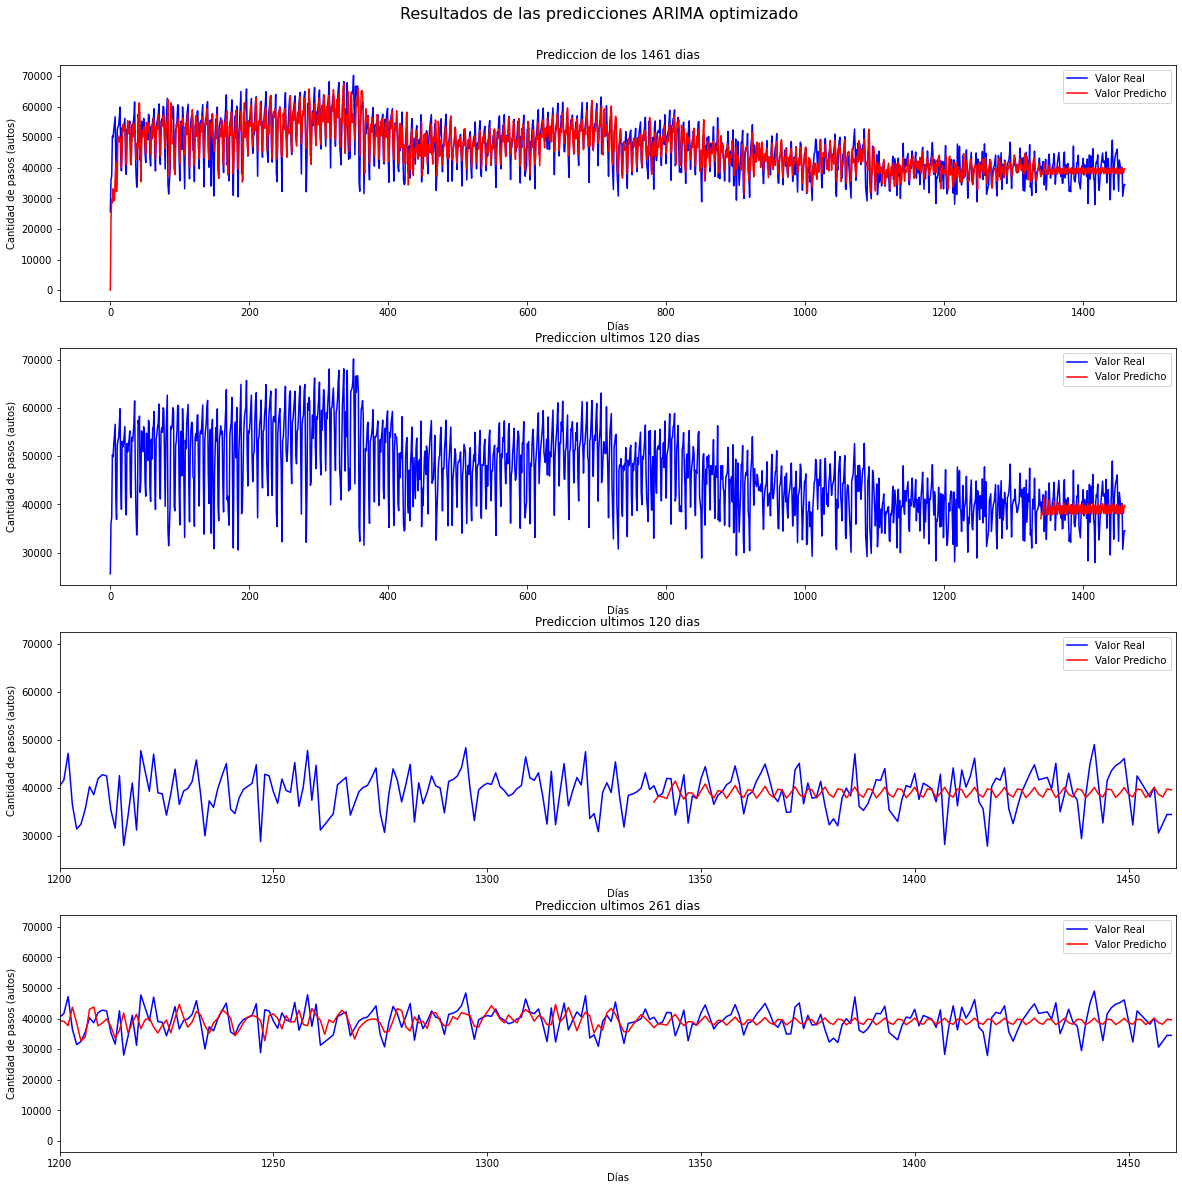

In [ ]:
predictions_0 = model.predict(0, len(tiempo)-1, typ = 'levels')     #hacemos las predicciones para el total de los 120 dias

print(f'error raiz cuadratico medio:{round(np.sqrt(mean_squared_error(y_test, predictions)),2)}')    #Calculamos las metricas para el modelo entrenado MSE y MAE
print(f'error absoluto medio:{round(np.sqrt(mean_squared_error(y_test, predictions)),2)}')
print(f'El error porcentual absoluto medio:{round(mean_absolute_percentage_error(y_test, predictions),2)}')    
print(f'AIC:{model.aic}')
errores.append({'RMSE_test': round(np.sqrt(mean_squared_error(y_test, predictions)),2),
                'MAE_test': round(mean_absolute_error(y_test, predictions),2),
                'MAPE_test': round(mean_absolute_percentage_error(y_test, predictions),2)})

plt.figure(figsize=(20,20))           #establece el tamaño de la grafica
plt.suptitle('Resultados de las predicciones ARIMA optimizado', fontsize=16,y=0.92)  
plt.subplot(4,1,1)    
plt.plot(dias, Y, color="blue",label='Valor Real')
plt.plot(dias,predictions_0.reshape(-1,1) , color="red", label='Valor Predicho')    
plt.title(f'Prediccion de los 1461 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.legend()

plt.subplot(4,1,2)
plt.plot(dias, Y, color="blue",label='Valor Real')     
plt.plot(X_test,predictions , color="red", label='Valor Predicho')
plt.title(f'Prediccion ultimos 120 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.legend()

plt.subplot(4,1,3)
plt.plot(dias, Y, color="blue",label='Valor Real')     
plt.plot(X_test,predictions , color="red", label='Valor Predicho')
plt.title(f'Prediccion ultimos 120 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.xlim(1200, len(Y))
plt.legend()

plt.subplot(4,1,4)
plt.plot(dias, Y, color="blue",label='Valor Real')
plt.plot(dias,predictions_0.reshape(-1,1) , color="red", label='Valor Predicho')
plt.title(f'Prediccion ultimos 261 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.xlim(1200, len(Y))
plt.legend()

plt.show()

Graficamente la mejora es notable, ya no entrega simplemente un promedio, sino que es capaz de seguir caidas y subidas en la variable, los parametros MAPE, MAE y RMSE tambien mejoran, es un modelo aceptable. Aun asi, haremos prueba de la herramienta Prophet, para poder tener otro modelo para comparar, y tratar de hallar el mejor resultado posible.




### Prophet model

In [ ]:
diario.head()

cantidad_pasos
fecha                     
2016-01-01         25602.0
2016-01-02         36136.0
2016-01-03         37225.0
2016-01-04         50312.0
2016-01-05         49907.0

In [ ]:
pred = diario.fillna(0)
predgrp = diario.groupby("fecha")[["cantidad_pasos"]].sum().reset_index()
predgrp.head()

fecha  cantidad_pasos
0 2016-01-01         25602.0
1 2016-01-02         36136.0
2 2016-01-03         37225.0
3 2016-01-04         50312.0
4 2016-01-05         49907.0

In [ ]:
pr_data = predgrp
pr_data.columns = ['ds','y']
pr_data.head()

ds        y
0 2016-01-01  25602.0
1 2016-01-02  36136.0
2 2016-01-03  37225.0
3 2016-01-04  50312.0
4 2016-01-05  49907.0

A continuacion hacemos la division entre train y test, se realiza nuevamente, ya que al introducir los datos en Prophet se hace de manera diferente que en ARIMA

In [ ]:
#se seleccionan solos datos 
data_train=pr_data[['ds','y']].iloc[:1339]
data_train

ds        y
0    2016-01-01  25602.0
1    2016-01-02  36136.0
2    2016-01-03  37225.0
3    2016-01-04  50312.0
4    2016-01-05  49907.0
...         ...      ...
1334 2019-08-27  38760.0
1335 2019-08-28  39207.0
1336 2019-08-29  39986.0
1337 2019-08-30  43164.0
1338 2019-08-31  39703.0

[1339 rows x 2 columns]

  Y revisamos los datos testeo.

In [ ]:
data_test=pr_data[['ds','y']].iloc[-122::]
data_test

ds        y
1339 2019-09-01  40473.0
1340 2019-09-02  38274.0
1341 2019-09-03  38869.0
1342 2019-09-04  41994.0
1343 2019-09-05  41954.0
...         ...      ...
1456 2019-12-27  40182.0
1457 2019-12-28  30681.0
1458 2019-12-29  32602.0
1459 2019-12-30  34523.0
1460 2019-12-31  34523.0

[122 rows x 2 columns]

In [ ]:
m=Prophet()
m.fit(data_train)
future=m.make_future_dataframe(periods=122)   # Predicción 122 días
forecast=m.predict(future)
forecast.head().T

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


0  ...                    4
ds                          2016-01-01 00:00:00  ...  2016-01-05 00:00:00
trend                                   51237.7  ...              51268.5
yhat_lower                              49038.5  ...              43713.8
yhat_upper                              60965.9  ...              55528.9
trend_lower                             51237.7  ...              51268.5
trend_upper                             51237.7  ...              51268.5
additive_terms                           3548.7  ...              -1748.1
additive_terms_lower                     3548.7  ...              -1748.1
additive_terms_upper                     3548.7  ...              -1748.1
weekly                                  5408.15  ...              868.935
weekly_lower                            5408.15  ...              868.935
weekly_upper                            5408.15  ...              868.935
yearly                                 -1859.45  ...             -2617.04
yearly_lower                           -1859.45  ...             -2617.04
yearly_upper                           -1859.45  ...             -2617.04
multiplicative_terms                          0  ...                    0
multiplicative_terms_lower                    0  ...                    0
multiplicative_terms_upper                    0  ...                    0
yhat                                    54786.4  ...              49520.4

[19 rows x 5 columns]

In [ ]:
y_ped = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]
y_ped.head()

ds          yhat    yhat_lower    yhat_upper
0 2016-01-01  54786.421202  49038.517511  60965.883678
1 2016-01-02  45178.884757  39210.695133  51442.001382
2 2016-01-03  40593.071424  34652.135906  46680.678691
3 2016-01-04  48138.215624  42282.008751  54267.850575
4 2016-01-05  49520.415356  43713.821242  55528.929910

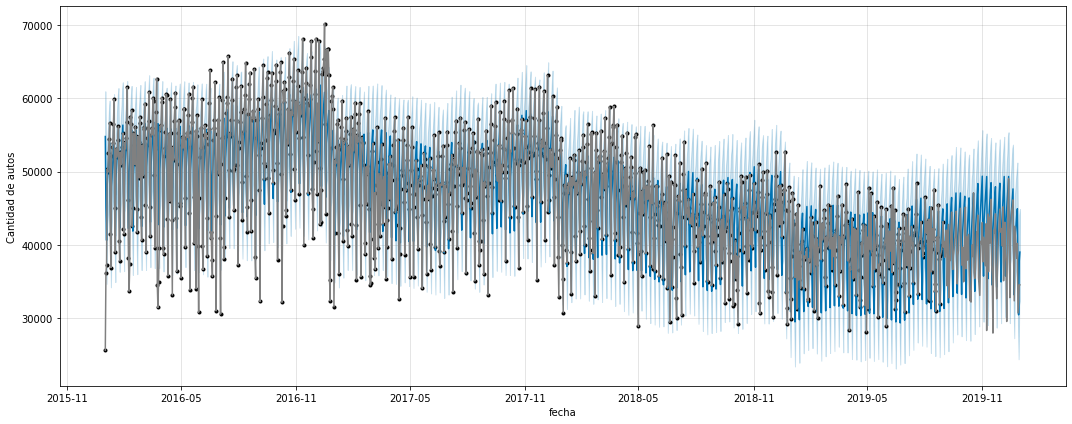

In [ ]:
m.plot(forecast,xlabel='fecha',ylabel='Cantidad de autos', uncertainty=True,figsize=(15, 6))
plt.plot(diario.index, diario.cantidad_pasos, color="gray",label='Valor Real')


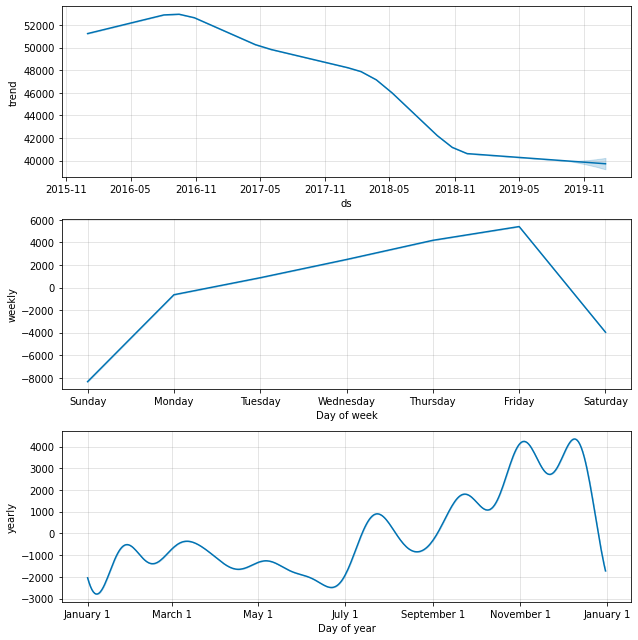

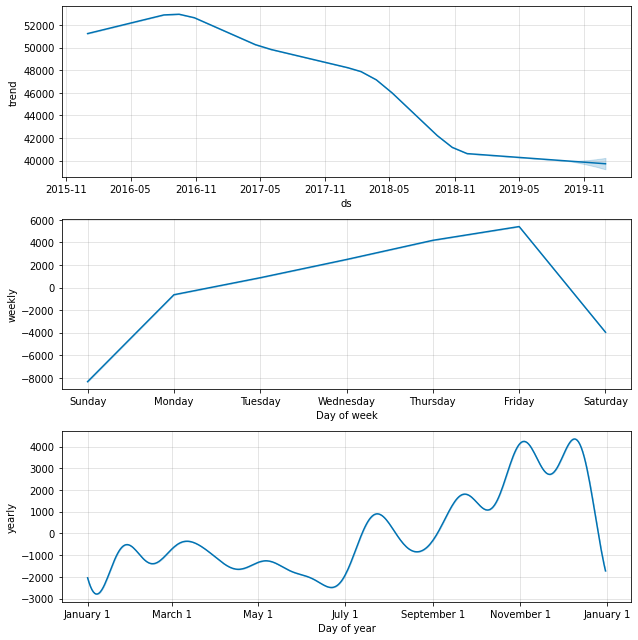

In [ ]:
m.plot_components(forecast)

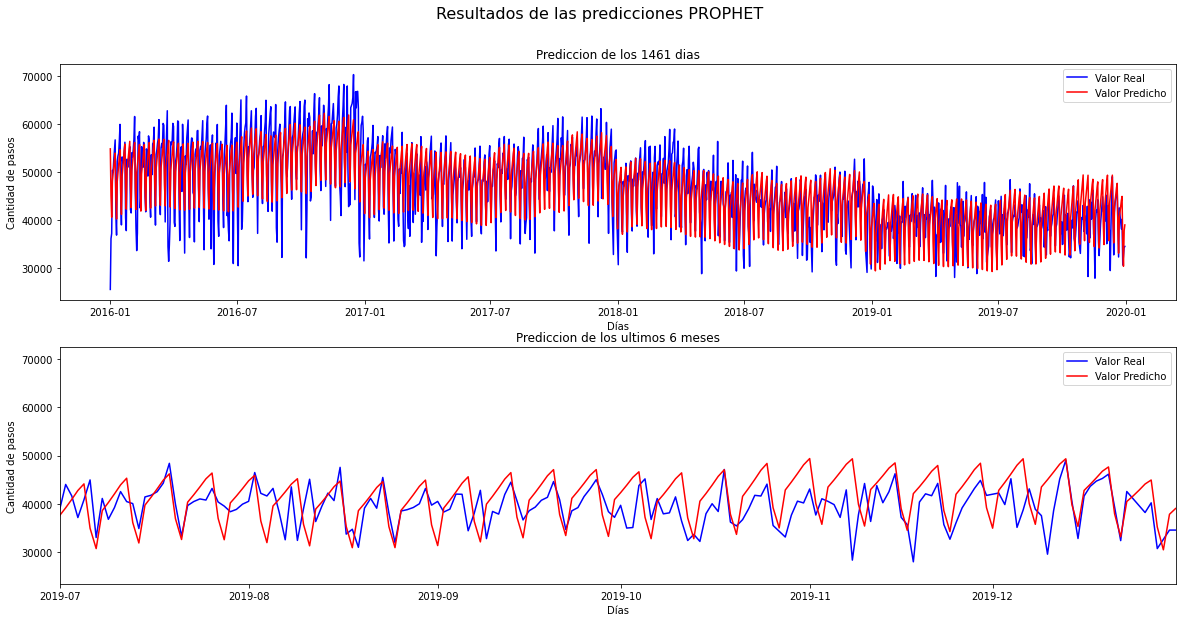

In [ ]:
plt.figure(figsize=(20,20))           #establece el tamaño de la grafica
plt.suptitle('Resultados de las predicciones PROPHET', fontsize=16,y=0.92)  
plt.subplot(4,1,1)    
plt.plot(diario.index, diario.cantidad_pasos, color="blue",label='Valor Real')
plt.plot(y_ped['ds'], y_ped['yhat'] , color="red", label='Valor Predicho')    
plt.title(f'Prediccion de los 1461 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos')
plt.legend()

plt.subplot(4,1,2)
plt.plot(diario.index, diario.cantidad_pasos, color="blue",label='Valor Real')
plt.plot(y_ped['ds'], y_ped['yhat'] , color="red", label='Valor Predicho')  
plt.title(f'Prediccion de los ultimos 6 meses')
plt.xlim((datetime.date(2019,7,1), datetime.date(2019,12,31)))
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos')
plt.legend()


A continuacion procedemos a evaluar con las metricas, porque aunque parece que la predicción logra seguir las subidas y bajadas, no logra detectar las pequeñas variaciones, lo cual pede generar un error acumulado bastante grande.

In [ ]:
y = y_ped["yhat"].iloc[-122::]
#MSE - Error cuadrático medio
rmse=np.sqrt(mean_squared_error(diario["cantidad_pasos"].iloc[-122::],y))
print('error cuadrático medio: ',rmse)
#MAE - Error absoluto medio
mae=mean_absolute_error(diario["cantidad_pasos"].iloc[-122::],y)
print('error absoluto medio: ',mae)
mape=mean_absolute_percentage_error(diario["cantidad_pasos"].iloc[-122::],y)
print('error absoluto medio: ',mape)

error cuadrático medio:  5507.759342357304
error absoluto medio:  4341.908033355261
error absoluto medio:  11.636536261436902


In [ ]:
errores.append({'RMSE_test': round(rmse,2),
                'MAE_test': round(mae,2),
                'MAPE_test': round(mape,2)})    

### Resultados de los modelos.

Finalmente, en el siguiente recuadro, se observará, los resultados obtenidos en la siguiente tabla

In [ ]:
df_errores=pd.DataFrame(errores,index=['ARIMA(BENCHMARK)','ARIMA OPTIMIZADO','PROPHET']) 
df_errores.head()

RMSE_test  MAE_test  MAPE_test
ARIMA(BENCHMARK)    4085.21   3266.27       8.69
ARIMA OPTIMIZADO    4059.54   3259.89       8.60
PROPHET             5507.76   4341.91      11.64

Finalmente, se observa como el modelo con mejor resultado es el **ARIMA optimizado**, gracias autoarima, ya que tiene la menor diferencia entre los valores predichos y el valor real de los ultimos tres meses sobre la cantidad de pasos en la estación. 


### Eleccion de modelo

Finalmente se decide que el mejor modelo es **ARIMA Optimizado** el cual tiene el mejor rendimiento en cada una de las metricas, y que si se observa en detalle, logra captar las subidas y bajadas en la cantidad de pasos por dia, tal vez no en la magnitud deseada, pero ese seguimiento de la serie manteniendo cierta moderación es la que finalmente permite que tenga el mejor rendimiento los modelos, ademas gracias al MAPE se podría calcular de en promedio que tanto porcentualmente se iría por arriba o por abajo el modelo.

## Investigacion modelo red neuronal LSTM

Las fuentes de la informacion se puede encontrar en la siguiente publicación

 [Pronóstico de series de tiempo: ARIMA vs LSTM vs PROPHET](https://ichi.pro/es/pronostico-de-series-de-tiempo-arima-vs-lstm-vs-prophet-107907230218811).

[Tutorial on Univariate Single-Step Style LSTM in Time Series Forecasting](https://analyticsindiamag.com/tutorial-on-univariate-single-step-style-lstm-in-time-series-forecasting/).


La red neuronal LSTM es una ANN usada comunmente en datos secunciales, por lo cual es ideal para aprendizaje del lenguaje y para series de tiempo. Esta red neuronal posee una memoria de corto y una largo plazo, como su nombre lo indica Long Short-Term Memory (LSTM), este modelo de red neuronal funciona como una especie de valvulas que dependiendo del valor de la información, permite o no el paso de la informacion. A continuación una grafica del modelo.

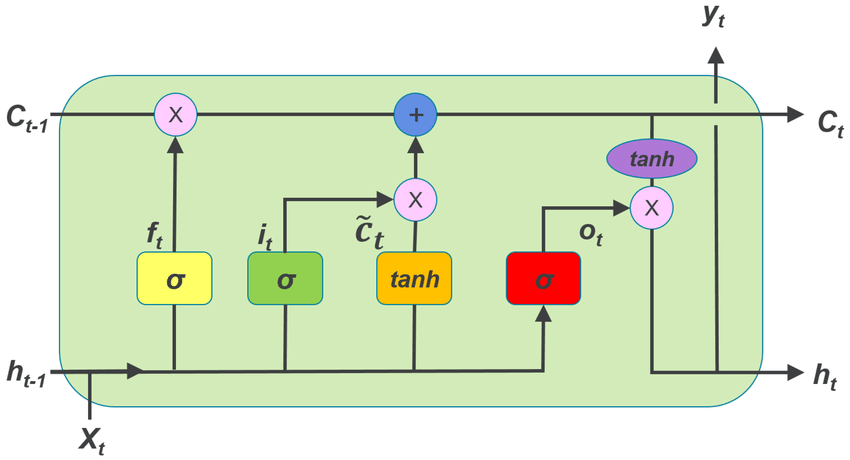


Como parte de la investigacion se realizara una pequeña prueba, importando el modelo de keras, entrenando y evaluando con el mismo set de datos, esto debido a la complejidad del modelo, esto es solo un ejercicio de aprendizaje, con el se observará por encima los resultados del modelo

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

def sampling(sequence, n_steps):

  X, Y = list(), list()

  for i in range(len(sequence)):

    sam = i + n_steps
    if sam > len(sequence)-1:
      break

    x, y = sequence[i:sam], sequence[sam]

    X.append(x)

    Y.append(y)

  return np.array(X), np.array(Y)

n_steps = 3

X, Y = sampling(diario['cantidad_pasos'].tolist(), n_steps)

n_features = 1
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

X = X.reshape((X.shape[0], X.shape[1], 1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_2 (LSTM)                (None, 50)                10400     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
_________________________________________________________________


In [ ]:
model.fit(X, Y, epochs=200, verbose=0)

In [ ]:
ypred = model.predict(X, verbose=0)

ypred

array([[35130.33 ],
       [46211.598],
       [47293.965],
       ...,
       [29763.842],
       [36806.99 ],
       [32333.15 ]], dtype=float32)

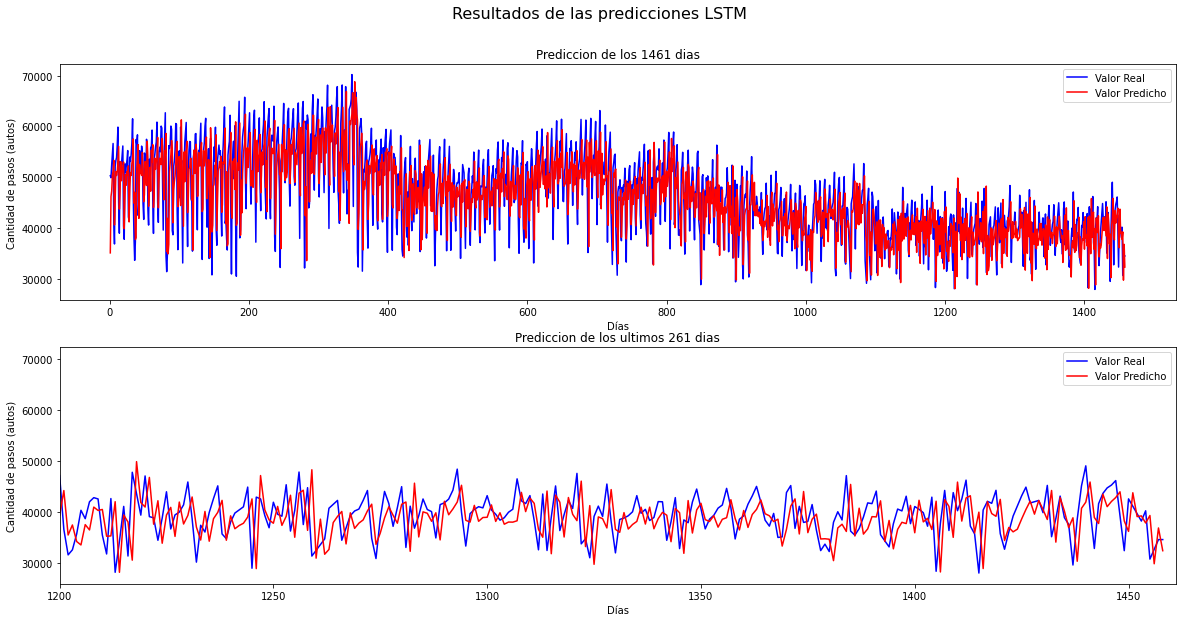

In [ ]:
plt.figure(figsize=(20,20))           #establece el tamaño de la grafica
plt.suptitle('Resultados de las predicciones LSTM', fontsize=16,y=0.92)  
plt.subplot(4,1,1)    
plt.plot(np.linspace(1,len(Y),num= len(Y)), Y, color="blue",label='Valor Real')
plt.plot(np.linspace(1,len(Y),num= len(Y)),ypred.reshape(-1,1) , color="red", label='Valor Predicho')    
plt.title(f'Prediccion de los 1461 dias')
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.legend()

plt.subplot(4,1,2)
plt.plot(np.linspace(1,len(Y),num= len(Y)), Y, color="blue",label='Valor Real')
plt.plot(np.linspace(1,len(Y),num= len(Y)),ypred.reshape(-1,1) , color="red", label='Valor Predicho')    
plt.title(f'Prediccion de los ultimos 261 dias')
plt.xlim(1200,1461)
plt.xlabel('Días')
plt.ylabel('Cantidad de pasos (autos)')
plt.legend()



Se observa una gran capacidad del modelo apra seguir los cambios, es un modelo bastante bueno, pero debido a ser una red neuronal, del campo del deep learning es una red mas compleja que los modelos que se suelen usar, desarrollar bien el modelo, requiere mas estudio sobre este tipo de redes neuronales, y se llevara a cabo un mejoramiento del modelo en una proxima ocasión.

# Conclusiones



*   Herramientas como autoarima nos permite una optimizacion rapida de parametros, sin tener que hacer una analisis exhaustivo de los autocorrelogramas.

*   El modelo ARIMA a pesar de no ser un modelo tan avanzado logra obtener unos resultados mas que aceptables, debido a sus compenente de AR(autoregregresion), I (parte integrada), y MA(media movil)

*   Si bien el modelo ARIMA predice mejor en relacion a las metricas usadas, arroja una predicción algo mas cercano al promedio o una linea de tendencia, modelos mas robustos como PROPHET si trata de marcar los cambios en la serie de tiempo en la proporcion deseada, tal vez una combinacion entre estos dos modelos, podría aumentar el rendimiento.

*   El modelo LSTM es excelente para series de tiempo, pero es un modelo bastante complejo, desarrollar bien este modelo requiere más dedicación y estudio, pero como proxima mejora del proyecto es un reto a considerar.

